Based on " Real-time Convolutional Neural Networks for Emotion and Gender Classification " 

https://arxiv.org/pdf/1710.07557.pdf

Reference : https://appliedmachinelearning.blog/2018/11/28/demonstration-of-facial-emotion-recognition-on-real-time-video-using-cnn-python-keras/

Data set : The data consists of 48x48 pixel grayscale images of faces. 
    
The faces have been automatically registered so that the face is more or less centered and 
occupies about the same amount of space in each image. 

The task is to categorize each face based on the emotion shown in the facial expression 
in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#prep train

In [ ]:
import pandas as pd 
import cv2
import numpy as np 
from sklearn.model_selection import train_test_split
FILE_PATH = '/content/drive/MyDrive/Data/unzip/fer2013/fer2013.csv'

In [ ]:
image_size = (48, 48)
data = pd.read_csv(FILE_PATH)  

In [ ]:
pixels = data['pixels'].tolist()
width, height = image_size

In [ ]:
# load images and emotions 
faces = []

for p in pixels:
    face = [int(pix) for pix in p.split(' ')]
    face = np.asarray(face).reshape(width, height)
    face = cv2.resize(face.astype('uint8'), image_size)
    faces.append(face.astype('float32'))

In [ ]:
len(faces)
faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)
emotions = pd.get_dummies(data['emotion']).values
emotions.shape

(35887, 7)

In [ ]:
# pre-process the images 
def preprocess(x, v2=True):  # v2 to keep the image btw. -1 and 1
    x = x.astype('float32')
    x = x/255.0
    if v2:
        x = (x - 0.5)*2.0
    return x
faces = preprocess(faces)

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)


#train CNN model : Mini Xception

In [ ]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.layers import Activation, Convolution2D, Conv2D, Dropout, AveragePooling2D, BatchNormalization, GlobalAveragePooling2D, Flatten, Input, MaxPooling2D, SeparableConv2D
from keras.models import Model
from keras.regularizers import l2

In [ ]:
#parameters 

batch_size = 128
epochs = 100
image_shape = (48, 48, 1)
verbose = True 
num_class = 7
patience = 50 # Numero de epochs sem melhora antes de parar o treino
base_path = '/content/drive/MyDrive/models/'
l2_regularization = 0.01


In [ ]:
data_generator = ImageDataGenerator(featurewise_center=False, featurewise_std_normalization=False, rotation_range=10, 
                                    width_shift_range=0.1, height_shift_range=0.1, zoom_range=.1, horizontal_flip=True)

In [ ]:
regularization = l2(l2_regularization)

In [ ]:
# model
image_input = Input(image_shape)
x = Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), kernel_regularizer=regularization, use_bias=False)(image_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# module 1
# residual module 
residual = Conv2D(filters=16, kernel_size=(1,1), strides=(2,2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)

x = SeparableConv2D(filters=16, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(filters=16, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = layers.add([x,residual])

# module 2
# residual module 
residual = Conv2D(filters=32, kernel_size=(1,1), strides=(2,2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)

x = SeparableConv2D(filters=32, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(filters=32, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = layers.add([x,residual])

# module 3
# residual module 
residual = Conv2D(filters=64, kernel_size=(1,1), strides=(2,2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)

x = SeparableConv2D(filters=64, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(filters=64, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = layers.add([x,residual])

# module 4
# residual module 
residual = Conv2D(filters=128, kernel_size=(1,1), strides=(2,2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)

x = SeparableConv2D(filters=128, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(filters=128, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = layers.add([x,residual])

x = Conv2D(filters=num_class, kernel_size=(3,3), padding='same')(x)
x = GlobalAveragePooling2D()(x)

output = Activation('softmax', name='predictions')(x)


In [ ]:
model = Model(image_input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()

In [ ]:
#definindo callbacks 

log_file_path = base_path + '_emotion_training.log'
csv_logger = CSVLogger(log_file_path, append=False)

early_stop = EarlyStopping(monitor='val_accuracy', patience=patience)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=int(patience/4), verbose=verbose)

trained_models_path = base_path + '_mini_xception'
model_names = trained_models_path + '.{epoch:02d}_{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(filepath=model_names, monitor='val_accuracy', verbose=verbose, save_best_only=True)

callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

In [ ]:
#treinamento

model.fit_generator(data_generator.flow(xtrain,
                                        ytrain,
                                        batch_size), 
                    steps_per_epoch=len(xtrain)/batch_size,
                                        epochs=epochs,
                                        verbose=verbose, 
                                        callbacks=callbacks,
                                        validation_data=(xtest, ytest))



Epoch 1/2000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


225/224 [==============================] - ETA: 0s - loss: 1.8214 - accuracy: 0.3065
Epoch 1: val_accuracy improved from -inf to 0.17790, saving model to /content/drive/MyDrive/models/_mini_xception.01_0.18.hdf5
224/224 [==============================] - 26s 73ms/step - loss: 1.8214 - accuracy: 0.3065 - val_loss: 1.9669 - val_accuracy: 0.1779 - lr: 0.0010
Epoch 2/2000
225/224 [==============================] - ETA: 0s - loss: 1.6400 - accuracy: 0.3882
Epoch 2: val_accuracy improved from 0.17790 to 0.37991, saving model to /content/drive/MyDrive/models/_mini_xception.02_0.38.hdf5
224/224 [==============================] - 16s 69ms/step - loss: 1.6400 - accuracy: 0.3882 - val_loss: 1.7073 - val_accuracy: 0.3799 - lr: 0.0010
Epoch 3/2000
225/224 [==============================] - ETA: 0s - loss: 1.5323 - accuracy: 0.4308
Epoch 3: val_accuracy improved from 0.37991 to 0.44622, saving model to /content/drive/MyDrive/models/_mini_xception.03_0.45.hdf5
224/224 [==============================]

# Detecting emotions of a face in an image 

In [ ]:
from tensorflow.keras.utils import img_to_array
from keras.models import load_model
import imutils
import sys 
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
detection_model_path = '/content/drive/MyDrive/models_primeiro/haarcascade_frontalface_default.xml'
emotion_recognition_model_path = '/content/drive/MyDrive/models_primeiro/_mini_xception.80_0.65.hdf5'

In [ ]:
emotion_classifier = load_model(emotion_recognition_model_path)

In [ ]:
face_detection = cv2.CascadeClassifier(detection_model_path)

In [ ]:
emotions = ['angry', 'disgust', 'scared', 'happy', 'sad', 'surprised', 'neutral']

In [ ]:
image_path = '/content/drive/MyDrive/Data/allan/allan_OCB_bravo.jpg'

color_frame = cv2.imread(image_path)
gray_frame = cv2.imread(image_path, 0)
detected_faces = face_detection.detectMultiScale(color_frame, scaleFactor=1.1, minNeighbors=5, 
                                        minSize=(30,30), flags=cv2.CASCADE_SCALE_IMAGE)
print('Number of faces detected : ', len(detected_faces))

for face in detected_faces:
    
    (fx, fy, fw, fh) = face
    
    im1 = gray_frame[fy:fy+fh, fx:fx+fw]
    im2 = cv2.resize(im1, (48,48))  # the model is trained on 48*48 pixel image 
    im3 = im2.astype("float")/255.0
    im4 = img_to_array(im3)
    im5 = np.expand_dims(im4, axis=0)

    preds = emotion_classifier.predict(im5)[0]
    emotion_probability = np.max(preds)
    label = emotions[preds.argmax()]
    
    print("emotion_probability: ",emotion_probability)
    print("Emotion: ",label)


Number of faces detected :  9
1/1 [==============================] - 0s 26ms/step
emotion_probability:  0.36033404
Emotion:  happy
1/1 [==============================] - 0s 16ms/step
emotion_probability:  0.76566595
Emotion:  neutral
1/1 [==============================] - 0s 15ms/step
emotion_probability:  0.370468
Emotion:  happy
1/1 [==============================] - 0s 15ms/step
emotion_probability:  0.38894883
Emotion:  sad
1/1 [==============================] - 0s 15ms/step
emotion_probability:  0.3790554
Emotion:  happy
1/1 [==============================] - 0s 18ms/step
emotion_probability:  0.28597608
Emotion:  happy
1/1 [==============================] - 0s 15ms/step
emotion_probability:  0.299634
Emotion:  happy
1/1 [==============================] - 0s 15ms/step
emotion_probability:  0.42060405
Emotion:  happy
1/1 [==============================] - 0s 17ms/step
emotion_probability:  0.28426966
Emotion:  happy


# confusion matrix

In [ ]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import img_to_array
from keras.models import load_model
import imutils
import sys 
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools

In [ ]:
detection_model_path = '/content/drive/MyDrive/models_primeiro/haarcascade_frontalface_default.xml'
emotion_recognition_model_path = '/content/drive/MyDrive/models_primeiro/model.h5'
FILE_PATH = '/content/drive/MyDrive/Data/unzip/fer2013/fer2013.csv'

In [ ]:
emotion_classifier = load_model(emotion_recognition_model_path)
data = pd.read_csv(FILE_PATH)   

In [ ]:
emotions = ['Raiva', 'Nojo', 'Medo', 'Felicidade', 'Tristeza', 'Surpresa', 'Neutro']

In [ ]:
listImages = data.query('Usage == "PrivateTest" or Usage == "PublicTest"')
listImages.reset_index()

In [ ]:
listPreds = list()
listLabes = list()
countIdx = 0
for im in tqdm(listImages['pixels']):
  b = bytes(int(p) for p in im.split())
  img1 = Image.frombuffer('L', (48, 48), b) 
  img3 = img_to_array(img1)
  img4 = img3.astype("float")/255.0
  img5 = np.expand_dims(img4, axis=0)
  preds = emotion_classifier.predict(img5)[0]
  emotion_probability = np.max(preds)
  label = emotions[preds.argmax()]
  listPreds.append(label)
  listLabes.append(emotions[listImages.iat[countIdx,0]])
  countIdx +=1;

In [ ]:
listPreds = list()
listLabes = list()
countIdx = 0
for im in tqdm(listImages['pixels']):
  data = np.array(im.split(" "), dtype=np.uint8)
  data = data.reshape(48,48)

  im3 = data.astype("float")/255.0
  im4 = img_to_array(im3)
  im5 = np.expand_dims(im4, axis=0)

  preds = emotion_classifier.predict(im5)[0]
  emotion_probability = np.max(preds)
  label = emotions[preds.argmax()]
  
  listPreds.append(label)
  listLabes.append(emotions[listImages.iat[countIdx,0]])
  countIdx +=1;

  0%|          | 0/7178 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step


  0%|          | 3/7178 [00:00<05:34, 21.44it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 6/7178 [00:00<06:01, 19.84it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 9/7178 [00:00<05:52, 20.34it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 12/7178 [00:00<05:46, 20.68it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 15/7178 [00:00<05:50, 20.44it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 18/7178 [00:00<05:56, 20.10it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 21/7178 [00:01<05:54, 20.20it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 24/7178 [00:01<05:46, 20.65it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 27/7178 [00:01<05:44, 20.74it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 30/7178 [00:01<05:44, 20.74it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 33/7178 [00:01<05:53, 20.22it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 36/7178 [00:01<05:51, 20.30it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 39/7178 [00:01<05:44, 20.75it/s]

1/1 [==============================] - 0s 14ms/step


  1%|          | 42/7178 [00:02<05:42, 20.84it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 45/7178 [00:02<05:40, 20.93it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 48/7178 [00:02<05:43, 20.74it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 51/7178 [00:02<05:53, 20.16it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 54/7178 [00:02<05:50, 20.35it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 57/7178 [00:02<05:49, 20.35it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 60/7178 [00:02<05:51, 20.27it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 63/7178 [00:03<05:48, 20.43it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 66/7178 [00:03<05:46, 20.51it/s]

1/1 [==============================] - 0s 14ms/step


  1%|          | 69/7178 [00:03<05:44, 20.62it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 72/7178 [00:03<05:47, 20.48it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 75/7178 [00:03<05:47, 20.46it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 78/7178 [00:03<05:52, 20.15it/s]

1/1 [==============================] - 0s 14ms/step


  1%|          | 81/7178 [00:03<05:56, 19.89it/s]

1/1 [==============================] - 0s 14ms/step


  1%|          | 84/7178 [00:04<05:45, 20.51it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 87/7178 [00:04<05:45, 20.51it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 90/7178 [00:04<05:43, 20.66it/s]

1/1 [==============================] - 0s 15ms/step


  1%|▏         | 93/7178 [00:04<05:47, 20.37it/s]

1/1 [==============================] - 0s 15ms/step


  1%|▏         | 96/7178 [00:04<05:50, 20.20it/s]

1/1 [==============================] - 0s 15ms/step


  1%|▏         | 99/7178 [00:04<05:54, 19.95it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 102/7178 [00:04<05:47, 20.34it/s]

1/1 [==============================] - 0s 15ms/step


  1%|▏         | 105/7178 [00:05<05:46, 20.38it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 108/7178 [00:05<05:46, 20.43it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 111/7178 [00:05<05:50, 20.14it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 114/7178 [00:05<05:44, 20.49it/s]

1/1 [==============================] - 0s 14ms/step


  2%|▏         | 117/7178 [00:05<05:52, 20.03it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 120/7178 [00:05<05:54, 19.93it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 123/7178 [00:06<05:47, 20.27it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 126/7178 [00:06<05:46, 20.38it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 129/7178 [00:06<05:48, 20.23it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 132/7178 [00:06<05:52, 19.98it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 135/7178 [00:06<05:47, 20.27it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 138/7178 [00:06<05:48, 20.19it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 141/7178 [00:06<05:47, 20.22it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 144/7178 [00:07<05:43, 20.51it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 147/7178 [00:07<05:38, 20.77it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 150/7178 [00:07<05:49, 20.12it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 153/7178 [00:07<05:53, 19.89it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 156/7178 [00:07<05:49, 20.09it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 159/7178 [00:26<05:48, 20.11it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 160/7178 [00:39<7:54:37,  4.06s/it]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 162/7178 [00:40<5:51:17,  3.00s/it]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 164/7178 [00:40<4:16:53,  2.20s/it]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 167/7178 [00:40<2:44:02,  1.40s/it]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 169/7178 [00:40<2:03:03,  1.05s/it]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 171/7178 [00:40<1:31:18,  1.28it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 173/7178 [00:40<1:07:28,  1.73it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 176/7178 [00:40<44:11,  2.64it/s]  

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 179/7178 [00:40<31:07,  3.75it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 181/7178 [00:41<24:52,  4.69it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 183/7178 [00:41<19:53,  5.86it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 186/7178 [00:41<14:45,  7.90it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 188/7178 [00:41<12:28,  9.33it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 190/7178 [00:41<10:56, 10.65it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 192/7178 [00:41<09:35, 12.15it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 194/7178 [00:41<08:35, 13.54it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 197/7178 [00:41<07:27, 15.58it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 200/7178 [00:42<07:07, 16.31it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 202/7178 [00:42<06:53, 16.89it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 205/7178 [00:42<06:25, 18.08it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 207/7178 [00:42<06:17, 18.46it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 210/7178 [00:42<06:22, 18.23it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 212/7178 [00:42<06:16, 18.51it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 215/7178 [00:42<06:04, 19.13it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 218/7178 [00:42<05:52, 19.72it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 220/7178 [00:43<05:57, 19.46it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 222/7178 [00:43<05:58, 19.41it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 225/7178 [00:43<05:50, 19.84it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 228/7178 [00:43<05:43, 20.23it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 231/7178 [00:43<05:48, 19.91it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 233/7178 [00:43<05:51, 19.78it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 236/7178 [00:43<05:52, 19.71it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 239/7178 [00:43<05:48, 19.90it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 241/7178 [00:44<05:58, 19.36it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 243/7178 [00:44<05:58, 19.32it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 246/7178 [00:44<05:50, 19.76it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 249/7178 [00:44<05:43, 20.20it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 252/7178 [00:44<05:57, 19.38it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▎         | 254/7178 [00:44<05:55, 19.45it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▎         | 256/7178 [00:44<05:55, 19.44it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▎         | 259/7178 [00:44<05:47, 19.89it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▎         | 261/7178 [00:45<05:52, 19.62it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 263/7178 [00:45<05:58, 19.28it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▎         | 266/7178 [00:45<05:48, 19.81it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▎         | 269/7178 [00:45<05:47, 19.89it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 272/7178 [00:45<05:46, 19.91it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 274/7178 [00:45<05:53, 19.56it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 277/7178 [00:45<05:44, 20.01it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 279/7178 [00:46<05:47, 19.87it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 282/7178 [00:46<05:43, 20.05it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 285/7178 [00:46<05:45, 19.96it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 288/7178 [00:46<05:40, 20.21it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 291/7178 [00:46<05:43, 20.05it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 294/7178 [00:46<05:47, 19.82it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 296/7178 [00:46<05:54, 19.41it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 299/7178 [00:47<05:47, 19.77it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 301/7178 [00:47<05:52, 19.53it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 303/7178 [00:47<05:52, 19.52it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 306/7178 [00:47<05:45, 19.90it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 309/7178 [00:47<05:35, 20.50it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 312/7178 [00:47<05:35, 20.48it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 315/7178 [00:47<05:42, 20.04it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 318/7178 [00:47<05:45, 19.88it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 320/7178 [00:48<05:49, 19.62it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 322/7178 [00:48<05:52, 19.46it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▍         | 325/7178 [00:48<05:49, 19.63it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▍         | 328/7178 [00:48<05:44, 19.88it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 330/7178 [00:48<05:44, 19.88it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 332/7178 [00:48<05:52, 19.43it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 334/7178 [00:48<05:59, 19.03it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 336/7178 [00:48<05:56, 19.18it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 338/7178 [00:49<06:05, 18.69it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 340/7178 [00:49<06:16, 18.16it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 342/7178 [00:49<06:15, 18.19it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▍         | 344/7178 [00:49<06:19, 18.03it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▍         | 346/7178 [00:49<06:11, 18.39it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 349/7178 [00:49<06:05, 18.68it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 351/7178 [00:49<06:04, 18.74it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▍         | 353/7178 [00:49<06:00, 18.94it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 355/7178 [00:49<06:06, 18.63it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 357/7178 [00:50<05:59, 18.96it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▌         | 359/7178 [00:50<05:56, 19.15it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▌         | 361/7178 [00:50<06:07, 18.55it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 363/7178 [00:50<06:09, 18.44it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 365/7178 [00:50<06:10, 18.38it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 367/7178 [00:50<06:01, 18.82it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 369/7178 [00:50<06:08, 18.47it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 371/7178 [00:50<06:23, 17.76it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 373/7178 [00:50<06:32, 17.33it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 375/7178 [00:51<06:29, 17.45it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▌         | 377/7178 [00:51<06:22, 17.80it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 379/7178 [00:51<06:10, 18.37it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▌         | 381/7178 [00:51<06:01, 18.80it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 384/7178 [00:51<05:49, 19.42it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 386/7178 [00:51<06:02, 18.73it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 388/7178 [00:51<05:59, 18.89it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 390/7178 [00:51<06:08, 18.41it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 393/7178 [00:51<05:54, 19.14it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 395/7178 [00:52<06:03, 18.65it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 397/7178 [00:52<06:12, 18.20it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 399/7178 [00:52<06:08, 18.39it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 402/7178 [00:52<05:59, 18.83it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 404/7178 [00:52<05:55, 19.05it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 406/7178 [00:52<06:01, 18.73it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 408/7178 [00:52<06:07, 18.42it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 411/7178 [00:52<05:50, 19.31it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 413/7178 [00:53<05:48, 19.42it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 415/7178 [00:53<05:49, 19.35it/s]

1/1 [==============================] - 0s 14ms/step


  6%|▌         | 417/7178 [00:53<06:00, 18.74it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 419/7178 [00:53<06:00, 18.73it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 422/7178 [00:53<05:48, 19.38it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 424/7178 [00:53<05:47, 19.45it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 426/7178 [00:53<05:54, 19.07it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 428/7178 [00:53<05:59, 18.77it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 430/7178 [00:53<05:59, 18.78it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 432/7178 [00:54<05:53, 19.10it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 434/7178 [00:54<05:54, 19.04it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 436/7178 [00:54<06:04, 18.50it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 438/7178 [00:54<06:03, 18.54it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 440/7178 [00:54<06:02, 18.59it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 442/7178 [00:54<06:03, 18.55it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 444/7178 [00:54<06:05, 18.43it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 446/7178 [00:54<05:59, 18.72it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 448/7178 [00:54<06:05, 18.43it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 450/7178 [00:55<05:58, 18.77it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 452/7178 [00:55<05:54, 18.96it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 454/7178 [00:55<05:52, 19.06it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▋         | 456/7178 [00:55<05:48, 19.26it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 458/7178 [00:55<05:50, 19.15it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 460/7178 [00:55<05:58, 18.72it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 462/7178 [00:55<06:03, 18.50it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 464/7178 [00:55<05:57, 18.76it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 466/7178 [00:55<05:56, 18.85it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 468/7178 [00:55<06:02, 18.51it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 470/7178 [00:56<06:04, 18.41it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 472/7178 [00:56<06:01, 18.54it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 474/7178 [00:56<06:04, 18.38it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 476/7178 [00:56<06:12, 18.02it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 478/7178 [00:56<06:06, 18.26it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 480/7178 [00:56<06:05, 18.32it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 482/7178 [00:56<06:06, 18.27it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 484/7178 [00:56<06:05, 18.30it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 486/7178 [00:56<05:57, 18.72it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 488/7178 [00:57<05:54, 18.86it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 490/7178 [00:57<05:54, 18.87it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 492/7178 [00:57<06:01, 18.48it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 494/7178 [00:57<06:09, 18.09it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 496/7178 [00:57<06:07, 18.18it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 498/7178 [00:57<06:02, 18.43it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 500/7178 [00:57<06:06, 18.23it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 502/7178 [00:57<06:06, 18.22it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 504/7178 [00:57<06:21, 17.49it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 506/7178 [00:58<06:26, 17.25it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 509/7178 [00:58<05:59, 18.55it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 511/7178 [00:58<06:16, 17.71it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 513/7178 [00:58<06:07, 18.13it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 515/7178 [00:58<06:04, 18.26it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 517/7178 [00:58<06:09, 18.04it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 519/7178 [00:58<06:05, 18.21it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 521/7178 [00:58<06:11, 17.92it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 523/7178 [00:58<06:05, 18.20it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 525/7178 [00:59<06:03, 18.28it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 527/7178 [00:59<05:55, 18.72it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 529/7178 [00:59<06:01, 18.39it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 531/7178 [00:59<06:05, 18.19it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 533/7178 [00:59<05:57, 18.61it/s]

1/1 [==============================] - 0s 15ms/step


  7%|▋         | 535/7178 [00:59<05:53, 18.77it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 537/7178 [00:59<05:54, 18.72it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 539/7178 [00:59<05:49, 19.00it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 541/7178 [00:59<05:59, 18.48it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 543/7178 [01:00<05:52, 18.81it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 545/7178 [01:00<05:54, 18.72it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 547/7178 [01:00<05:49, 18.99it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 549/7178 [01:00<05:50, 18.91it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 551/7178 [01:00<06:09, 17.96it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 553/7178 [01:00<06:00, 18.39it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 555/7178 [01:00<06:00, 18.35it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 557/7178 [01:00<05:55, 18.64it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 559/7178 [01:00<05:54, 18.70it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 561/7178 [01:01<05:49, 18.92it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 563/7178 [01:01<05:48, 18.97it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 565/7178 [01:01<05:50, 18.88it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 567/7178 [01:01<05:57, 18.47it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 569/7178 [01:01<05:54, 18.62it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 571/7178 [01:01<06:00, 18.35it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 573/7178 [01:01<06:08, 17.91it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 575/7178 [01:01<06:09, 17.86it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 577/7178 [01:01<06:02, 18.20it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 579/7178 [01:02<06:02, 18.21it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 581/7178 [01:02<05:54, 18.60it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 583/7178 [01:02<05:55, 18.53it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 585/7178 [01:02<05:51, 18.75it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 587/7178 [01:02<06:06, 17.99it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 589/7178 [01:02<06:01, 18.23it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 591/7178 [01:02<05:58, 18.36it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 593/7178 [01:02<06:03, 18.13it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 595/7178 [01:02<06:02, 18.18it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 597/7178 [01:02<05:56, 18.48it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 599/7178 [01:03<05:54, 18.58it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 601/7178 [01:03<05:49, 18.79it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 603/7178 [01:03<05:50, 18.78it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 605/7178 [01:03<06:01, 18.19it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 607/7178 [01:03<06:04, 18.04it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 609/7178 [01:03<05:56, 18.42it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 611/7178 [01:03<05:57, 18.39it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▊         | 613/7178 [01:03<05:58, 18.32it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 615/7178 [01:03<05:57, 18.38it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 617/7178 [01:04<05:56, 18.42it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▊         | 619/7178 [01:04<05:52, 18.61it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 621/7178 [01:04<05:52, 18.59it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 623/7178 [01:04<05:57, 18.34it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 625/7178 [01:04<05:59, 18.23it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 627/7178 [01:04<06:15, 17.45it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 629/7178 [01:04<06:18, 17.28it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 631/7178 [01:04<06:14, 17.50it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 633/7178 [01:04<06:05, 17.89it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 635/7178 [01:05<06:10, 17.67it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 637/7178 [01:05<06:07, 17.80it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 639/7178 [01:05<06:00, 18.16it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 641/7178 [01:05<05:56, 18.33it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 643/7178 [01:05<06:00, 18.11it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 645/7178 [01:05<06:00, 18.11it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 647/7178 [01:05<05:57, 18.25it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 649/7178 [01:05<05:53, 18.45it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 651/7178 [01:05<05:55, 18.36it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 654/7178 [01:06<05:49, 18.66it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 656/7178 [01:06<05:46, 18.83it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 658/7178 [01:06<05:42, 19.01it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 660/7178 [01:06<05:55, 18.32it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 662/7178 [01:06<05:55, 18.34it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 664/7178 [01:06<05:59, 18.12it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 666/7178 [01:06<06:01, 18.03it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 668/7178 [01:06<06:05, 17.80it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 670/7178 [01:07<06:06, 17.78it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 672/7178 [01:07<05:59, 18.12it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 674/7178 [01:07<05:53, 18.42it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 676/7178 [01:07<06:03, 17.88it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 678/7178 [01:07<05:56, 18.24it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 680/7178 [01:07<05:56, 18.20it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 682/7178 [01:07<05:47, 18.69it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 684/7178 [01:07<05:53, 18.39it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 686/7178 [01:07<05:49, 18.55it/s]

1/1 [==============================] - 0s 15ms/step


 10%|▉         | 688/7178 [01:07<05:50, 18.53it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 690/7178 [01:08<05:55, 18.27it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 692/7178 [01:08<05:55, 18.22it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 694/7178 [01:08<05:50, 18.48it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 696/7178 [01:08<06:02, 17.86it/s]

1/1 [==============================] - 0s 15ms/step


 10%|▉         | 698/7178 [01:08<06:02, 17.86it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 700/7178 [01:08<06:04, 17.77it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 702/7178 [01:08<05:58, 18.07it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 704/7178 [01:08<05:58, 18.04it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 706/7178 [01:08<06:11, 17.43it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 708/7178 [01:09<06:12, 17.36it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 710/7178 [01:09<06:12, 17.37it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 712/7178 [01:09<06:05, 17.68it/s]

1/1 [==============================] - 0s 15ms/step


 10%|▉         | 714/7178 [01:09<05:54, 18.21it/s]

1/1 [==============================] - 0s 15ms/step


 10%|▉         | 716/7178 [01:09<05:57, 18.10it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 718/7178 [01:09<05:54, 18.21it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 720/7178 [01:09<05:59, 17.98it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 722/7178 [01:09<05:59, 17.96it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 725/7178 [01:10<05:42, 18.84it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 727/7178 [01:10<05:50, 18.41it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 729/7178 [01:10<05:45, 18.66it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 731/7178 [01:10<06:05, 17.62it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 733/7178 [01:10<06:06, 17.56it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 735/7178 [01:10<06:10, 17.40it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 737/7178 [01:10<06:13, 17.25it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 739/7178 [01:10<05:59, 17.90it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 741/7178 [01:10<06:03, 17.69it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 743/7178 [01:11<05:58, 17.97it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 745/7178 [01:11<05:50, 18.33it/s]

1/1 [==============================] - 0s 14ms/step


 10%|█         | 747/7178 [01:11<05:44, 18.69it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 749/7178 [01:11<05:46, 18.53it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 751/7178 [01:11<05:50, 18.33it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 753/7178 [01:11<06:04, 17.65it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 755/7178 [01:11<06:02, 17.70it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 757/7178 [01:11<05:55, 18.05it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 759/7178 [01:11<06:07, 17.46it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 761/7178 [01:12<06:02, 17.71it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 763/7178 [01:12<05:54, 18.07it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 765/7178 [01:12<05:55, 18.05it/s]

1/1 [==============================] - 0s 14ms/step


 11%|█         | 767/7178 [01:12<05:45, 18.57it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 769/7178 [01:12<05:51, 18.22it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 771/7178 [01:12<05:54, 18.06it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 773/7178 [01:12<05:54, 18.09it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 775/7178 [01:12<05:55, 18.00it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 777/7178 [01:12<05:46, 18.45it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 779/7178 [01:13<05:59, 17.81it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 781/7178 [01:13<05:56, 17.96it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 783/7178 [01:13<05:51, 18.17it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 785/7178 [01:13<05:57, 17.89it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 787/7178 [01:13<05:54, 18.03it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 789/7178 [01:13<06:02, 17.63it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 791/7178 [01:13<06:01, 17.68it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 793/7178 [01:13<05:52, 18.12it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 795/7178 [01:13<05:48, 18.31it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 797/7178 [01:14<05:51, 18.14it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 799/7178 [01:14<05:53, 18.04it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 801/7178 [01:14<05:55, 17.96it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█         | 803/7178 [01:14<05:50, 18.18it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 805/7178 [01:14<05:52, 18.07it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 807/7178 [01:14<05:52, 18.05it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█▏        | 809/7178 [01:14<06:04, 17.48it/s]

1/1 [==============================] - 0s 77ms/step


 11%|█▏        | 811/7178 [01:15<09:17, 11.43it/s]

1/1 [==============================] - 0s 53ms/step


 11%|█▏        | 813/7178 [01:15<12:30,  8.49it/s]

1/1 [==============================] - 0s 15ms/step


 11%|█▏        | 815/7178 [01:15<11:36,  9.13it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 817/7178 [01:15<09:56, 10.67it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 819/7178 [01:15<08:49, 12.01it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 821/7178 [01:15<08:03, 13.15it/s]

1/1 [==============================] - 0s 72ms/step


 11%|█▏        | 823/7178 [01:16<11:15,  9.41it/s]

1/1 [==============================] - 0s 59ms/step


 11%|█▏        | 825/7178 [01:16<13:15,  7.99it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 827/7178 [01:16<12:06,  8.74it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 829/7178 [01:16<10:06, 10.47it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 831/7178 [01:17<08:52, 11.92it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 833/7178 [01:17<07:59, 13.24it/s]

1/1 [==============================] - 0s 75ms/step


 12%|█▏        | 835/7178 [01:17<09:48, 10.78it/s]

1/1 [==============================] - 0s 63ms/step


 12%|█▏        | 837/7178 [01:17<13:14,  7.98it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 839/7178 [01:17<12:04,  8.75it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 841/7178 [01:18<10:15, 10.29it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 843/7178 [01:18<08:55, 11.84it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 845/7178 [01:18<07:58, 13.23it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 848/7178 [01:18<06:57, 15.15it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 850/7178 [01:18<06:44, 15.63it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 852/7178 [01:18<06:35, 15.98it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 854/7178 [01:18<06:32, 16.13it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 856/7178 [01:18<06:19, 16.65it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 858/7178 [01:19<06:12, 16.99it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 860/7178 [01:19<06:04, 17.32it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 862/7178 [01:19<06:09, 17.09it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 864/7178 [01:19<06:06, 17.22it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 866/7178 [01:19<05:59, 17.58it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 868/7178 [01:19<06:06, 17.20it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 870/7178 [01:19<06:07, 17.17it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 872/7178 [01:19<06:27, 16.26it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 874/7178 [01:20<06:22, 16.48it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 876/7178 [01:20<06:02, 17.39it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 878/7178 [01:20<06:01, 17.42it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 880/7178 [01:20<05:57, 17.63it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 882/7178 [01:20<05:56, 17.64it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 884/7178 [01:20<05:50, 17.97it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 886/7178 [01:20<05:53, 17.79it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 888/7178 [01:20<05:57, 17.60it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 890/7178 [01:20<05:56, 17.63it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 892/7178 [01:21<06:11, 16.92it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 894/7178 [01:21<06:16, 16.68it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 896/7178 [01:21<06:11, 16.89it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 898/7178 [01:21<06:05, 17.17it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 900/7178 [01:21<06:02, 17.30it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 902/7178 [01:21<06:06, 17.13it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 904/7178 [01:21<06:08, 17.04it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 906/7178 [01:21<06:04, 17.22it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 908/7178 [01:21<06:02, 17.28it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 910/7178 [01:22<05:57, 17.54it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 912/7178 [01:22<05:57, 17.51it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 914/7178 [01:22<06:00, 17.39it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 916/7178 [01:22<06:04, 17.16it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 918/7178 [01:22<05:57, 17.51it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 920/7178 [01:22<05:55, 17.61it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 922/7178 [01:22<05:57, 17.52it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 924/7178 [01:22<06:11, 16.82it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 926/7178 [01:22<05:55, 17.57it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 928/7178 [01:23<05:46, 18.04it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 930/7178 [01:23<05:42, 18.23it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 932/7178 [01:23<05:41, 18.31it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 934/7178 [01:23<05:44, 18.10it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 936/7178 [01:23<05:42, 18.20it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 938/7178 [01:23<05:46, 17.98it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 940/7178 [01:23<05:44, 18.08it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 942/7178 [01:23<05:47, 17.94it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 944/7178 [01:23<05:46, 17.98it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 946/7178 [01:24<05:45, 18.06it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 948/7178 [01:24<05:42, 18.18it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 950/7178 [01:24<05:34, 18.60it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 952/7178 [01:24<05:41, 18.22it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 954/7178 [01:24<05:55, 17.51it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 956/7178 [01:24<05:55, 17.48it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 958/7178 [01:24<05:52, 17.65it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 960/7178 [01:24<05:48, 17.84it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 962/7178 [01:24<05:47, 17.88it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 964/7178 [01:25<05:57, 17.36it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 966/7178 [01:25<05:54, 17.51it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 968/7178 [01:25<05:49, 17.76it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▎        | 970/7178 [01:25<05:55, 17.46it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 972/7178 [01:25<05:56, 17.40it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 974/7178 [01:25<06:00, 17.20it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▎        | 976/7178 [01:25<05:55, 17.45it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▎        | 978/7178 [01:25<05:49, 17.75it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▎        | 980/7178 [01:26<05:48, 17.81it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▎        | 982/7178 [01:26<05:48, 17.76it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 984/7178 [01:26<05:49, 17.73it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▎        | 986/7178 [01:26<05:58, 17.27it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 988/7178 [01:26<05:54, 17.46it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 990/7178 [01:26<05:52, 17.57it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 992/7178 [01:26<05:59, 17.19it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 994/7178 [01:26<06:01, 17.10it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 996/7178 [01:26<05:58, 17.25it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 998/7178 [01:27<05:57, 17.29it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1000/7178 [01:27<05:49, 17.68it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 1002/7178 [01:27<05:51, 17.56it/s]

1/1 [==============================] - 0s 14ms/step


 14%|█▍        | 1004/7178 [01:27<05:45, 17.88it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 1006/7178 [01:27<05:55, 17.35it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 1008/7178 [01:27<05:59, 17.18it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1010/7178 [01:27<06:07, 16.80it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 1012/7178 [01:27<05:58, 17.22it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 1014/7178 [01:27<05:56, 17.29it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 1016/7178 [01:28<06:07, 16.78it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 1018/7178 [01:28<05:58, 17.17it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 1020/7178 [01:28<06:02, 16.97it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 1022/7178 [01:28<05:53, 17.43it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 1024/7178 [01:28<05:54, 17.35it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 1026/7178 [01:28<05:56, 17.24it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 1028/7178 [01:28<05:55, 17.32it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 1030/7178 [01:28<05:53, 17.39it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 1032/7178 [01:29<05:50, 17.55it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 1034/7178 [01:29<05:59, 17.07it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 1036/7178 [01:29<06:04, 16.85it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 1038/7178 [01:29<06:10, 16.58it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 1040/7178 [01:29<06:02, 16.93it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 1042/7178 [01:29<05:54, 17.33it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 1044/7178 [01:29<05:48, 17.61it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 1046/7178 [01:29<05:52, 17.41it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 1048/7178 [01:29<05:52, 17.40it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 1050/7178 [01:30<05:55, 17.22it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 1052/7178 [01:30<06:00, 17.02it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 1054/7178 [01:30<06:02, 16.91it/s]

1/1 [==============================] - 0s 14ms/step


 15%|█▍        | 1056/7178 [01:30<05:57, 17.13it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 1058/7178 [01:30<05:57, 17.13it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 1060/7178 [01:30<05:53, 17.32it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 1062/7178 [01:30<05:57, 17.09it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 1064/7178 [01:30<05:56, 17.17it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 1066/7178 [01:30<05:44, 17.74it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 1068/7178 [01:31<06:01, 16.91it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 1070/7178 [01:31<05:53, 17.26it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 1072/7178 [01:31<05:55, 17.16it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 1074/7178 [01:31<05:47, 17.58it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 1076/7178 [01:31<05:55, 17.17it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 1078/7178 [01:31<06:04, 16.72it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 1080/7178 [01:31<05:52, 17.31it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 1082/7178 [01:31<05:52, 17.30it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 1084/7178 [01:32<05:45, 17.66it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 1086/7178 [01:32<05:53, 17.24it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 1088/7178 [01:32<09:14, 10.99it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 1090/7178 [01:32<08:14, 12.31it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 1092/7178 [01:32<07:32, 13.44it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 1094/7178 [01:32<07:00, 14.48it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 1096/7178 [01:32<06:40, 15.18it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 1098/7178 [01:33<06:34, 15.41it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 1100/7178 [01:33<06:29, 15.59it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 1102/7178 [01:33<06:22, 15.87it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 1104/7178 [01:33<06:11, 16.36it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 1106/7178 [01:33<06:03, 16.69it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 1108/7178 [01:33<05:58, 16.93it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 1110/7178 [01:33<05:59, 16.90it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 1112/7178 [01:33<05:45, 17.55it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 1114/7178 [01:33<05:43, 17.64it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 1116/7178 [01:34<05:38, 17.92it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1118/7178 [01:34<06:03, 16.67it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1120/7178 [01:34<05:47, 17.41it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1122/7178 [01:34<05:34, 18.11it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1124/7178 [01:34<05:37, 17.96it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 1126/7178 [01:34<05:41, 17.71it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 1128/7178 [01:34<05:50, 17.27it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1130/7178 [01:34<05:41, 17.69it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1132/7178 [01:35<05:35, 18.01it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1134/7178 [01:35<05:40, 17.77it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1136/7178 [01:35<05:45, 17.50it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 1138/7178 [01:35<05:54, 17.03it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1140/7178 [01:35<05:57, 16.89it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1142/7178 [01:35<05:53, 17.07it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1144/7178 [01:35<05:51, 17.16it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1146/7178 [01:35<05:50, 17.19it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1148/7178 [01:35<05:49, 17.25it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1150/7178 [01:36<05:50, 17.21it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 1152/7178 [01:36<05:59, 16.76it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 1154/7178 [01:36<05:55, 16.96it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1156/7178 [01:36<06:04, 16.51it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1158/7178 [01:36<06:03, 16.55it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1160/7178 [01:36<06:03, 16.54it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1162/7178 [01:36<06:01, 16.66it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1164/7178 [01:36<05:51, 17.13it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1166/7178 [01:37<05:53, 17.02it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▋        | 1168/7178 [01:37<05:44, 17.46it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 1170/7178 [01:37<05:54, 16.94it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 1172/7178 [01:37<05:54, 16.95it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 1174/7178 [01:37<05:48, 17.21it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 1176/7178 [01:37<05:49, 17.18it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 1178/7178 [01:37<05:44, 17.43it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 1180/7178 [01:37<05:51, 17.05it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 1182/7178 [01:37<05:53, 16.95it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 1184/7178 [01:38<05:49, 17.14it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1186/7178 [01:38<05:51, 17.05it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1188/7178 [01:38<05:56, 16.81it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 1190/7178 [01:38<05:57, 16.77it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1192/7178 [01:38<06:00, 16.62it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1194/7178 [01:38<05:57, 16.73it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 1196/7178 [01:38<05:58, 16.70it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1198/7178 [01:38<05:52, 16.95it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1200/7178 [01:39<06:06, 16.29it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1202/7178 [01:39<06:07, 16.26it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1204/7178 [01:39<06:48, 14.62it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 1206/7178 [01:39<06:23, 15.55it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1208/7178 [01:39<06:12, 16.01it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1210/7178 [01:39<06:12, 16.04it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1212/7178 [01:39<06:01, 16.50it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 1214/7178 [01:39<05:57, 16.68it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 1216/7178 [01:40<05:50, 17.00it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1218/7178 [01:40<05:56, 16.72it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1220/7178 [01:40<05:54, 16.82it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 1222/7178 [01:40<05:55, 16.77it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1224/7178 [01:40<05:45, 17.23it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 1226/7178 [01:40<05:48, 17.07it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 1228/7178 [01:40<05:48, 17.09it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1230/7178 [01:40<05:54, 16.79it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 1232/7178 [01:40<05:48, 17.06it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1234/7178 [01:41<05:48, 17.07it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1236/7178 [01:41<05:49, 16.99it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 1238/7178 [01:41<05:49, 17.00it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 1240/7178 [01:41<05:56, 16.67it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 1242/7178 [01:41<05:59, 16.50it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 1244/7178 [01:41<06:01, 16.42it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1246/7178 [01:41<06:03, 16.34it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1248/7178 [01:41<05:54, 16.75it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1250/7178 [01:42<05:46, 17.09it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 1252/7178 [01:42<05:51, 16.85it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1254/7178 [01:42<05:46, 17.08it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1256/7178 [01:42<06:03, 16.29it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1258/7178 [01:42<05:51, 16.85it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1260/7178 [01:42<05:48, 17.00it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1262/7178 [01:42<05:58, 16.49it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 1264/7178 [01:42<05:54, 16.68it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 1266/7178 [01:43<05:45, 17.10it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 1268/7178 [01:43<05:48, 16.95it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1270/7178 [01:43<05:49, 16.92it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 1272/7178 [01:43<05:52, 16.76it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1274/7178 [01:43<06:30, 15.11it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1276/7178 [01:43<06:16, 15.68it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1278/7178 [01:43<06:15, 15.71it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 1280/7178 [01:43<06:00, 16.34it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1282/7178 [01:44<06:03, 16.21it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1284/7178 [01:44<05:59, 16.39it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1286/7178 [01:44<05:56, 16.51it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1288/7178 [01:44<05:53, 16.65it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1290/7178 [01:44<05:44, 17.07it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1292/7178 [01:44<05:50, 16.79it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1294/7178 [01:44<05:57, 16.46it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 1296/7178 [01:44<05:50, 16.76it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1298/7178 [01:44<05:44, 17.08it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1300/7178 [01:45<05:41, 17.20it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1302/7178 [01:45<05:47, 16.89it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1304/7178 [01:45<05:40, 17.25it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1306/7178 [01:45<05:51, 16.71it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1308/7178 [01:45<05:55, 16.50it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1310/7178 [01:45<06:03, 16.16it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1312/7178 [01:45<06:06, 16.01it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 1314/7178 [01:45<06:06, 16.00it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1316/7178 [01:46<06:08, 15.91it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1318/7178 [01:46<06:09, 15.87it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1320/7178 [01:46<06:21, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1322/7178 [01:46<06:24, 15.22it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1324/7178 [01:46<06:26, 15.15it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 1326/7178 [01:46<06:18, 15.46it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 1328/7178 [01:46<06:11, 15.73it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▊        | 1330/7178 [01:46<06:03, 16.07it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 1332/7178 [01:47<06:05, 15.99it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 1334/7178 [01:47<06:04, 16.02it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 1336/7178 [01:47<06:01, 16.15it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 1338/7178 [01:47<06:06, 15.93it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 1340/7178 [01:47<05:54, 16.45it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 1342/7178 [01:47<05:50, 16.65it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 1344/7178 [01:47<05:52, 16.53it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 1346/7178 [01:47<05:48, 16.75it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 1348/7178 [01:48<05:49, 16.68it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 1350/7178 [01:48<05:44, 16.94it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 1352/7178 [01:48<05:41, 17.04it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 1354/7178 [01:48<05:49, 16.65it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 1356/7178 [01:48<05:48, 16.69it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 1358/7178 [01:48<05:50, 16.59it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 1360/7178 [01:48<05:51, 16.55it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 1362/7178 [01:48<05:42, 16.98it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 1364/7178 [01:48<05:42, 16.99it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 1366/7178 [01:49<05:44, 16.88it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 1368/7178 [01:49<05:41, 17.01it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1370/7178 [01:49<05:42, 16.97it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 1372/7178 [01:49<05:41, 17.00it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 1374/7178 [01:49<05:44, 16.87it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 1376/7178 [01:49<05:53, 16.41it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 1378/7178 [01:49<05:45, 16.79it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 1380/7178 [01:49<05:44, 16.82it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 1382/7178 [01:50<05:44, 16.82it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▉        | 1384/7178 [01:50<05:43, 16.86it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 1386/7178 [01:50<05:44, 16.80it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 1388/7178 [01:50<05:45, 16.76it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 1390/7178 [01:50<05:42, 16.88it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 1392/7178 [01:50<05:43, 16.86it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1394/7178 [01:50<05:52, 16.42it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1396/7178 [01:50<05:45, 16.75it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1398/7178 [01:51<05:54, 16.32it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 1400/7178 [01:51<05:48, 16.57it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 1402/7178 [01:51<05:43, 16.81it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 1404/7178 [01:51<05:43, 16.83it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 1406/7178 [01:51<05:50, 16.49it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 1408/7178 [01:51<06:04, 15.81it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 1410/7178 [01:51<05:59, 16.02it/s]

1/1 [==============================] - 0s 15ms/step


 20%|█▉        | 1412/7178 [01:51<05:57, 16.15it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 1414/7178 [01:52<05:49, 16.48it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 1416/7178 [01:52<05:53, 16.30it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 1418/7178 [01:52<05:47, 16.57it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 1420/7178 [01:52<05:51, 16.37it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 1422/7178 [01:52<05:49, 16.49it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 1424/7178 [01:52<05:51, 16.37it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 1426/7178 [01:52<05:57, 16.07it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 1428/7178 [01:52<05:53, 16.26it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 1430/7178 [01:52<05:48, 16.48it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 1432/7178 [01:53<05:47, 16.54it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 1434/7178 [01:53<05:44, 16.66it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 1436/7178 [01:53<05:45, 16.64it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 1438/7178 [01:53<05:41, 16.81it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 1440/7178 [01:53<05:40, 16.87it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 1442/7178 [01:53<05:44, 16.63it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 1444/7178 [01:53<05:44, 16.65it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 1446/7178 [01:53<05:51, 16.31it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 1448/7178 [01:54<05:51, 16.30it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 1450/7178 [01:54<05:42, 16.73it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 1452/7178 [01:54<05:41, 16.76it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 1454/7178 [01:54<05:46, 16.52it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 1456/7178 [01:54<05:46, 16.51it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 1458/7178 [01:54<06:05, 15.63it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 1460/7178 [01:54<05:54, 16.15it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 1462/7178 [01:54<05:50, 16.29it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 1464/7178 [01:55<05:43, 16.63it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 1466/7178 [01:55<05:44, 16.60it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 1468/7178 [01:55<05:46, 16.48it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 1470/7178 [01:55<05:41, 16.72it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 1472/7178 [01:55<05:49, 16.32it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 1474/7178 [01:55<05:43, 16.61it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 1476/7178 [01:55<05:52, 16.18it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 1478/7178 [01:55<05:47, 16.39it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1480/7178 [01:56<05:43, 16.60it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 1482/7178 [01:56<05:49, 16.29it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 1484/7178 [01:56<05:51, 16.21it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 1486/7178 [01:56<05:40, 16.69it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1488/7178 [01:56<05:44, 16.51it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 1490/7178 [01:56<05:43, 16.54it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1492/7178 [01:56<05:57, 15.91it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 1494/7178 [01:56<05:55, 15.98it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 1496/7178 [01:56<05:44, 16.51it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 1498/7178 [01:57<05:55, 15.96it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 1500/7178 [01:57<05:49, 16.22it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 1502/7178 [01:57<05:43, 16.53it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 1504/7178 [01:57<05:43, 16.53it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 1506/7178 [01:57<05:45, 16.41it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 1508/7178 [01:57<05:49, 16.24it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1510/7178 [01:57<05:54, 15.97it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 1512/7178 [01:57<05:52, 16.08it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 1514/7178 [01:58<05:51, 16.12it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 1516/7178 [01:58<05:41, 16.56it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 1518/7178 [01:58<05:40, 16.63it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 1520/7178 [01:58<05:44, 16.44it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 1522/7178 [01:58<05:43, 16.47it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 1524/7178 [01:58<05:43, 16.45it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██▏       | 1526/7178 [01:58<05:42, 16.51it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 1528/7178 [01:58<05:46, 16.28it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 1530/7178 [01:59<05:39, 16.63it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 1532/7178 [01:59<05:39, 16.64it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 1534/7178 [01:59<05:38, 16.65it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 1536/7178 [01:59<05:43, 16.45it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██▏       | 1538/7178 [01:59<05:45, 16.34it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 1540/7178 [01:59<05:35, 16.81it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 1542/7178 [01:59<05:40, 16.54it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 1544/7178 [01:59<05:37, 16.69it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 1546/7178 [02:00<05:36, 16.75it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 1548/7178 [02:00<05:34, 16.84it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1550/7178 [02:00<05:42, 16.44it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 1552/7178 [02:00<05:41, 16.48it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1554/7178 [02:00<05:46, 16.21it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 1556/7178 [02:00<05:44, 16.33it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 1558/7178 [02:00<05:40, 16.51it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1560/7178 [02:00<05:51, 15.97it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 1562/7178 [02:01<05:41, 16.45it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 1564/7178 [02:01<05:39, 16.56it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 1566/7178 [02:01<05:27, 17.16it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 1568/7178 [02:01<05:37, 16.62it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 1570/7178 [02:01<05:43, 16.33it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1572/7178 [02:01<05:44, 16.27it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1574/7178 [02:01<05:39, 16.51it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1576/7178 [02:01<05:35, 16.72it/s]

1/1 [==============================] - 0s 14ms/step


 22%|██▏       | 1578/7178 [02:01<05:35, 16.71it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1580/7178 [02:02<05:37, 16.58it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 1582/7178 [02:02<05:28, 17.04it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 1584/7178 [02:02<05:25, 17.21it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1586/7178 [02:02<05:31, 16.84it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1588/7178 [02:02<05:41, 16.35it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 1590/7178 [02:02<05:41, 16.37it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 1592/7178 [02:02<05:40, 16.42it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 1594/7178 [02:02<05:51, 15.87it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1596/7178 [02:03<05:42, 16.32it/s]

1/1 [==============================] - 0s 14ms/step


 22%|██▏       | 1598/7178 [02:03<05:35, 16.66it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 1600/7178 [02:03<05:41, 16.33it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 1602/7178 [02:03<05:36, 16.58it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 1604/7178 [02:03<05:36, 16.57it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1606/7178 [02:03<05:37, 16.53it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 1608/7178 [02:03<05:39, 16.40it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 1610/7178 [02:03<05:38, 16.43it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1612/7178 [02:04<05:43, 16.21it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 1614/7178 [02:04<05:39, 16.37it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 1616/7178 [02:04<05:34, 16.63it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 1618/7178 [02:04<05:32, 16.74it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 1620/7178 [02:04<05:31, 16.74it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 1622/7178 [02:04<05:34, 16.63it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 1624/7178 [02:04<05:34, 16.61it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 1626/7178 [02:04<05:41, 16.24it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 1628/7178 [02:05<05:40, 16.31it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 1630/7178 [02:05<05:39, 16.33it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 1632/7178 [02:05<05:34, 16.60it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 1634/7178 [02:05<05:33, 16.65it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 1636/7178 [02:05<05:25, 17.01it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 1638/7178 [02:05<05:23, 17.11it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 1640/7178 [02:05<05:31, 16.72it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 1642/7178 [02:05<05:36, 16.45it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 1644/7178 [02:05<05:41, 16.19it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 1646/7178 [02:06<05:44, 16.06it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 1648/7178 [02:06<05:39, 16.28it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 1650/7178 [02:06<05:34, 16.54it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 1652/7178 [02:06<05:44, 16.05it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 1654/7178 [02:06<05:43, 16.10it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 1656/7178 [02:06<05:44, 16.03it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 1658/7178 [02:06<05:38, 16.32it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 1660/7178 [02:06<05:36, 16.41it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 1662/7178 [02:07<05:38, 16.29it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 1664/7178 [02:07<05:39, 16.24it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 1666/7178 [02:07<05:38, 16.31it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 1668/7178 [02:07<05:30, 16.69it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 1670/7178 [02:07<05:30, 16.68it/s]

1/1 [==============================] - 0s 14ms/step


 23%|██▎       | 1672/7178 [02:07<05:21, 17.15it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 1674/7178 [02:07<05:37, 16.32it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 1676/7178 [02:07<05:32, 16.57it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1678/7178 [02:08<05:35, 16.39it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 1680/7178 [02:08<05:32, 16.52it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 1682/7178 [02:08<05:31, 16.60it/s]

1/1 [==============================] - 0s 15ms/step


 23%|██▎       | 1684/7178 [02:08<05:41, 16.06it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 1686/7178 [02:08<05:35, 16.36it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 1688/7178 [02:08<05:34, 16.41it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 1690/7178 [02:08<05:30, 16.63it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 1692/7178 [02:08<05:34, 16.39it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 1694/7178 [02:09<05:58, 15.30it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 1696/7178 [02:09<06:04, 15.03it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 1698/7178 [02:09<05:52, 15.53it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 1700/7178 [02:09<05:46, 15.82it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 1702/7178 [02:09<05:42, 15.99it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 1704/7178 [02:09<05:48, 15.70it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 1706/7178 [02:09<05:45, 15.86it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1708/7178 [02:09<05:34, 16.37it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1710/7178 [02:10<05:41, 16.00it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 1712/7178 [02:10<05:34, 16.34it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 1714/7178 [02:10<05:38, 16.15it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 1716/7178 [02:10<05:32, 16.45it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 1718/7178 [02:10<05:35, 16.27it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 1720/7178 [02:10<05:43, 15.89it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 1722/7178 [02:10<05:36, 16.20it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1724/7178 [02:10<05:31, 16.44it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 1726/7178 [02:11<05:43, 15.88it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 1728/7178 [02:11<05:42, 15.93it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 1730/7178 [02:11<05:40, 16.01it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 1732/7178 [02:11<05:33, 16.32it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 1734/7178 [02:11<05:30, 16.45it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 1736/7178 [02:11<05:42, 15.88it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 1738/7178 [02:11<05:47, 15.67it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 1740/7178 [02:11<05:42, 15.89it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 1742/7178 [02:12<05:41, 15.93it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 1744/7178 [02:12<05:45, 15.73it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1746/7178 [02:12<05:47, 15.65it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 1748/7178 [02:12<05:36, 16.14it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 1750/7178 [02:12<05:31, 16.36it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 1752/7178 [02:12<05:33, 16.27it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 1754/7178 [02:12<05:33, 16.26it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 1756/7178 [02:12<05:43, 15.76it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 1758/7178 [02:13<05:34, 16.19it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 1760/7178 [02:13<05:40, 15.92it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▍       | 1762/7178 [02:13<05:32, 16.30it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 1764/7178 [02:13<05:36, 16.07it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▍       | 1766/7178 [02:13<05:36, 16.09it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▍       | 1768/7178 [02:13<05:32, 16.27it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 1770/7178 [02:13<05:40, 15.89it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 1772/7178 [02:13<05:41, 15.82it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▍       | 1774/7178 [02:14<05:33, 16.18it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 1776/7178 [02:14<05:45, 15.64it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 1778/7178 [02:14<05:36, 16.07it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 1780/7178 [02:14<05:34, 16.16it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▍       | 1782/7178 [02:14<05:24, 16.64it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 1784/7178 [02:14<05:25, 16.59it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 1786/7178 [02:14<05:30, 16.32it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 1788/7178 [02:14<05:32, 16.20it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 1790/7178 [02:15<05:32, 16.19it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▍       | 1792/7178 [02:15<05:33, 16.17it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 1794/7178 [02:15<05:38, 15.89it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 1796/7178 [02:15<05:49, 15.40it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 1798/7178 [02:15<05:41, 15.76it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 1800/7178 [02:15<05:35, 16.03it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 1802/7178 [02:15<05:34, 16.05it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 1804/7178 [02:15<05:36, 15.99it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 1806/7178 [02:16<05:27, 16.40it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 1808/7178 [02:16<05:39, 15.80it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 1810/7178 [02:16<05:41, 15.71it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 1812/7178 [02:16<05:36, 15.97it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1814/7178 [02:16<05:41, 15.69it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 1816/7178 [02:16<05:42, 15.63it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 1818/7178 [02:16<05:44, 15.55it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1820/7178 [02:16<05:47, 15.43it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 1822/7178 [02:17<05:35, 15.96it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 1824/7178 [02:17<05:31, 16.13it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 1826/7178 [02:17<05:35, 15.94it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 1828/7178 [02:17<05:37, 15.85it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 1830/7178 [02:17<05:36, 15.90it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 1832/7178 [02:17<05:29, 16.24it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 1834/7178 [02:17<05:27, 16.34it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 1836/7178 [02:17<05:27, 16.32it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 1838/7178 [02:18<05:27, 16.32it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 1840/7178 [02:18<05:30, 16.16it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 1842/7178 [02:18<05:30, 16.14it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 1844/7178 [02:18<05:36, 15.87it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 1846/7178 [02:18<05:32, 16.05it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1848/7178 [02:18<05:39, 15.68it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 1850/7178 [02:18<05:41, 15.60it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 1852/7178 [02:18<05:34, 15.91it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 1854/7178 [02:19<05:29, 16.17it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 1856/7178 [02:19<05:27, 16.24it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1858/7178 [02:19<05:36, 15.80it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 1860/7178 [02:19<05:41, 15.57it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1862/7178 [02:19<05:39, 15.64it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 1864/7178 [02:19<05:33, 15.92it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 1866/7178 [02:19<05:31, 16.03it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1868/7178 [02:19<05:38, 15.67it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 1870/7178 [02:20<05:31, 16.01it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 1872/7178 [02:20<05:28, 16.14it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 1874/7178 [02:20<05:34, 15.84it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 1876/7178 [02:20<05:30, 16.03it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1878/7178 [02:20<05:38, 15.65it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 1880/7178 [02:20<05:29, 16.08it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 1882/7178 [02:20<05:27, 16.15it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 1884/7178 [02:20<05:25, 16.28it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▋       | 1886/7178 [02:21<05:21, 16.46it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▋       | 1888/7178 [02:21<05:32, 15.91it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▋       | 1890/7178 [02:21<05:31, 15.96it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 1892/7178 [02:21<05:30, 16.01it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 1894/7178 [02:21<05:33, 15.86it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▋       | 1896/7178 [02:21<05:26, 16.17it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 1898/7178 [02:21<05:36, 15.71it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▋       | 1900/7178 [02:21<05:42, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 1902/7178 [02:22<05:43, 15.38it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 1904/7178 [02:22<05:38, 15.57it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 1906/7178 [02:22<05:40, 15.51it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1908/7178 [02:22<05:37, 15.61it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 1910/7178 [02:22<05:36, 15.64it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1912/7178 [02:22<05:36, 15.63it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 1914/7178 [02:22<05:27, 16.06it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 1916/7178 [02:22<05:21, 16.38it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 1918/7178 [02:23<05:19, 16.46it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 1920/7178 [02:23<05:26, 16.10it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 1922/7178 [02:23<05:18, 16.48it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1924/7178 [02:23<05:27, 16.05it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 1926/7178 [02:23<05:23, 16.22it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 1928/7178 [02:23<05:19, 16.44it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 1930/7178 [02:23<05:29, 15.93it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 1932/7178 [02:23<05:28, 15.95it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 1934/7178 [02:24<05:26, 16.04it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 1936/7178 [02:24<05:33, 15.73it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 1938/7178 [02:24<05:28, 15.93it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1940/7178 [02:24<05:40, 15.39it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 1942/7178 [02:24<05:33, 15.68it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 1944/7178 [02:24<05:26, 16.03it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 1946/7178 [02:24<05:24, 16.11it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 1948/7178 [02:24<05:28, 15.92it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 1950/7178 [02:25<05:24, 16.12it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 1952/7178 [02:25<05:25, 16.07it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 1954/7178 [02:25<05:25, 16.03it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1956/7178 [02:25<05:27, 15.96it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 1958/7178 [02:25<05:22, 16.21it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 1960/7178 [02:25<05:14, 16.57it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 1962/7178 [02:25<05:27, 15.93it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 1964/7178 [02:25<05:22, 16.17it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 1966/7178 [02:26<05:19, 16.32it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 1968/7178 [02:26<05:24, 16.07it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 1970/7178 [02:26<05:15, 16.48it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 1972/7178 [02:26<05:29, 15.79it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1974/7178 [02:26<05:33, 15.62it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 1976/7178 [02:26<05:34, 15.55it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 1978/7178 [02:26<05:29, 15.78it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 1980/7178 [02:26<05:26, 15.94it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1982/7178 [02:27<05:29, 15.79it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 1984/7178 [02:27<05:21, 16.14it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 1986/7178 [02:27<05:20, 16.19it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 1988/7178 [02:27<05:21, 16.16it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 1990/7178 [02:27<05:26, 15.91it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1992/7178 [02:27<05:37, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 1994/7178 [02:27<05:34, 15.52it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1996/7178 [02:27<05:49, 14.83it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 1998/7178 [02:28<05:38, 15.32it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2000/7178 [02:28<05:37, 15.35it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2002/7178 [02:28<05:49, 14.82it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 2004/7178 [02:28<05:40, 15.18it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2006/7178 [02:28<05:47, 14.88it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 2008/7178 [02:28<05:41, 15.15it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2010/7178 [02:28<05:36, 15.37it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2012/7178 [02:29<05:27, 15.75it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2014/7178 [02:29<05:31, 15.58it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 2016/7178 [02:29<05:30, 15.64it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 2018/7178 [02:29<05:30, 15.62it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2020/7178 [02:29<05:25, 15.87it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2022/7178 [02:29<05:31, 15.56it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 2024/7178 [02:30<08:25, 10.20it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 2026/7178 [02:30<07:35, 11.30it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 2028/7178 [02:30<06:50, 12.54it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 2030/7178 [02:30<06:26, 13.33it/s]

1/1 [==============================] - 0s 15ms/step


 28%|██▊       | 2032/7178 [02:30<05:59, 14.33it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 2034/7178 [02:30<06:03, 14.13it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2036/7178 [02:30<05:50, 14.65it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 2038/7178 [02:30<05:44, 14.92it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 2040/7178 [02:31<05:24, 15.86it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2042/7178 [02:31<05:15, 16.30it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 2044/7178 [02:31<05:28, 15.61it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 2046/7178 [02:31<05:23, 15.85it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 2048/7178 [02:31<05:35, 15.30it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 2050/7178 [02:31<05:35, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 2052/7178 [02:31<05:35, 15.28it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 2054/7178 [02:31<05:34, 15.33it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 2056/7178 [02:32<05:26, 15.67it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▊       | 2058/7178 [02:32<05:18, 16.10it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 2060/7178 [02:32<05:24, 15.77it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▊       | 2062/7178 [02:32<05:16, 16.19it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 2064/7178 [02:32<05:17, 16.10it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 2066/7178 [02:32<05:21, 15.89it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 2068/7178 [02:32<05:23, 15.79it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 2070/7178 [02:32<05:23, 15.80it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 2072/7178 [02:33<05:14, 16.26it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 2074/7178 [02:33<05:13, 16.27it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 2076/7178 [02:33<05:20, 15.92it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 2078/7178 [02:33<05:14, 16.20it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 2080/7178 [02:33<05:23, 15.78it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 2082/7178 [02:33<05:22, 15.81it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 2084/7178 [02:33<05:34, 15.23it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 2086/7178 [02:33<05:26, 15.59it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 2088/7178 [02:34<05:20, 15.89it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 2090/7178 [02:34<05:19, 15.91it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 2092/7178 [02:34<05:18, 15.96it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 2094/7178 [02:34<05:23, 15.71it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 2096/7178 [02:34<05:29, 15.41it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 2098/7178 [02:34<05:18, 15.94it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 2100/7178 [02:34<05:35, 15.13it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 2102/7178 [02:34<05:31, 15.33it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 2104/7178 [02:35<06:06, 13.86it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 2106/7178 [02:35<06:15, 13.52it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 2108/7178 [02:35<06:47, 12.44it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 2110/7178 [02:35<07:10, 11.77it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 2112/7178 [02:35<06:59, 12.08it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 2114/7178 [02:36<07:14, 11.65it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 2116/7178 [02:36<07:50, 10.75it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 2118/7178 [02:36<07:54, 10.65it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 2120/7178 [02:36<07:22, 11.44it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 2122/7178 [02:36<06:40, 12.63it/s]

1/1 [==============================] - 0s 41ms/step


 30%|██▉       | 2124/7178 [02:36<06:53, 12.21it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 2126/7178 [02:37<07:03, 11.92it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 2128/7178 [02:37<06:51, 12.26it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 2130/7178 [02:37<06:58, 12.06it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 2132/7178 [02:37<07:22, 11.39it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 2134/7178 [02:37<07:12, 11.65it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 2136/7178 [02:37<07:20, 11.46it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 2138/7178 [02:38<07:27, 11.27it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 2140/7178 [02:38<07:19, 11.46it/s]

1/1 [==============================] - 0s 43ms/step


 30%|██▉       | 2142/7178 [02:38<07:38, 10.97it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 2144/7178 [02:38<07:36, 11.03it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 2146/7178 [02:38<07:43, 10.85it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 2148/7178 [02:39<07:44, 10.83it/s]

1/1 [==============================] - 0s 51ms/step


 30%|██▉       | 2150/7178 [02:39<08:09, 10.27it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 2152/7178 [02:39<08:06, 10.34it/s]

1/1 [==============================] - 0s 51ms/step


 30%|███       | 2154/7178 [02:39<08:21, 10.03it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 2156/7178 [02:39<08:02, 10.42it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 2158/7178 [02:39<07:16, 11.51it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 2160/7178 [02:40<06:44, 12.41it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 2162/7178 [02:40<06:16, 13.32it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 2164/7178 [02:40<06:00, 13.91it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 2166/7178 [02:40<05:51, 14.24it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 2168/7178 [02:40<05:38, 14.79it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 2170/7178 [02:40<05:33, 15.01it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 2172/7178 [02:40<05:30, 15.13it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███       | 2174/7178 [02:40<05:17, 15.75it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 2176/7178 [02:41<05:23, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 2178/7178 [02:41<05:20, 15.59it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 2180/7178 [02:41<05:14, 15.90it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 2182/7178 [02:41<05:12, 16.01it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 2184/7178 [02:41<05:15, 15.81it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 2186/7178 [02:41<05:16, 15.80it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 2188/7178 [02:41<05:15, 15.84it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 2190/7178 [02:41<05:12, 15.98it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 2192/7178 [02:42<05:11, 16.00it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 2194/7178 [02:42<05:17, 15.72it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 2196/7178 [02:42<05:19, 15.58it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 2198/7178 [02:42<05:16, 15.74it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 2200/7178 [02:42<05:21, 15.47it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 2202/7178 [02:42<05:11, 15.99it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 2204/7178 [02:42<05:20, 15.52it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 2206/7178 [02:42<05:12, 15.89it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 2208/7178 [02:43<05:21, 15.44it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 2210/7178 [02:43<05:16, 15.69it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2212/7178 [02:43<05:23, 15.36it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 2214/7178 [02:43<05:15, 15.72it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 2216/7178 [02:43<05:09, 16.04it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 2218/7178 [02:43<05:19, 15.53it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 2220/7178 [02:43<05:13, 15.79it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 2222/7178 [02:44<05:15, 15.69it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 2224/7178 [02:44<05:13, 15.82it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███       | 2226/7178 [02:44<05:07, 16.09it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2228/7178 [02:44<05:17, 15.58it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 2230/7178 [02:44<05:10, 15.95it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2232/7178 [02:44<05:09, 15.98it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 2234/7178 [02:44<05:17, 15.58it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███       | 2236/7178 [02:44<05:15, 15.66it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███       | 2238/7178 [02:45<05:16, 15.62it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 2240/7178 [02:45<05:18, 15.52it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███       | 2242/7178 [02:45<05:19, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 2244/7178 [02:45<05:20, 15.37it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 2246/7178 [02:45<05:14, 15.69it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 2248/7178 [02:45<05:17, 15.55it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███▏      | 2250/7178 [02:45<05:14, 15.67it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 2252/7178 [02:45<05:10, 15.86it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 2254/7178 [02:46<05:08, 15.98it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███▏      | 2256/7178 [02:46<05:11, 15.82it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 2258/7178 [02:46<05:16, 15.54it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 2260/7178 [02:46<05:09, 15.89it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2262/7178 [02:46<05:11, 15.80it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 2264/7178 [02:46<05:14, 15.65it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2266/7178 [02:46<05:28, 14.97it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 2268/7178 [02:46<05:22, 15.21it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 2270/7178 [02:47<05:16, 15.51it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 2272/7178 [02:47<05:17, 15.46it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 2274/7178 [02:47<05:10, 15.78it/s]

1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 2276/7178 [02:47<05:09, 15.85it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 2278/7178 [02:47<05:19, 15.33it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 2280/7178 [02:47<05:18, 15.40it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 2282/7178 [02:47<05:09, 15.84it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 2284/7178 [02:47<05:13, 15.62it/s]

1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 2286/7178 [02:48<05:07, 15.90it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 2288/7178 [02:48<05:13, 15.60it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2290/7178 [02:48<05:10, 15.73it/s]

1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 2292/7178 [02:48<05:13, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2294/7178 [02:48<05:04, 16.05it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 2296/7178 [02:48<05:15, 15.48it/s]

1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 2298/7178 [02:48<05:07, 15.89it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 2300/7178 [02:48<05:12, 15.63it/s]

1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 2302/7178 [02:49<05:10, 15.70it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 2304/7178 [02:49<05:13, 15.54it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 2306/7178 [02:49<05:18, 15.31it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 2308/7178 [02:49<05:10, 15.66it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 2310/7178 [02:49<05:15, 15.43it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 2312/7178 [02:49<05:20, 15.20it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 2314/7178 [02:49<05:19, 15.21it/s]

1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 2316/7178 [02:50<05:15, 15.41it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 2318/7178 [02:50<05:07, 15.81it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 2320/7178 [02:50<05:20, 15.18it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 2322/7178 [02:50<05:15, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2324/7178 [02:50<05:10, 15.63it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2326/7178 [02:50<05:12, 15.52it/s]

1/1 [==============================] - 0s 15ms/step


 32%|███▏      | 2328/7178 [02:50<05:08, 15.70it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 2330/7178 [02:50<05:09, 15.68it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 2332/7178 [02:51<05:11, 15.56it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 2334/7178 [02:51<05:06, 15.78it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2336/7178 [02:51<05:10, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 2338/7178 [02:51<05:11, 15.56it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 2340/7178 [02:51<05:08, 15.68it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 2342/7178 [02:51<05:16, 15.29it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 2344/7178 [02:51<05:08, 15.69it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 2346/7178 [02:51<05:06, 15.79it/s]

1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 2348/7178 [02:52<05:07, 15.73it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 2350/7178 [02:52<05:03, 15.92it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2352/7178 [02:52<05:28, 14.69it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 2354/7178 [02:52<05:29, 14.64it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 2356/7178 [02:52<05:28, 14.69it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 2358/7178 [02:52<05:17, 15.20it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 2360/7178 [02:52<05:17, 15.17it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 2362/7178 [02:53<05:15, 15.26it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2364/7178 [02:53<05:17, 15.15it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 2366/7178 [02:53<05:12, 15.40it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 2368/7178 [02:53<05:13, 15.33it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2370/7178 [02:53<05:11, 15.46it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 2372/7178 [02:53<05:18, 15.11it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 2374/7178 [02:53<05:11, 15.40it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2376/7178 [02:53<05:14, 15.26it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 2378/7178 [02:54<05:09, 15.51it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 2380/7178 [02:54<05:10, 15.46it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 2382/7178 [02:54<05:10, 15.45it/s]

1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 2384/7178 [02:54<05:14, 15.22it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 2386/7178 [02:54<05:12, 15.35it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2388/7178 [02:54<05:08, 15.55it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2390/7178 [02:54<05:23, 14.78it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 2392/7178 [02:54<05:30, 14.47it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 2394/7178 [02:55<05:30, 14.49it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 2396/7178 [02:55<05:36, 14.23it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2398/7178 [02:55<05:37, 14.17it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2400/7178 [02:55<05:40, 14.04it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 2402/7178 [02:55<05:32, 14.38it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 2404/7178 [02:55<05:24, 14.69it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 2406/7178 [02:55<05:20, 14.90it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 2408/7178 [02:56<05:15, 15.11it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▎      | 2410/7178 [02:56<05:14, 15.16it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▎      | 2412/7178 [02:56<05:18, 14.94it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 2414/7178 [02:56<05:19, 14.91it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 2416/7178 [02:56<05:21, 14.82it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 2418/7178 [02:56<05:22, 14.77it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▎      | 2420/7178 [02:56<05:20, 14.85it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▎      | 2422/7178 [02:57<05:16, 15.01it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 2424/7178 [02:57<05:16, 15.04it/s]

1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 2426/7178 [02:57<05:10, 15.33it/s]

1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 2428/7178 [02:57<05:09, 15.37it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 2430/7178 [02:57<05:09, 15.33it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2432/7178 [02:57<05:07, 15.44it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 2434/7178 [02:57<05:10, 15.27it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 2436/7178 [02:57<05:13, 15.14it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 2438/7178 [02:58<05:05, 15.49it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2440/7178 [02:58<05:06, 15.46it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 2442/7178 [02:58<05:07, 15.40it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 2444/7178 [02:58<05:07, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 2446/7178 [02:58<05:11, 15.18it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 2448/7178 [02:58<05:13, 15.09it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 2450/7178 [02:58<05:10, 15.23it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2452/7178 [02:58<05:10, 15.21it/s]

1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 2454/7178 [02:59<05:07, 15.36it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 2456/7178 [02:59<05:00, 15.73it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 2458/7178 [02:59<04:57, 15.87it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2460/7178 [02:59<05:01, 15.67it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 2462/7178 [02:59<05:01, 15.66it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 2464/7178 [02:59<05:01, 15.63it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 2466/7178 [02:59<05:08, 15.29it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 2468/7178 [03:00<05:00, 15.66it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 2470/7178 [03:00<04:59, 15.70it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 2472/7178 [03:00<04:58, 15.75it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 2474/7178 [03:00<05:13, 15.02it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 2476/7178 [03:00<05:09, 15.18it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 2478/7178 [03:00<05:12, 15.05it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 2480/7178 [03:00<05:09, 15.19it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 2482/7178 [03:00<05:15, 14.90it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 2484/7178 [03:01<05:13, 14.97it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 2486/7178 [03:01<05:07, 15.26it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 2488/7178 [03:01<05:11, 15.03it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 2490/7178 [03:01<05:14, 14.91it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 2492/7178 [03:01<05:11, 15.06it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 2494/7178 [03:01<05:07, 15.21it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▍      | 2496/7178 [03:01<05:10, 15.07it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 2498/7178 [03:01<05:13, 14.94it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▍      | 2500/7178 [03:02<05:07, 15.19it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 2502/7178 [03:02<05:05, 15.32it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 2504/7178 [03:02<05:03, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 2506/7178 [03:02<05:08, 15.16it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 2508/7178 [03:02<05:16, 14.77it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 2510/7178 [03:02<05:09, 15.11it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 2512/7178 [03:02<05:16, 14.75it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▌      | 2514/7178 [03:03<05:01, 15.45it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 2516/7178 [03:03<05:08, 15.13it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 2518/7178 [03:03<05:05, 15.25it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 2520/7178 [03:03<05:05, 15.27it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 2522/7178 [03:03<05:08, 15.10it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 2524/7178 [03:03<05:10, 14.98it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 2526/7178 [03:03<05:16, 14.70it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 2528/7178 [03:03<05:05, 15.21it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 2530/7178 [03:04<04:58, 15.55it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 2532/7178 [03:04<05:02, 15.35it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▌      | 2534/7178 [03:04<05:02, 15.34it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 2536/7178 [03:04<05:05, 15.17it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 2538/7178 [03:04<04:59, 15.47it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 2540/7178 [03:04<05:12, 14.85it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 2542/7178 [03:04<05:05, 15.18it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▌      | 2544/7178 [03:05<04:58, 15.50it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 2546/7178 [03:05<04:52, 15.81it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 2548/7178 [03:05<05:00, 15.43it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 2550/7178 [03:05<04:52, 15.83it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 2552/7178 [03:05<05:06, 15.10it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 2554/7178 [03:05<05:03, 15.24it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 2556/7178 [03:05<05:10, 14.90it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 2558/7178 [03:05<05:10, 14.90it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 2560/7178 [03:06<05:09, 14.93it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 2562/7178 [03:06<05:08, 14.99it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 2564/7178 [03:06<05:02, 15.24it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2566/7178 [03:06<04:54, 15.67it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2568/7178 [03:06<05:09, 14.88it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 2570/7178 [03:06<05:00, 15.33it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 2572/7178 [03:06<05:14, 14.64it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 2574/7178 [03:07<05:08, 14.91it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 2576/7178 [03:07<05:02, 15.20it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2578/7178 [03:07<05:01, 15.27it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 2580/7178 [03:07<05:01, 15.24it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 2582/7178 [03:07<04:58, 15.39it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 2584/7178 [03:07<04:57, 15.44it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 2586/7178 [03:07<05:04, 15.06it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2588/7178 [03:07<05:13, 14.66it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 2590/7178 [03:08<05:09, 14.84it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 2592/7178 [03:08<05:04, 15.08it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 2594/7178 [03:08<04:57, 15.43it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 2596/7178 [03:08<04:54, 15.53it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 2598/7178 [03:08<04:58, 15.32it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 2600/7178 [03:08<04:55, 15.48it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 2602/7178 [03:08<04:53, 15.59it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 2604/7178 [03:08<04:56, 15.44it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 2606/7178 [03:09<05:01, 15.19it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 2608/7178 [03:09<05:01, 15.18it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 2610/7178 [03:09<04:59, 15.24it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 2612/7178 [03:09<05:01, 15.14it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 2614/7178 [03:09<04:59, 15.22it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 2616/7178 [03:09<05:09, 14.74it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 2618/7178 [03:09<05:05, 14.95it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 2620/7178 [03:10<05:06, 14.89it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 2622/7178 [03:10<05:00, 15.17it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2624/7178 [03:10<05:03, 15.03it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2626/7178 [03:10<04:57, 15.32it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 2628/7178 [03:10<04:54, 15.45it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 2630/7178 [03:10<04:59, 15.19it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 2632/7178 [03:10<04:54, 15.44it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2634/7178 [03:10<04:58, 15.24it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 2636/7178 [03:11<05:11, 14.60it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 2638/7178 [03:11<05:05, 14.86it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 2640/7178 [03:11<05:11, 14.55it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 2642/7178 [03:11<05:04, 14.91it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 2644/7178 [03:11<04:56, 15.27it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 2646/7178 [03:11<04:54, 15.37it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 2648/7178 [03:11<04:51, 15.54it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2650/7178 [03:12<05:11, 14.52it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 2652/7178 [03:12<05:04, 14.85it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 2654/7178 [03:12<05:08, 14.68it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 2656/7178 [03:12<04:58, 15.15it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 2658/7178 [03:12<04:55, 15.29it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 2660/7178 [03:12<04:55, 15.28it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 2662/7178 [03:12<04:56, 15.21it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 2664/7178 [03:12<04:53, 15.39it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 2666/7178 [03:13<04:58, 15.14it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2668/7178 [03:13<05:02, 14.92it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 2670/7178 [03:13<05:03, 14.87it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 2672/7178 [03:13<05:02, 14.91it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 2674/7178 [03:13<05:01, 14.95it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 2676/7178 [03:13<04:56, 15.18it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 2678/7178 [03:13<04:54, 15.28it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 2680/7178 [03:13<04:53, 15.31it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 2682/7178 [03:14<04:57, 15.10it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 2684/7178 [03:14<04:49, 15.55it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 2686/7178 [03:14<04:51, 15.39it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2688/7178 [03:14<04:48, 15.54it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 2690/7178 [03:14<04:51, 15.37it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 2692/7178 [03:14<04:57, 15.08it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 2694/7178 [03:14<04:59, 14.97it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 2696/7178 [03:15<04:52, 15.32it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 2698/7178 [03:15<04:51, 15.39it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 2700/7178 [03:15<04:51, 15.35it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 2702/7178 [03:15<04:53, 15.27it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 2704/7178 [03:15<05:02, 14.81it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 2706/7178 [03:15<04:59, 14.94it/s]

1/1 [==============================] - 0s 15ms/step


 38%|███▊      | 2708/7178 [03:15<04:55, 15.13it/s]

1/1 [==============================] - 0s 15ms/step


 38%|███▊      | 2710/7178 [03:15<04:53, 15.23it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 2712/7178 [03:16<04:54, 15.15it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 2714/7178 [03:16<04:51, 15.33it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 2716/7178 [03:16<04:46, 15.56it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 2718/7178 [03:16<04:52, 15.23it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 2720/7178 [03:16<04:56, 15.03it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 2722/7178 [03:16<04:59, 14.88it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 2724/7178 [03:16<04:52, 15.24it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 2726/7178 [03:17<04:56, 15.03it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 2728/7178 [03:17<05:03, 14.67it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 2730/7178 [03:17<05:01, 14.76it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 2732/7178 [03:17<04:49, 15.35it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 2734/7178 [03:17<04:48, 15.42it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 2736/7178 [03:17<04:54, 15.10it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 2738/7178 [03:17<04:50, 15.31it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 2740/7178 [03:17<04:46, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 2742/7178 [03:18<04:42, 15.71it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 2744/7178 [03:18<04:57, 14.91it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 2746/7178 [03:18<04:56, 14.93it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 2748/7178 [03:18<04:50, 15.26it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 2750/7178 [03:18<04:52, 15.12it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 2752/7178 [03:18<04:48, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 2754/7178 [03:18<04:53, 15.08it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 2756/7178 [03:19<04:55, 14.97it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 2758/7178 [03:19<05:02, 14.63it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 2760/7178 [03:19<04:56, 14.88it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 2762/7178 [03:19<04:57, 14.87it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 2764/7178 [03:19<05:01, 14.63it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 2766/7178 [03:19<05:03, 14.52it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 2768/7178 [03:19<04:59, 14.73it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▊      | 2770/7178 [03:19<04:59, 14.73it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▊      | 2772/7178 [03:20<04:58, 14.77it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▊      | 2774/7178 [03:20<05:00, 14.65it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 2776/7178 [03:20<04:59, 14.71it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▊      | 2778/7178 [03:20<04:59, 14.69it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 2780/7178 [03:20<04:54, 14.92it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 2782/7178 [03:20<04:55, 14.86it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 2784/7178 [03:20<04:56, 14.83it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 2786/7178 [03:21<04:50, 15.10it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 2788/7178 [03:21<04:52, 15.03it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 2790/7178 [03:21<04:54, 14.91it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 2792/7178 [03:21<04:49, 15.16it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 2794/7178 [03:21<04:59, 14.65it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 2796/7178 [03:21<04:58, 14.70it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 2798/7178 [03:21<04:56, 14.77it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 2800/7178 [03:21<04:50, 15.05it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 2802/7178 [03:22<04:49, 15.11it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 2804/7178 [03:22<04:53, 14.93it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 2806/7178 [03:22<04:54, 14.87it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 2808/7178 [03:22<04:59, 14.61it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 2810/7178 [03:22<05:00, 14.54it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 2812/7178 [03:22<04:57, 14.65it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 2814/7178 [03:22<04:52, 14.93it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 2816/7178 [03:23<04:54, 14.79it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 2818/7178 [03:23<04:47, 15.15it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 2820/7178 [03:23<05:03, 14.37it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 2822/7178 [03:23<04:55, 14.73it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 2824/7178 [03:23<04:45, 15.23it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 2826/7178 [03:23<04:53, 14.84it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 2828/7178 [03:23<04:48, 15.09it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 2830/7178 [03:23<04:47, 15.14it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 2832/7178 [03:24<04:35, 15.78it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 2834/7178 [03:24<04:37, 15.63it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 2836/7178 [03:24<04:47, 15.10it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 2838/7178 [03:24<04:45, 15.23it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 2840/7178 [03:24<04:49, 14.97it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 2842/7178 [03:24<04:47, 15.07it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 2844/7178 [03:24<04:49, 14.99it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 2846/7178 [03:25<04:45, 15.19it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 2848/7178 [03:25<04:45, 15.18it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 2850/7178 [03:25<04:45, 15.18it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 2852/7178 [03:25<04:50, 14.90it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 2854/7178 [03:25<04:48, 14.99it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 2856/7178 [03:25<04:51, 14.81it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 2858/7178 [03:25<04:54, 14.66it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 2860/7178 [03:25<04:47, 14.99it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 2862/7178 [03:26<04:46, 15.07it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 2864/7178 [03:26<04:46, 15.06it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 2866/7178 [03:26<04:53, 14.68it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 2868/7178 [03:26<05:03, 14.20it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 2870/7178 [03:26<05:00, 14.36it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 2872/7178 [03:26<04:56, 14.51it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 2874/7178 [03:26<04:47, 14.96it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2876/7178 [03:27<04:44, 15.12it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 2878/7178 [03:27<04:40, 15.30it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 2880/7178 [03:27<04:43, 15.15it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 2882/7178 [03:27<04:40, 15.29it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2884/7178 [03:27<04:43, 15.15it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 2886/7178 [03:27<04:46, 14.99it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 2888/7178 [03:27<04:56, 14.47it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 2890/7178 [03:28<04:54, 14.55it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 2892/7178 [03:28<04:51, 14.69it/s]

1/1 [==============================] - 0s 15ms/step


 40%|████      | 2894/7178 [03:28<04:46, 14.95it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 2896/7178 [03:28<04:45, 15.02it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 2898/7178 [03:28<04:53, 14.60it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 2900/7178 [03:28<04:55, 14.46it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2902/7178 [03:28<04:54, 14.53it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 2904/7178 [03:28<04:50, 14.73it/s]

1/1 [==============================] - 0s 15ms/step


 40%|████      | 2906/7178 [03:29<04:42, 15.13it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 2908/7178 [03:29<04:47, 14.86it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 2910/7178 [03:29<04:39, 15.26it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 2912/7178 [03:29<04:43, 15.04it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 2914/7178 [03:29<04:55, 14.43it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 2916/7178 [03:29<04:58, 14.29it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 2918/7178 [03:29<04:55, 14.44it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2920/7178 [03:30<04:52, 14.56it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 2922/7178 [03:30<04:49, 14.70it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2924/7178 [03:30<04:53, 14.50it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 2926/7178 [03:30<04:51, 14.58it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 2928/7178 [03:30<05:02, 14.05it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 2930/7178 [03:30<04:55, 14.35it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████      | 2932/7178 [03:30<04:47, 14.79it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 2934/7178 [03:30<04:39, 15.21it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 2936/7178 [03:31<04:47, 14.75it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 2938/7178 [03:31<04:51, 14.53it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 2940/7178 [03:31<04:51, 14.54it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 2942/7178 [03:31<04:53, 14.43it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2944/7178 [03:31<04:59, 14.12it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 2946/7178 [03:31<04:52, 14.46it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2948/7178 [03:31<04:49, 14.60it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 2950/7178 [03:32<04:43, 14.93it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 2952/7178 [03:32<04:42, 14.95it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 2954/7178 [03:32<04:38, 15.16it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 2956/7178 [03:32<04:41, 15.00it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 2958/7178 [03:32<04:56, 14.21it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 2960/7178 [03:32<04:50, 14.53it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████▏     | 2962/7178 [03:32<04:44, 14.82it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 2964/7178 [03:33<04:39, 15.08it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 2966/7178 [03:33<04:43, 14.85it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████▏     | 2968/7178 [03:33<04:42, 14.90it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 2970/7178 [03:33<07:03,  9.94it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 2972/7178 [03:33<06:30, 10.78it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 2974/7178 [03:33<05:53, 11.90it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 2976/7178 [03:34<05:26, 12.86it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 2978/7178 [03:34<05:05, 13.73it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 2980/7178 [03:34<05:06, 13.71it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2982/7178 [03:34<05:01, 13.89it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 2984/7178 [03:34<04:50, 14.42it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2986/7178 [03:34<04:58, 14.02it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2988/7178 [03:34<04:48, 14.50it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2990/7178 [03:35<04:48, 14.50it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 2992/7178 [03:35<04:41, 14.86it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2994/7178 [03:35<04:43, 14.77it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 2996/7178 [03:35<04:39, 14.96it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2998/7178 [03:35<04:43, 14.74it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 3000/7178 [03:35<04:44, 14.70it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 3002/7178 [03:35<04:52, 14.30it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 3004/7178 [03:35<04:43, 14.70it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 3006/7178 [03:36<04:37, 15.02it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 3008/7178 [03:36<04:42, 14.74it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 3010/7178 [03:36<04:46, 14.53it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 3012/7178 [03:36<04:44, 14.66it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 3014/7178 [03:36<04:43, 14.70it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 3016/7178 [03:36<04:46, 14.54it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 3018/7178 [03:36<04:48, 14.40it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 3020/7178 [03:37<04:47, 14.44it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 3022/7178 [03:37<04:45, 14.55it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 3024/7178 [03:37<04:41, 14.78it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 3026/7178 [03:37<04:41, 14.76it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 3028/7178 [03:37<04:44, 14.56it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 3030/7178 [03:37<04:52, 14.19it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 3032/7178 [03:37<04:53, 14.14it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 3034/7178 [03:38<04:44, 14.57it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 3036/7178 [03:38<04:39, 14.83it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 3038/7178 [03:38<04:35, 15.03it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 3040/7178 [03:38<04:36, 14.98it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 3042/7178 [03:38<04:34, 15.06it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 3044/7178 [03:38<04:30, 15.31it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 3046/7178 [03:38<04:35, 14.98it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 3048/7178 [03:38<04:42, 14.61it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 3050/7178 [03:39<04:50, 14.19it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 3052/7178 [03:39<04:49, 14.25it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 3054/7178 [03:39<04:48, 14.31it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 3056/7178 [03:39<04:35, 14.96it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 3058/7178 [03:39<04:33, 15.05it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 3060/7178 [03:39<04:33, 15.04it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 3062/7178 [03:39<04:33, 15.04it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 3064/7178 [03:40<04:25, 15.48it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 3066/7178 [03:40<04:20, 15.78it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 3068/7178 [03:40<04:28, 15.31it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 3070/7178 [03:40<04:38, 14.77it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 3072/7178 [03:40<04:43, 14.48it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 3074/7178 [03:40<04:45, 14.36it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 3076/7178 [03:40<04:42, 14.50it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 3078/7178 [03:41<04:41, 14.54it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 3080/7178 [03:41<04:36, 14.82it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 3082/7178 [03:41<04:40, 14.59it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 3084/7178 [03:41<04:39, 14.67it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 3086/7178 [03:41<04:34, 14.93it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 3088/7178 [03:41<04:33, 14.93it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 3090/7178 [03:41<04:28, 15.25it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 3092/7178 [03:41<04:32, 15.02it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 3094/7178 [03:42<04:34, 14.87it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 3096/7178 [03:42<04:34, 14.89it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 3098/7178 [03:42<04:35, 14.83it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 3100/7178 [03:42<04:31, 15.02it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 3102/7178 [03:42<04:34, 14.87it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 3104/7178 [03:42<04:31, 15.02it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 3106/7178 [03:42<04:31, 15.00it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 3108/7178 [03:43<04:43, 14.37it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 3110/7178 [03:43<04:47, 14.17it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 3112/7178 [03:43<04:42, 14.38it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 3114/7178 [03:43<04:41, 14.44it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 3116/7178 [03:43<04:39, 14.53it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 3118/7178 [03:43<04:39, 14.51it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 3120/7178 [03:43<04:33, 14.83it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 3122/7178 [03:43<04:39, 14.53it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 3124/7178 [03:44<04:39, 14.49it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 3126/7178 [03:44<04:33, 14.84it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 3128/7178 [03:44<04:33, 14.79it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 3130/7178 [03:44<04:30, 14.95it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 3132/7178 [03:44<04:37, 14.56it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 3134/7178 [03:44<04:29, 14.99it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 3136/7178 [03:44<04:27, 15.12it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 3138/7178 [03:45<04:31, 14.87it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 3140/7178 [03:45<04:31, 14.89it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 3142/7178 [03:45<04:33, 14.76it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 3144/7178 [03:45<04:33, 14.72it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 3146/7178 [03:45<04:33, 14.75it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 3148/7178 [03:45<04:33, 14.75it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 3150/7178 [03:45<04:36, 14.59it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 3152/7178 [03:46<04:33, 14.71it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 3154/7178 [03:46<04:38, 14.44it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 3156/7178 [03:46<04:40, 14.36it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 3158/7178 [03:46<04:34, 14.62it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 3160/7178 [03:46<04:35, 14.58it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 3162/7178 [03:46<04:35, 14.60it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 3164/7178 [03:46<04:38, 14.44it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 3166/7178 [03:46<04:29, 14.87it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 3168/7178 [03:47<04:32, 14.69it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 3170/7178 [03:47<04:35, 14.57it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 3172/7178 [03:47<04:36, 14.51it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 3174/7178 [03:47<04:34, 14.61it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 3176/7178 [03:47<04:26, 15.00it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 3178/7178 [03:47<04:30, 14.78it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 3180/7178 [03:47<04:30, 14.79it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 3182/7178 [03:48<04:25, 15.07it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 3184/7178 [03:48<04:37, 14.41it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 3186/7178 [03:48<04:35, 14.50it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 3188/7178 [03:48<04:32, 14.62it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 3190/7178 [03:48<04:24, 15.05it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 3192/7178 [03:48<04:20, 15.33it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 3194/7178 [03:48<04:24, 15.08it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 3196/7178 [03:49<04:28, 14.82it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 3198/7178 [03:49<04:27, 14.90it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 3200/7178 [03:49<04:31, 14.65it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 3202/7178 [03:49<04:38, 14.28it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 3204/7178 [03:49<04:33, 14.52it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 3206/7178 [03:49<04:35, 14.42it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 3208/7178 [03:49<04:40, 14.18it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 3210/7178 [03:49<04:33, 14.50it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 3212/7178 [03:50<04:33, 14.53it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 3214/7178 [03:50<04:37, 14.29it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 3216/7178 [03:50<04:43, 13.98it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 3218/7178 [03:50<04:35, 14.39it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 3220/7178 [03:50<04:33, 14.49it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 3222/7178 [03:50<04:42, 13.98it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 3224/7178 [03:50<04:45, 13.86it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 3226/7178 [03:51<04:46, 13.79it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 3228/7178 [03:51<04:38, 14.18it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 3230/7178 [03:51<04:40, 14.08it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 3232/7178 [03:51<05:00, 13.14it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▌     | 3234/7178 [03:51<05:42, 11.51it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 3236/7178 [03:52<06:10, 10.63it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 3238/7178 [03:52<05:44, 11.45it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 3240/7178 [03:52<05:33, 11.81it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 3242/7178 [03:52<05:11, 12.64it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 3244/7178 [03:52<04:53, 13.40it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 3246/7178 [03:52<04:59, 13.14it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 3248/7178 [03:52<04:44, 13.83it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 3250/7178 [03:53<04:37, 14.18it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 3252/7178 [03:53<04:43, 13.84it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 3254/7178 [03:53<04:46, 13.72it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 3256/7178 [03:53<04:46, 13.70it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 3258/7178 [03:53<04:42, 13.90it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 3260/7178 [03:53<04:38, 14.09it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 3262/7178 [03:53<04:43, 13.83it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 3264/7178 [03:54<04:36, 14.14it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 3266/7178 [03:54<04:42, 13.83it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 3268/7178 [03:54<04:38, 14.03it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 3270/7178 [03:54<04:41, 13.88it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 3272/7178 [03:54<04:38, 14.04it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 3274/7178 [03:54<04:41, 13.85it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 3276/7178 [03:54<04:38, 14.02it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 3278/7178 [03:55<04:35, 14.14it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 3280/7178 [03:55<04:32, 14.28it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 3282/7178 [03:55<04:33, 14.25it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 3284/7178 [03:55<04:39, 13.93it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 3286/7178 [03:55<04:31, 14.35it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 3288/7178 [03:55<04:35, 14.10it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 3290/7178 [03:55<04:37, 14.01it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 3292/7178 [03:56<04:39, 13.92it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 3294/7178 [03:56<04:43, 13.68it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 3296/7178 [03:56<04:41, 13.78it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 3298/7178 [03:56<04:50, 13.34it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 3300/7178 [03:56<04:49, 13.41it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 3302/7178 [03:56<04:45, 13.58it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 3304/7178 [03:56<04:36, 14.03it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 3306/7178 [03:57<04:37, 13.97it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 3308/7178 [03:57<04:41, 13.75it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 3310/7178 [03:57<04:38, 13.89it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3312/7178 [03:57<04:40, 13.76it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 3314/7178 [03:57<04:35, 14.04it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 3316/7178 [03:57<04:29, 14.31it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 3318/7178 [03:57<04:46, 13.48it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 3320/7178 [03:58<04:39, 13.83it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 3322/7178 [03:58<04:33, 14.12it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 3324/7178 [03:58<04:30, 14.26it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 3326/7178 [03:58<04:30, 14.26it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▋     | 3328/7178 [03:58<04:37, 13.87it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 3330/7178 [03:58<04:28, 14.32it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 3332/7178 [03:58<04:22, 14.63it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 3334/7178 [03:59<04:21, 14.70it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▋     | 3336/7178 [03:59<04:30, 14.23it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 3338/7178 [03:59<04:31, 14.13it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 3340/7178 [03:59<04:27, 14.37it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 3342/7178 [03:59<04:27, 14.35it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 3344/7178 [03:59<04:29, 14.25it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 3346/7178 [03:59<04:38, 13.77it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 3348/7178 [04:00<04:35, 13.91it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 3350/7178 [04:00<04:36, 13.85it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 3352/7178 [04:00<04:34, 13.93it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3354/7178 [04:00<04:32, 14.01it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 3356/7178 [04:00<04:35, 13.88it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 3358/7178 [04:00<04:35, 13.89it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3360/7178 [04:00<04:33, 13.95it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 3362/7178 [04:01<04:28, 14.23it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 3364/7178 [04:01<04:22, 14.52it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 3366/7178 [04:01<04:23, 14.48it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 3368/7178 [04:01<04:19, 14.70it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 3370/7178 [04:01<04:26, 14.27it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 3372/7178 [04:01<04:23, 14.47it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 3374/7178 [04:01<04:29, 14.11it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 3376/7178 [04:01<04:25, 14.33it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3378/7178 [04:02<04:26, 14.25it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 3380/7178 [04:02<04:29, 14.11it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3382/7178 [04:02<04:25, 14.30it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3384/7178 [04:02<04:25, 14.28it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 3386/7178 [04:02<04:38, 13.62it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 3388/7178 [04:02<04:23, 14.36it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 3390/7178 [04:02<04:18, 14.65it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 3392/7178 [04:03<04:14, 14.86it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 3394/7178 [04:03<04:10, 15.13it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 3396/7178 [04:03<04:18, 14.62it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 3398/7178 [04:03<04:38, 13.56it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 3400/7178 [04:03<04:51, 12.97it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 3402/7178 [04:03<04:46, 13.16it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 3404/7178 [04:03<04:30, 13.94it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 3406/7178 [04:04<04:31, 13.89it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 3408/7178 [04:04<04:25, 14.19it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 3410/7178 [04:04<04:30, 13.92it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 3412/7178 [04:04<04:29, 13.98it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 3414/7178 [04:04<04:28, 14.01it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 3416/7178 [04:04<04:36, 13.60it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 3418/7178 [04:04<04:29, 13.95it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 3420/7178 [04:05<04:21, 14.35it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 3422/7178 [04:05<04:25, 14.12it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 3424/7178 [04:05<04:23, 14.23it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 3426/7178 [04:05<04:25, 14.13it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 3428/7178 [04:05<04:21, 14.36it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 3430/7178 [04:05<04:24, 14.15it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 3432/7178 [04:05<04:24, 14.19it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 3434/7178 [04:06<04:27, 13.99it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3436/7178 [04:06<04:23, 14.19it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 3438/7178 [04:06<04:16, 14.58it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 3440/7178 [04:06<04:07, 15.12it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 3442/7178 [04:06<04:15, 14.63it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 3444/7178 [04:06<04:12, 14.81it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 3446/7178 [04:06<04:15, 14.62it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 3448/7178 [04:07<04:06, 15.12it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 3450/7178 [04:07<04:02, 15.40it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 3452/7178 [04:07<04:03, 15.31it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 3454/7178 [04:07<04:06, 15.13it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 3456/7178 [04:07<04:11, 14.78it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 3458/7178 [04:07<04:19, 14.34it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 3460/7178 [04:07<04:12, 14.74it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 3462/7178 [04:07<04:18, 14.35it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 3464/7178 [04:08<04:19, 14.30it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3466/7178 [04:08<04:14, 14.59it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 3468/7178 [04:08<04:11, 14.73it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 3470/7178 [04:08<04:17, 14.42it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 3472/7178 [04:08<04:21, 14.15it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 3474/7178 [04:08<04:30, 13.67it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3476/7178 [04:09<04:37, 13.32it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3478/7178 [04:09<04:42, 13.11it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3480/7178 [04:09<04:47, 12.86it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 3482/7178 [04:09<04:40, 13.20it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 3484/7178 [04:09<04:35, 13.41it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 3486/7178 [04:09<04:34, 13.45it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 3488/7178 [04:09<04:27, 13.78it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 3490/7178 [04:10<04:23, 14.00it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 3492/7178 [04:10<04:15, 14.40it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 3494/7178 [04:10<04:18, 14.27it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 3496/7178 [04:10<04:22, 14.03it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 3498/7178 [04:10<04:17, 14.28it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 3500/7178 [04:10<04:20, 14.09it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 3502/7178 [04:10<04:18, 14.22it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 3504/7178 [04:11<04:32, 13.46it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 3506/7178 [04:11<04:21, 14.04it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 3508/7178 [04:11<04:15, 14.35it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 3510/7178 [04:11<04:12, 14.51it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 3512/7178 [04:11<04:15, 14.35it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 3514/7178 [04:11<04:24, 13.85it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 3516/7178 [04:11<04:18, 14.16it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 3518/7178 [04:12<04:25, 13.80it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 3520/7178 [04:12<04:19, 14.10it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 3522/7178 [04:12<04:10, 14.60it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 3524/7178 [04:12<04:06, 14.81it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 3526/7178 [04:12<04:05, 14.88it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 3528/7178 [04:12<04:05, 14.88it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 3530/7178 [04:12<04:04, 14.93it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 3532/7178 [04:12<04:05, 14.85it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 3534/7178 [04:13<04:16, 14.23it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 3536/7178 [04:13<04:22, 13.86it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 3538/7178 [04:13<04:30, 13.47it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 3540/7178 [04:13<04:34, 13.27it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 3542/7178 [04:13<04:27, 13.58it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 3544/7178 [04:13<04:22, 13.84it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 3546/7178 [04:13<04:16, 14.14it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 3548/7178 [04:14<04:13, 14.32it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 3550/7178 [04:14<04:07, 14.68it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 3552/7178 [04:14<04:03, 14.89it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 3554/7178 [04:14<03:56, 15.35it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 3556/7178 [04:14<04:01, 15.00it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 3558/7178 [04:14<04:05, 14.72it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 3560/7178 [04:14<04:13, 14.25it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 3562/7178 [04:15<04:08, 14.53it/s]

1/1 [==============================] - 0s 32ms/step


 50%|████▉     | 3564/7178 [04:15<04:16, 14.10it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 3566/7178 [04:15<04:25, 13.60it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 3568/7178 [04:15<04:21, 13.82it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 3570/7178 [04:15<04:11, 14.32it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 3572/7178 [04:15<04:10, 14.39it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 3574/7178 [04:15<04:04, 14.75it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 3576/7178 [04:16<04:09, 14.44it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 3578/7178 [04:16<04:12, 14.26it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 3580/7178 [04:16<04:10, 14.39it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 3582/7178 [04:16<04:15, 14.09it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 3584/7178 [04:16<04:08, 14.46it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 3586/7178 [04:16<04:19, 13.82it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 3588/7178 [04:16<04:19, 13.85it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 3590/7178 [04:17<04:13, 14.17it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 3592/7178 [04:17<04:11, 14.23it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 3594/7178 [04:17<04:16, 14.00it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 3596/7178 [04:17<04:16, 13.98it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 3598/7178 [04:17<04:03, 14.71it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 3600/7178 [04:17<03:58, 14.99it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 3602/7178 [04:17<03:54, 15.26it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 3604/7178 [04:17<04:02, 14.73it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 3606/7178 [04:18<03:55, 15.14it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 3608/7178 [04:18<04:03, 14.64it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 3610/7178 [04:18<04:02, 14.72it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 3612/7178 [04:18<04:03, 14.62it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 3614/7178 [04:18<04:05, 14.53it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 3616/7178 [04:18<04:09, 14.28it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 3618/7178 [04:18<04:08, 14.31it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 3620/7178 [04:19<04:12, 14.07it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 3622/7178 [04:19<04:02, 14.67it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 3624/7178 [04:19<04:12, 14.08it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 3626/7178 [04:19<04:08, 14.27it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 3628/7178 [04:19<04:18, 13.73it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 3630/7178 [04:19<04:17, 13.79it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 3632/7178 [04:19<04:10, 14.14it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 3634/7178 [04:20<04:13, 13.96it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 3636/7178 [04:20<04:16, 13.83it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 3638/7178 [04:20<04:24, 13.40it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 3640/7178 [04:20<04:20, 13.56it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 3642/7178 [04:20<04:17, 13.74it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 3644/7178 [04:20<04:11, 14.04it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 3646/7178 [04:20<04:06, 14.34it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 3648/7178 [04:21<04:09, 14.13it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 3650/7178 [04:21<04:05, 14.35it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 3652/7178 [04:21<04:11, 14.00it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 3654/7178 [04:21<04:07, 14.22it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 3656/7178 [04:21<03:58, 14.75it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 3658/7178 [04:21<03:57, 14.84it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 3660/7178 [04:21<03:58, 14.74it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 3662/7178 [04:22<03:54, 14.96it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 3664/7178 [04:22<03:55, 14.93it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 3666/7178 [04:22<04:03, 14.43it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 3668/7178 [04:22<04:05, 14.30it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 3670/7178 [04:22<04:07, 14.16it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 3672/7178 [04:22<04:10, 14.01it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 3674/7178 [04:22<04:09, 14.05it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 3676/7178 [04:23<04:04, 14.32it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 3678/7178 [04:23<04:01, 14.49it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 3680/7178 [04:23<04:10, 13.96it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 3682/7178 [04:23<04:15, 13.66it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 3684/7178 [04:23<04:10, 13.95it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 3686/7178 [04:23<04:09, 14.00it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 3688/7178 [04:23<04:09, 14.01it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 3690/7178 [04:24<04:07, 14.07it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 3692/7178 [04:24<04:04, 14.26it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 3694/7178 [04:24<04:06, 14.15it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 3696/7178 [04:24<04:05, 14.16it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3698/7178 [04:24<04:01, 14.41it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3700/7178 [04:24<03:56, 14.73it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 3702/7178 [04:24<03:52, 14.94it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 3704/7178 [04:24<03:48, 15.22it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3706/7178 [04:25<03:48, 15.20it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 3708/7178 [04:25<03:43, 15.54it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3710/7178 [04:25<03:44, 15.45it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 3712/7178 [04:25<03:42, 15.56it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 3714/7178 [04:25<03:48, 15.15it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 3716/7178 [04:25<03:46, 15.30it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 3718/7178 [04:25<03:44, 15.39it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 3720/7178 [04:26<03:44, 15.41it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 3722/7178 [04:26<03:45, 15.36it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 3724/7178 [04:26<03:46, 15.28it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 3726/7178 [04:26<03:52, 14.88it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 3728/7178 [04:26<03:52, 14.84it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3730/7178 [04:26<03:57, 14.51it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 3732/7178 [04:26<04:08, 13.89it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3734/7178 [04:27<04:06, 13.95it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 3736/7178 [04:27<04:01, 14.26it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 3738/7178 [04:27<04:02, 14.19it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 3740/7178 [04:27<04:02, 14.15it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 3742/7178 [04:27<04:06, 13.95it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3744/7178 [04:27<04:11, 13.64it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 3746/7178 [04:27<04:12, 13.60it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 3748/7178 [04:28<04:21, 13.11it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 3750/7178 [04:28<04:08, 13.80it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 3752/7178 [04:28<04:11, 13.65it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 3754/7178 [04:28<04:06, 13.86it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 3756/7178 [04:28<04:10, 13.64it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3758/7178 [04:28<04:09, 13.72it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 3760/7178 [04:28<04:01, 14.17it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3762/7178 [04:29<04:03, 14.04it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 3764/7178 [04:29<03:58, 14.30it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 3766/7178 [04:29<03:57, 14.36it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 3768/7178 [04:29<03:58, 14.31it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 3770/7178 [04:29<03:51, 14.72it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 3772/7178 [04:29<04:06, 13.81it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 3774/7178 [04:29<04:02, 14.02it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3776/7178 [04:30<04:06, 13.79it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 3778/7178 [04:30<04:02, 14.03it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 3780/7178 [04:30<04:00, 14.13it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 3782/7178 [04:30<04:08, 13.67it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3784/7178 [04:30<04:03, 13.96it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 3786/7178 [04:30<04:11, 13.50it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 3788/7178 [04:30<04:08, 13.63it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 3790/7178 [04:31<04:12, 13.43it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 3792/7178 [04:31<04:07, 13.70it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 3794/7178 [04:31<04:02, 13.96it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3796/7178 [04:31<04:00, 14.07it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 3798/7178 [04:31<04:02, 13.93it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 3800/7178 [04:31<04:04, 13.84it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 3802/7178 [04:31<04:06, 13.72it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 3804/7178 [04:32<04:02, 13.90it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 3806/7178 [04:32<04:03, 13.87it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 3808/7178 [04:32<03:57, 14.19it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 3810/7178 [04:32<03:58, 14.10it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 3812/7178 [04:32<03:49, 14.67it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 3814/7178 [04:32<03:54, 14.34it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3816/7178 [04:32<04:01, 13.91it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 3818/7178 [04:33<04:02, 13.87it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 3820/7178 [04:33<03:57, 14.12it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 3822/7178 [04:33<04:00, 13.97it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 3824/7178 [04:33<04:05, 13.67it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 3826/7178 [04:33<03:59, 13.99it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 3828/7178 [04:33<03:58, 14.03it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 3830/7178 [04:33<04:06, 13.56it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 3832/7178 [04:34<04:07, 13.53it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3834/7178 [04:34<04:07, 13.50it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 3836/7178 [04:34<04:01, 13.81it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 3838/7178 [04:34<03:57, 14.07it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 3840/7178 [04:34<03:49, 14.55it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▎    | 3842/7178 [04:34<03:50, 14.50it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▎    | 3844/7178 [04:34<04:08, 13.42it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 3846/7178 [04:35<04:05, 13.56it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 3848/7178 [04:35<04:02, 13.76it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 3850/7178 [04:35<04:00, 13.85it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 3852/7178 [04:35<04:02, 13.69it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 3854/7178 [04:35<03:54, 14.17it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 3856/7178 [04:35<03:50, 14.39it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 3858/7178 [04:35<03:43, 14.83it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 3860/7178 [04:36<03:50, 14.38it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 3862/7178 [04:36<03:43, 14.83it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 3864/7178 [04:36<03:41, 14.97it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 3866/7178 [04:36<03:45, 14.69it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 3868/7178 [04:36<03:46, 14.60it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 3870/7178 [04:36<03:50, 14.36it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 3872/7178 [04:36<03:47, 14.52it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 3874/7178 [04:37<03:52, 14.23it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 3876/7178 [04:37<03:53, 14.11it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 3878/7178 [04:37<03:54, 14.10it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 3880/7178 [04:37<03:56, 13.97it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 3882/7178 [04:37<03:55, 13.98it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 3884/7178 [04:37<03:52, 14.15it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 3886/7178 [04:37<03:53, 14.09it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 3888/7178 [04:38<03:52, 14.13it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 3890/7178 [04:38<04:01, 13.63it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 3892/7178 [04:38<03:52, 14.12it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 3894/7178 [04:38<03:47, 14.44it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 3896/7178 [04:38<03:54, 13.97it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 3898/7178 [04:38<03:53, 14.03it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 3900/7178 [04:38<03:52, 14.11it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 3902/7178 [04:39<03:56, 13.87it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 3904/7178 [04:39<04:00, 13.61it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 3906/7178 [04:39<04:04, 13.40it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 3908/7178 [04:39<06:28,  8.41it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 3910/7178 [04:39<05:38,  9.66it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 3912/7178 [04:40<05:07, 10.64it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 3914/7178 [04:40<04:44, 11.47it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 3916/7178 [04:40<04:31, 12.03it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 3918/7178 [04:40<04:26, 12.24it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 3920/7178 [04:40<04:20, 12.50it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 3922/7178 [04:40<04:09, 13.02it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 3924/7178 [04:40<04:01, 13.45it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 3926/7178 [04:41<03:56, 13.75it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 3928/7178 [04:41<04:00, 13.52it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 3930/7178 [04:41<04:01, 13.42it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 3932/7178 [04:41<03:56, 13.71it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 3934/7178 [04:41<03:53, 13.87it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 3936/7178 [04:41<03:51, 14.02it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 3938/7178 [04:41<03:51, 14.01it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 3940/7178 [04:42<03:44, 14.45it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 3942/7178 [04:42<03:57, 13.64it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 3944/7178 [04:42<04:03, 13.29it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 3946/7178 [04:42<04:04, 13.24it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 3948/7178 [04:42<03:58, 13.53it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 3950/7178 [04:42<03:53, 13.85it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 3952/7178 [04:42<03:48, 14.10it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 3954/7178 [04:43<03:51, 13.94it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 3956/7178 [04:43<03:50, 13.98it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 3958/7178 [04:43<03:48, 14.09it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 3960/7178 [04:43<03:51, 13.89it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 3962/7178 [04:43<03:41, 14.53it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 3964/7178 [04:43<03:36, 14.86it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 3966/7178 [04:43<03:38, 14.72it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 3968/7178 [04:44<03:50, 13.93it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 3970/7178 [04:44<03:43, 14.37it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 3972/7178 [04:44<03:52, 13.77it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 3974/7178 [04:44<03:55, 13.61it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 3976/7178 [04:44<03:58, 13.43it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 3978/7178 [04:44<03:58, 13.41it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 3980/7178 [04:44<03:52, 13.74it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 3982/7178 [04:45<03:47, 14.03it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 3984/7178 [04:45<03:39, 14.56it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 3986/7178 [04:45<03:42, 14.33it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 3988/7178 [04:45<03:39, 14.56it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 3990/7178 [04:45<03:38, 14.61it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 3992/7178 [04:45<03:37, 14.62it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 3994/7178 [04:45<03:37, 14.65it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 3996/7178 [04:46<03:30, 15.12it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 3998/7178 [04:46<03:41, 14.33it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 4000/7178 [04:46<03:34, 14.82it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 4002/7178 [04:46<03:38, 14.51it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 4004/7178 [04:46<03:37, 14.62it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 4006/7178 [04:46<03:31, 14.98it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 4008/7178 [04:46<03:41, 14.32it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 4010/7178 [04:46<03:40, 14.40it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 4012/7178 [04:47<03:38, 14.51it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 4014/7178 [04:47<03:30, 15.00it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 4016/7178 [04:47<03:34, 14.71it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 4018/7178 [04:47<03:46, 13.96it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 4020/7178 [04:47<03:48, 13.85it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 4022/7178 [04:47<03:47, 13.88it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 4024/7178 [04:47<03:42, 14.16it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 4026/7178 [04:48<03:39, 14.34it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 4028/7178 [04:48<03:45, 13.94it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 4030/7178 [04:48<03:47, 13.81it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 4032/7178 [04:48<03:48, 13.79it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 4034/7178 [04:48<03:43, 14.09it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 4036/7178 [04:48<03:38, 14.39it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 4038/7178 [04:48<03:42, 14.12it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 4040/7178 [04:49<03:38, 14.33it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 4042/7178 [04:49<03:31, 14.84it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▋    | 4044/7178 [04:49<03:34, 14.64it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 4046/7178 [04:49<03:33, 14.64it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 4048/7178 [04:49<03:39, 14.25it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 4050/7178 [04:49<03:38, 14.33it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 4052/7178 [04:49<03:33, 14.66it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 4054/7178 [04:50<03:28, 14.97it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 4056/7178 [04:50<03:32, 14.70it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 4058/7178 [04:50<03:36, 14.41it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 4060/7178 [04:50<03:45, 13.83it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 4062/7178 [04:50<03:54, 13.30it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 4064/7178 [04:50<03:47, 13.66it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 4066/7178 [04:50<03:43, 13.94it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 4068/7178 [04:51<03:40, 14.12it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 4070/7178 [04:51<03:44, 13.84it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 4072/7178 [04:51<03:41, 14.04it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 4074/7178 [04:51<03:39, 14.12it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 4076/7178 [04:51<03:43, 13.90it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 4078/7178 [04:51<03:37, 14.26it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 4080/7178 [04:51<03:31, 14.62it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 4082/7178 [04:52<03:24, 15.15it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 4084/7178 [04:52<03:23, 15.18it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 4086/7178 [04:52<03:28, 14.81it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 4088/7178 [04:52<03:25, 15.06it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 4090/7178 [04:52<03:31, 14.60it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 4092/7178 [04:52<03:33, 14.43it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 4094/7178 [04:52<03:39, 14.06it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 4096/7178 [04:53<03:41, 13.89it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 4098/7178 [04:53<03:40, 13.97it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 4100/7178 [04:53<03:38, 14.09it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 4102/7178 [04:53<03:32, 14.50it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 4104/7178 [04:53<03:37, 14.15it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 4106/7178 [04:53<03:37, 14.10it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 4108/7178 [04:53<03:38, 14.02it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 4110/7178 [04:53<03:35, 14.20it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 4112/7178 [04:54<03:39, 13.98it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 4114/7178 [04:54<03:30, 14.55it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 4116/7178 [04:54<03:30, 14.55it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 4118/7178 [04:54<03:30, 14.57it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 4120/7178 [04:54<03:33, 14.33it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 4122/7178 [04:54<03:38, 14.00it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 4124/7178 [04:54<03:30, 14.49it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 4126/7178 [04:55<03:26, 14.79it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 4128/7178 [04:55<03:24, 14.92it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 4130/7178 [04:55<03:29, 14.55it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 4132/7178 [04:55<03:33, 14.28it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 4134/7178 [04:55<03:37, 14.01it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 4136/7178 [04:55<03:45, 13.51it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 4138/7178 [04:55<03:43, 13.61it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 4140/7178 [04:56<03:40, 13.76it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 4142/7178 [04:56<03:46, 13.43it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 4144/7178 [04:56<03:53, 13.01it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 4146/7178 [04:56<03:42, 13.60it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 4148/7178 [04:56<03:42, 13.60it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4150/7178 [04:56<03:52, 13.02it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 4152/7178 [04:57<03:50, 13.13it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 4154/7178 [04:57<03:44, 13.49it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 4156/7178 [04:57<03:39, 13.74it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 4158/7178 [04:57<03:36, 13.97it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 4160/7178 [04:57<03:29, 14.41it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 4162/7178 [04:57<03:31, 14.23it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 4164/7178 [04:57<03:30, 14.32it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 4166/7178 [04:57<03:27, 14.50it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 4168/7178 [04:58<03:29, 14.34it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 4170/7178 [04:58<03:25, 14.66it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 4172/7178 [04:58<03:23, 14.79it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 4174/7178 [04:58<03:19, 15.07it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 4176/7178 [04:58<03:26, 14.57it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 4178/7178 [04:58<03:25, 14.59it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 4180/7178 [04:58<03:41, 13.57it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 4182/7178 [04:59<03:37, 13.76it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 4184/7178 [04:59<03:35, 13.89it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 4186/7178 [04:59<03:26, 14.48it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 4188/7178 [04:59<03:25, 14.52it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 4190/7178 [04:59<03:25, 14.52it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 4192/7178 [04:59<03:27, 14.38it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 4194/7178 [04:59<03:33, 13.95it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 4196/7178 [05:00<03:30, 14.18it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 4198/7178 [05:00<03:26, 14.42it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▊    | 4200/7178 [05:00<03:27, 14.38it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 4202/7178 [05:00<03:22, 14.67it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▊    | 4204/7178 [05:00<03:21, 14.77it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▊    | 4206/7178 [05:00<03:16, 15.14it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 4208/7178 [05:00<03:12, 15.43it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 4210/7178 [05:01<03:09, 15.62it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▊    | 4212/7178 [05:01<03:09, 15.67it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 4214/7178 [05:01<03:16, 15.09it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 4216/7178 [05:01<03:25, 14.39it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 4218/7178 [05:01<03:21, 14.71it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 4220/7178 [05:01<03:16, 15.06it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 4222/7178 [05:01<03:16, 15.03it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 4224/7178 [05:01<03:16, 15.02it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 4226/7178 [05:02<03:23, 14.52it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 4228/7178 [05:02<03:15, 15.07it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 4230/7178 [05:02<03:17, 14.93it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 4232/7178 [05:02<03:13, 15.24it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 4234/7178 [05:02<03:29, 14.08it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 4236/7178 [05:02<03:35, 13.63it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 4238/7178 [05:02<03:35, 13.63it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 4240/7178 [05:03<03:31, 13.88it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 4242/7178 [05:03<03:36, 13.56it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 4244/7178 [05:03<03:33, 13.72it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 4246/7178 [05:03<03:25, 14.27it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 4248/7178 [05:03<03:18, 14.79it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 4250/7178 [05:03<03:13, 15.10it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 4252/7178 [05:03<03:18, 14.75it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 4254/7178 [05:04<03:16, 14.86it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 4256/7178 [05:04<03:21, 14.52it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 4258/7178 [05:04<03:15, 14.90it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 4260/7178 [05:04<03:16, 14.86it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 4262/7178 [05:04<03:16, 14.85it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 4264/7178 [05:04<03:19, 14.58it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 4266/7178 [05:04<03:29, 13.88it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 4268/7178 [05:05<03:33, 13.66it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 4270/7178 [05:05<03:21, 14.41it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 4272/7178 [05:05<03:21, 14.39it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 4274/7178 [05:05<03:19, 14.53it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 4276/7178 [05:05<03:24, 14.17it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 4278/7178 [05:05<03:21, 14.37it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 4280/7178 [05:05<03:20, 14.46it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 4282/7178 [05:05<03:21, 14.36it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 4284/7178 [05:06<03:18, 14.59it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 4286/7178 [05:06<03:32, 13.61it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 4288/7178 [05:06<03:25, 14.08it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 4290/7178 [05:06<03:29, 13.78it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 4292/7178 [05:06<03:26, 13.97it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 4294/7178 [05:06<03:24, 14.09it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 4296/7178 [05:07<03:30, 13.68it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 4298/7178 [05:07<03:32, 13.56it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 4300/7178 [05:07<03:28, 13.79it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 4302/7178 [05:07<03:31, 13.57it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 4304/7178 [05:07<03:26, 13.93it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 4306/7178 [05:07<03:24, 14.06it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 4308/7178 [05:07<03:17, 14.56it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 4310/7178 [05:07<03:14, 14.71it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 4312/7178 [05:08<03:18, 14.46it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 4314/7178 [05:08<03:20, 14.26it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 4316/7178 [05:08<03:18, 14.44it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 4318/7178 [05:08<03:10, 14.99it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 4320/7178 [05:08<03:09, 15.11it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 4322/7178 [05:08<03:19, 14.31it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 4324/7178 [05:08<03:31, 13.51it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 4326/7178 [05:09<03:28, 13.67it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 4328/7178 [05:09<03:27, 13.77it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 4330/7178 [05:09<03:24, 13.94it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 4332/7178 [05:09<03:30, 13.54it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 4334/7178 [05:09<03:26, 13.75it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 4336/7178 [05:09<03:20, 14.20it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 4338/7178 [05:09<03:16, 14.47it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 4340/7178 [05:10<03:13, 14.63it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 4342/7178 [05:10<03:07, 15.10it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 4344/7178 [05:10<03:06, 15.17it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 4346/7178 [05:10<03:07, 15.07it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 4348/7178 [05:10<03:18, 14.26it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 4350/7178 [05:10<03:21, 14.03it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 4352/7178 [05:10<03:20, 14.11it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4354/7178 [05:11<03:23, 13.86it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 4356/7178 [05:11<03:20, 14.07it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 4358/7178 [05:11<03:18, 14.19it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 4360/7178 [05:11<03:17, 14.28it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 4362/7178 [05:11<03:27, 13.55it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 4364/7178 [05:11<03:26, 13.62it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 4366/7178 [05:11<03:23, 13.83it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 4368/7178 [05:12<03:27, 13.55it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 4370/7178 [05:12<03:22, 13.89it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 4372/7178 [05:12<03:16, 14.29it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 4374/7178 [05:12<03:18, 14.11it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 4376/7178 [05:12<03:16, 14.25it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 4378/7178 [05:12<03:26, 13.57it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 4380/7178 [05:12<03:32, 13.16it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 4382/7178 [05:13<03:28, 13.42it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 4384/7178 [05:13<03:28, 13.42it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 4386/7178 [05:13<03:30, 13.27it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 4388/7178 [05:13<03:19, 14.01it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 4390/7178 [05:13<03:24, 13.60it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 4392/7178 [05:13<03:20, 13.92it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 4394/7178 [05:13<03:18, 14.03it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 4396/7178 [05:14<03:13, 14.36it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 4398/7178 [05:14<03:04, 15.04it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████▏   | 4400/7178 [05:14<03:17, 14.08it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 4402/7178 [05:14<03:08, 14.69it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 4404/7178 [05:14<03:14, 14.28it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████▏   | 4406/7178 [05:14<03:15, 14.15it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████▏   | 4408/7178 [05:14<03:11, 14.48it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████▏   | 4410/7178 [05:15<03:11, 14.48it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 4412/7178 [05:15<03:05, 14.88it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████▏   | 4414/7178 [05:15<03:09, 14.62it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 4416/7178 [05:15<03:10, 14.51it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 4418/7178 [05:15<03:07, 14.74it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 4420/7178 [05:15<03:10, 14.50it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 4422/7178 [05:15<03:04, 14.97it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 4424/7178 [05:16<02:59, 15.33it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 4426/7178 [05:16<03:10, 14.47it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 4428/7178 [05:16<03:09, 14.53it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 4430/7178 [05:16<03:11, 14.36it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 4432/7178 [05:16<03:15, 14.04it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 4434/7178 [05:16<03:16, 13.93it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 4436/7178 [05:16<03:19, 13.74it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 4438/7178 [05:17<03:21, 13.61it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 4440/7178 [05:17<03:22, 13.54it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 4442/7178 [05:17<03:17, 13.88it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 4444/7178 [05:17<03:12, 14.23it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 4446/7178 [05:17<03:10, 14.35it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 4448/7178 [05:17<03:09, 14.38it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 4450/7178 [05:17<03:15, 13.93it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 4452/7178 [05:18<03:11, 14.24it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 4454/7178 [05:18<03:05, 14.72it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 4456/7178 [05:18<03:02, 14.91it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 4458/7178 [05:18<03:01, 14.96it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 4460/7178 [05:18<03:04, 14.72it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 4462/7178 [05:18<03:08, 14.41it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 4464/7178 [05:18<03:10, 14.25it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 4466/7178 [05:18<03:11, 14.17it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 4468/7178 [05:19<03:13, 13.98it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 4470/7178 [05:19<03:15, 13.82it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 4472/7178 [05:19<03:19, 13.58it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 4474/7178 [05:19<03:13, 13.98it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 4476/7178 [05:19<03:12, 14.06it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 4478/7178 [05:19<03:19, 13.54it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 4480/7178 [05:19<03:11, 14.08it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 4482/7178 [05:20<03:11, 14.10it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 4484/7178 [05:20<03:07, 14.38it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 4486/7178 [05:20<03:06, 14.47it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 4488/7178 [05:20<03:06, 14.39it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 4490/7178 [05:20<03:05, 14.51it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 4492/7178 [05:20<03:21, 13.35it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 4494/7178 [05:20<03:16, 13.63it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 4496/7178 [05:21<03:15, 13.70it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 4498/7178 [05:21<03:07, 14.30it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 4500/7178 [05:21<03:14, 13.74it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 4502/7178 [05:21<03:16, 13.59it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 4504/7178 [05:21<03:15, 13.70it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 4506/7178 [05:21<03:10, 14.00it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 4508/7178 [05:21<03:11, 13.94it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 4510/7178 [05:22<03:06, 14.29it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 4512/7178 [05:22<03:04, 14.46it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 4514/7178 [05:22<03:13, 13.74it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 4516/7178 [05:22<03:10, 13.95it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 4518/7178 [05:22<03:12, 13.84it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 4520/7178 [05:22<03:12, 13.84it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 4522/7178 [05:23<03:16, 13.54it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 4524/7178 [05:23<03:34, 12.40it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 4526/7178 [05:23<03:33, 12.41it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 4528/7178 [05:23<03:37, 12.19it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 4530/7178 [05:23<03:37, 12.19it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 4532/7178 [05:23<03:46, 11.68it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 4534/7178 [05:24<03:36, 12.24it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 4536/7178 [05:24<03:45, 11.70it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 4538/7178 [05:24<04:01, 10.91it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 4540/7178 [05:24<03:56, 11.17it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 4542/7178 [05:24<03:52, 11.32it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 4544/7178 [05:24<03:56, 11.12it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 4546/7178 [05:25<04:09, 10.56it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 4548/7178 [05:25<04:06, 10.67it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 4550/7178 [05:25<04:05, 10.70it/s]

1/1 [==============================] - 0s 54ms/step


 63%|██████▎   | 4552/7178 [05:25<04:14, 10.31it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 4554/7178 [05:25<04:12, 10.38it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 4556/7178 [05:26<04:05, 10.69it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 4558/7178 [05:26<04:01, 10.84it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 4560/7178 [05:26<04:05, 10.65it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 4562/7178 [05:26<03:58, 10.95it/s]

1/1 [==============================] - 0s 53ms/step


 64%|██████▎   | 4564/7178 [05:26<04:19, 10.08it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▎   | 4566/7178 [05:27<04:26,  9.80it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▎   | 4568/7178 [05:27<04:11, 10.40it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▎   | 4570/7178 [05:27<04:01, 10.79it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 4572/7178 [05:27<04:02, 10.74it/s]

1/1 [==============================] - 0s 53ms/step


 64%|██████▎   | 4574/7178 [05:27<04:14, 10.21it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 4576/7178 [05:28<04:17, 10.09it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 4578/7178 [05:28<04:06, 10.55it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 4580/7178 [05:28<03:52, 11.16it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 4582/7178 [05:28<03:51, 11.22it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 4584/7178 [05:28<03:37, 11.90it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 4586/7178 [05:28<03:28, 12.43it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 4588/7178 [05:28<03:17, 13.11it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 4590/7178 [05:29<03:09, 13.65it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 4592/7178 [05:29<03:03, 14.13it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 4594/7178 [05:29<03:07, 13.78it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 4596/7178 [05:29<03:07, 13.76it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 4598/7178 [05:29<03:02, 14.13it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 4600/7178 [05:29<02:58, 14.48it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 4602/7178 [05:29<02:51, 14.99it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 4604/7178 [05:30<02:50, 15.07it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 4606/7178 [05:30<02:55, 14.62it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 4608/7178 [05:30<02:52, 14.88it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 4610/7178 [05:30<02:55, 14.63it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 4612/7178 [05:30<02:52, 14.91it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 4614/7178 [05:30<02:47, 15.34it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 4616/7178 [05:30<02:46, 15.42it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 4618/7178 [05:30<02:49, 15.14it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 4620/7178 [05:31<02:48, 15.19it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 4622/7178 [05:31<02:53, 14.70it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 4624/7178 [05:31<02:54, 14.67it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 4626/7178 [05:31<02:59, 14.22it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 4628/7178 [05:31<02:56, 14.42it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 4630/7178 [05:31<02:56, 14.40it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 4632/7178 [05:31<02:51, 14.82it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 4634/7178 [05:32<02:53, 14.65it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 4636/7178 [05:32<02:51, 14.78it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 4638/7178 [05:32<02:56, 14.42it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 4640/7178 [05:32<03:02, 13.91it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 4642/7178 [05:32<03:06, 13.62it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 4644/7178 [05:32<02:58, 14.18it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 4646/7178 [05:32<02:57, 14.25it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 4648/7178 [05:33<02:57, 14.25it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 4650/7178 [05:33<02:53, 14.53it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 4652/7178 [05:33<02:56, 14.28it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 4654/7178 [05:33<03:01, 13.91it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 4656/7178 [05:33<03:05, 13.60it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 4658/7178 [05:33<03:00, 13.97it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 4660/7178 [05:33<02:54, 14.44it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 4662/7178 [05:34<02:55, 14.33it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 4664/7178 [05:34<02:53, 14.52it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 4666/7178 [05:34<02:51, 14.67it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 4668/7178 [05:34<02:55, 14.29it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 4670/7178 [05:34<03:01, 13.81it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 4672/7178 [05:34<03:04, 13.55it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 4674/7178 [05:34<03:04, 13.58it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 4676/7178 [05:35<03:03, 13.61it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 4678/7178 [05:35<03:04, 13.55it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 4680/7178 [05:35<03:02, 13.68it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 4682/7178 [05:35<02:58, 14.01it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 4684/7178 [05:35<03:00, 13.79it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 4686/7178 [05:35<02:59, 13.88it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 4688/7178 [05:35<03:00, 13.79it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 4690/7178 [05:36<03:06, 13.38it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 4692/7178 [05:36<03:03, 13.57it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 4694/7178 [05:36<03:01, 13.65it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 4696/7178 [05:36<03:03, 13.55it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 4698/7178 [05:36<03:00, 13.76it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 4700/7178 [05:36<02:54, 14.18it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 4702/7178 [05:36<02:49, 14.62it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 4704/7178 [05:37<02:46, 14.87it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 4706/7178 [05:37<02:48, 14.66it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 4708/7178 [05:37<02:45, 14.92it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 4710/7178 [05:37<02:54, 14.18it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 4712/7178 [05:37<02:54, 14.17it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 4714/7178 [05:37<02:50, 14.43it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 4716/7178 [05:37<02:50, 14.47it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 4718/7178 [05:38<02:47, 14.66it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 4720/7178 [05:38<02:52, 14.24it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 4722/7178 [05:38<02:52, 14.27it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 4724/7178 [05:38<02:58, 13.76it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 4726/7178 [05:38<02:52, 14.21it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 4728/7178 [05:38<02:59, 13.68it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 4730/7178 [05:38<03:01, 13.52it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 4732/7178 [05:39<03:07, 13.03it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 4734/7178 [05:39<02:58, 13.66it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 4736/7178 [05:39<02:58, 13.67it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 4738/7178 [05:39<02:53, 14.10it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 4740/7178 [05:39<02:54, 14.00it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 4742/7178 [05:39<02:49, 14.38it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 4744/7178 [05:39<02:46, 14.65it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 4746/7178 [05:40<02:45, 14.73it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 4748/7178 [05:40<02:44, 14.79it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 4750/7178 [05:40<02:42, 14.92it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 4752/7178 [05:40<02:41, 15.04it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 4754/7178 [05:40<02:44, 14.76it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 4756/7178 [05:40<02:49, 14.30it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 4758/7178 [05:40<02:53, 13.97it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 4760/7178 [05:41<02:50, 14.22it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 4762/7178 [05:41<02:53, 13.96it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 4764/7178 [05:41<02:46, 14.51it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 4766/7178 [05:41<02:46, 14.45it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 4768/7178 [05:41<02:47, 14.42it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 4770/7178 [05:41<02:52, 13.99it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 4772/7178 [05:41<03:02, 13.16it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 4774/7178 [05:42<02:59, 13.40it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 4776/7178 [05:42<02:55, 13.67it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 4778/7178 [05:42<02:53, 13.84it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 4780/7178 [05:42<02:53, 13.86it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4782/7178 [05:42<02:52, 13.93it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 4784/7178 [05:42<02:52, 13.86it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 4786/7178 [05:42<02:53, 13.82it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 4788/7178 [05:43<02:54, 13.70it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 4790/7178 [05:43<02:50, 14.01it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 4792/7178 [05:43<02:51, 13.95it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 4794/7178 [05:43<02:47, 14.20it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 4796/7178 [05:43<02:49, 14.04it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4798/7178 [05:43<02:54, 13.63it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 4800/7178 [05:43<02:53, 13.74it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 4802/7178 [05:44<02:55, 13.51it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 4804/7178 [05:44<02:52, 13.80it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 4806/7178 [05:44<02:53, 13.66it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 4808/7178 [05:44<02:52, 13.71it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 4810/7178 [05:44<02:47, 14.13it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 4812/7178 [05:44<02:52, 13.74it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 4814/7178 [05:44<02:55, 13.46it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 4816/7178 [05:45<02:49, 13.91it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 4818/7178 [05:45<02:47, 14.06it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 4820/7178 [05:45<02:49, 13.93it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 4822/7178 [05:45<02:49, 13.87it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 4824/7178 [05:45<02:45, 14.23it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 4826/7178 [05:45<02:53, 13.58it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 4828/7178 [05:45<02:59, 13.09it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 4830/7178 [05:46<02:54, 13.47it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 4832/7178 [05:46<02:49, 13.88it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 4834/7178 [05:46<02:56, 13.28it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 4836/7178 [05:46<02:53, 13.47it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 4838/7178 [05:46<02:50, 13.73it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 4840/7178 [05:46<02:52, 13.54it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 4842/7178 [05:46<02:49, 13.76it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 4844/7178 [05:47<02:47, 13.92it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 4846/7178 [05:47<02:43, 14.23it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 4848/7178 [05:47<02:41, 14.41it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 4850/7178 [05:47<02:45, 14.03it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 4852/7178 [05:47<02:40, 14.47it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 4854/7178 [05:48<04:24,  8.80it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 4856/7178 [05:48<03:51, 10.01it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4858/7178 [05:48<03:33, 10.86it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 4860/7178 [05:48<03:18, 11.69it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 4862/7178 [05:48<03:12, 12.04it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 4864/7178 [05:48<03:12, 12.01it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 4866/7178 [05:49<03:05, 12.48it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 4868/7178 [05:49<02:59, 12.86it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 4870/7178 [05:49<02:52, 13.39it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 4872/7178 [05:49<02:43, 14.08it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 4874/7178 [05:49<02:49, 13.60it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 4876/7178 [05:49<02:48, 13.64it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 4878/7178 [05:49<02:49, 13.59it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 4880/7178 [05:49<02:46, 13.80it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 4882/7178 [05:50<02:44, 13.96it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 4884/7178 [05:50<02:46, 13.78it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 4886/7178 [05:50<02:42, 14.10it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 4888/7178 [05:50<02:44, 13.91it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 4890/7178 [05:50<02:43, 13.97it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 4892/7178 [05:50<02:47, 13.63it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 4894/7178 [05:51<02:44, 13.90it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 4896/7178 [05:51<02:49, 13.46it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 4898/7178 [05:51<02:46, 13.70it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 4900/7178 [05:51<02:43, 13.90it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 4902/7178 [05:51<02:43, 13.90it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 4904/7178 [05:51<02:46, 13.67it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 4906/7178 [05:51<02:46, 13.62it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 4908/7178 [05:52<02:45, 13.70it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 4910/7178 [05:52<02:49, 13.36it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 4912/7178 [05:52<02:48, 13.48it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 4914/7178 [05:52<02:43, 13.82it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4916/7178 [05:52<02:43, 13.86it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▊   | 4918/7178 [05:52<02:47, 13.50it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 4920/7178 [05:52<02:48, 13.42it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▊   | 4922/7178 [05:53<02:42, 13.87it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▊   | 4924/7178 [05:53<02:48, 13.39it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▊   | 4926/7178 [05:53<02:47, 13.43it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 4928/7178 [05:53<02:50, 13.19it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 4930/7178 [05:53<02:50, 13.15it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▊   | 4932/7178 [05:53<02:49, 13.23it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▊   | 4934/7178 [05:53<02:46, 13.48it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 4936/7178 [05:54<02:47, 13.41it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 4938/7178 [05:54<02:49, 13.25it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 4940/7178 [05:54<02:50, 13.11it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 4942/7178 [05:54<02:39, 13.98it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 4944/7178 [05:54<02:38, 14.07it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 4946/7178 [05:54<02:35, 14.37it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 4948/7178 [05:54<02:30, 14.79it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 4950/7178 [05:55<02:26, 15.26it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 4952/7178 [05:55<02:24, 15.38it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 4954/7178 [05:55<02:28, 15.01it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 4956/7178 [05:55<02:29, 14.91it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 4958/7178 [05:55<02:27, 15.06it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 4960/7178 [05:55<02:32, 14.52it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 4962/7178 [05:55<02:31, 14.63it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 4964/7178 [05:56<02:26, 15.10it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 4966/7178 [05:56<02:28, 14.90it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 4968/7178 [05:56<02:31, 14.60it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 4970/7178 [05:56<02:39, 13.89it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 4972/7178 [05:56<02:46, 13.23it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 4974/7178 [05:56<02:46, 13.22it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 4976/7178 [05:56<02:42, 13.52it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 4978/7178 [05:57<02:39, 13.79it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 4980/7178 [05:57<02:37, 13.92it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 4982/7178 [05:57<02:44, 13.39it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 4984/7178 [05:57<02:51, 12.79it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 4986/7178 [05:57<02:51, 12.81it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 4988/7178 [05:57<02:46, 13.17it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 4990/7178 [05:57<02:46, 13.10it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 4992/7178 [05:58<02:43, 13.36it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 4994/7178 [05:58<02:40, 13.60it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 4996/7178 [05:58<02:49, 12.88it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 4998/7178 [05:58<02:47, 13.05it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 5000/7178 [05:58<02:45, 13.15it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 5002/7178 [05:58<02:42, 13.43it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 5004/7178 [05:59<02:35, 13.94it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 5006/7178 [05:59<02:30, 14.43it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 5008/7178 [05:59<02:38, 13.70it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 5010/7178 [05:59<02:39, 13.55it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 5012/7178 [05:59<02:56, 12.25it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 5014/7178 [05:59<02:52, 12.53it/s]

1/1 [==============================] - 0s 23ms/step


 70%|██████▉   | 5016/7178 [05:59<02:51, 12.60it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 5018/7178 [06:00<02:49, 12.71it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 5020/7178 [06:00<02:43, 13.21it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 5022/7178 [06:00<02:44, 13.09it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 5024/7178 [06:00<02:47, 12.87it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 5026/7178 [06:00<02:43, 13.13it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 5028/7178 [06:00<02:46, 12.92it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 5030/7178 [06:01<02:41, 13.28it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 5032/7178 [06:01<02:36, 13.75it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 5034/7178 [06:01<02:33, 13.93it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 5036/7178 [06:01<02:34, 13.84it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 5038/7178 [06:01<02:39, 13.42it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 5040/7178 [06:01<02:31, 14.09it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 5042/7178 [06:01<02:33, 13.91it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 5044/7178 [06:01<02:28, 14.36it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 5046/7178 [06:02<02:29, 14.27it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 5048/7178 [06:02<02:32, 13.95it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 5050/7178 [06:02<02:30, 14.11it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 5052/7178 [06:02<02:31, 14.06it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 5054/7178 [06:02<02:31, 14.04it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 5056/7178 [06:02<02:32, 13.90it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 5058/7178 [06:03<02:35, 13.61it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 5060/7178 [06:03<02:36, 13.50it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 5062/7178 [06:03<02:33, 13.77it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 5064/7178 [06:03<02:38, 13.37it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 5066/7178 [06:03<02:38, 13.33it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 5068/7178 [06:03<02:41, 13.06it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 5070/7178 [06:03<02:34, 13.63it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 5072/7178 [06:04<02:30, 13.95it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 5074/7178 [06:04<02:34, 13.58it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 5076/7178 [06:04<02:34, 13.59it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 5078/7178 [06:04<02:34, 13.55it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5080/7178 [06:04<02:37, 13.31it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 5082/7178 [06:04<02:37, 13.33it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 5084/7178 [06:04<02:34, 13.56it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 5086/7178 [06:05<02:32, 13.73it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 5088/7178 [06:05<02:27, 14.21it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 5090/7178 [06:05<02:26, 14.23it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 5092/7178 [06:05<02:32, 13.67it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 5094/7178 [06:05<02:48, 12.34it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 5096/7178 [06:05<02:45, 12.61it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 5098/7178 [06:06<02:41, 12.84it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 5100/7178 [06:06<02:44, 12.63it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 5102/7178 [06:06<02:36, 13.24it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 5104/7178 [06:06<02:30, 13.74it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 5106/7178 [06:06<02:23, 14.44it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 5108/7178 [06:06<02:23, 14.44it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 5110/7178 [06:06<02:31, 13.63it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 5112/7178 [06:07<02:32, 13.57it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 5114/7178 [06:07<02:27, 14.00it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 5116/7178 [06:07<02:26, 14.05it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 5118/7178 [06:07<02:27, 14.01it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 5120/7178 [06:07<02:31, 13.60it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 5122/7178 [06:07<02:30, 13.63it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 5124/7178 [06:07<02:32, 13.50it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████▏  | 5126/7178 [06:08<02:36, 13.09it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 5128/7178 [06:08<02:33, 13.38it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 5130/7178 [06:08<02:33, 13.31it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 5132/7178 [06:08<02:28, 13.75it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 5134/7178 [06:08<02:28, 13.72it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 5136/7178 [06:08<02:25, 14.01it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 5138/7178 [06:08<02:26, 13.96it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 5140/7178 [06:09<02:37, 12.94it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 5142/7178 [06:09<02:26, 13.88it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 5144/7178 [06:09<02:19, 14.63it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 5146/7178 [06:09<02:22, 14.21it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 5148/7178 [06:09<02:24, 14.03it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 5150/7178 [06:09<02:27, 13.73it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 5152/7178 [06:09<02:27, 13.71it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 5154/7178 [06:10<02:32, 13.26it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 5156/7178 [06:10<02:27, 13.73it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 5158/7178 [06:10<02:27, 13.73it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 5160/7178 [06:10<02:23, 14.07it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 5162/7178 [06:10<02:24, 13.93it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 5164/7178 [06:10<02:22, 14.10it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 5166/7178 [06:10<02:24, 13.93it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 5168/7178 [06:11<02:27, 13.60it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 5170/7178 [06:11<02:28, 13.56it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 5172/7178 [06:11<02:35, 12.94it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 5174/7178 [06:11<02:34, 12.95it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 5176/7178 [06:11<02:27, 13.54it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 5178/7178 [06:11<02:29, 13.39it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 5180/7178 [06:11<02:26, 13.68it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 5182/7178 [06:12<02:27, 13.51it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 5184/7178 [06:12<02:25, 13.74it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 5186/7178 [06:12<02:23, 13.87it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 5188/7178 [06:12<02:20, 14.20it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 5190/7178 [06:12<02:24, 13.71it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 5192/7178 [06:12<02:22, 13.98it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 5194/7178 [06:12<02:23, 13.79it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 5196/7178 [06:13<02:23, 13.77it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 5198/7178 [06:13<02:23, 13.83it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 5200/7178 [06:13<02:26, 13.51it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 5202/7178 [06:13<02:25, 13.54it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 5204/7178 [06:13<02:23, 13.72it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 5206/7178 [06:13<02:24, 13.67it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 5208/7178 [06:14<02:29, 13.22it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 5210/7178 [06:14<02:22, 13.76it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 5212/7178 [06:14<02:26, 13.46it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 5214/7178 [06:14<02:21, 13.84it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 5216/7178 [06:14<02:20, 13.98it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 5218/7178 [06:14<02:21, 13.89it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 5220/7178 [06:14<02:21, 13.87it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 5222/7178 [06:15<02:26, 13.39it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 5224/7178 [06:15<02:25, 13.40it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 5226/7178 [06:15<02:27, 13.26it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 5228/7178 [06:15<02:27, 13.24it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 5230/7178 [06:15<02:27, 13.20it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 5232/7178 [06:15<02:27, 13.17it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 5234/7178 [06:15<02:28, 13.13it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 5236/7178 [06:16<02:25, 13.39it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 5238/7178 [06:16<02:23, 13.54it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 5240/7178 [06:16<02:22, 13.56it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 5242/7178 [06:16<02:18, 13.97it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 5244/7178 [06:16<02:23, 13.52it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 5246/7178 [06:16<02:20, 13.72it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 5248/7178 [06:16<02:20, 13.74it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 5250/7178 [06:17<02:18, 13.90it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 5252/7178 [06:17<02:22, 13.51it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 5254/7178 [06:17<02:21, 13.62it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 5256/7178 [06:17<02:20, 13.70it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 5258/7178 [06:17<02:15, 14.20it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 5260/7178 [06:17<02:09, 14.85it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 5262/7178 [06:17<02:04, 15.38it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 5264/7178 [06:18<02:04, 15.39it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 5266/7178 [06:18<02:06, 15.07it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 5268/7178 [06:18<02:09, 14.70it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 5270/7178 [06:18<02:16, 14.00it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 5272/7178 [06:18<02:14, 14.14it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 5274/7178 [06:18<02:27, 12.88it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▎  | 5276/7178 [06:18<02:27, 12.92it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▎  | 5278/7178 [06:19<02:22, 13.37it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 5280/7178 [06:19<02:21, 13.43it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 5282/7178 [06:19<02:23, 13.25it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▎  | 5284/7178 [06:19<02:26, 12.95it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▎  | 5286/7178 [06:19<02:23, 13.16it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 5288/7178 [06:19<02:16, 13.80it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▎  | 5290/7178 [06:19<02:13, 14.18it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 5292/7178 [06:20<02:11, 14.36it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 5294/7178 [06:20<02:14, 14.01it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 5296/7178 [06:20<02:11, 14.30it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 5298/7178 [06:20<02:06, 14.88it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 5300/7178 [06:20<02:05, 14.98it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 5302/7178 [06:20<02:10, 14.36it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 5304/7178 [06:20<02:13, 14.02it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 5306/7178 [06:21<02:14, 13.91it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 5308/7178 [06:21<02:15, 13.78it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 5310/7178 [06:21<02:14, 13.92it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 5312/7178 [06:21<02:13, 14.02it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 5314/7178 [06:21<02:10, 14.28it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 5316/7178 [06:21<02:28, 12.58it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 5318/7178 [06:22<02:24, 12.91it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 5320/7178 [06:22<02:14, 13.82it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 5322/7178 [06:22<02:14, 13.80it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 5324/7178 [06:22<02:11, 14.12it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 5326/7178 [06:22<02:10, 14.23it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 5328/7178 [06:22<02:14, 13.75it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 5330/7178 [06:22<02:12, 13.96it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 5332/7178 [06:23<02:12, 13.89it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 5334/7178 [06:23<02:12, 13.89it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 5336/7178 [06:23<02:13, 13.80it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 5338/7178 [06:23<02:09, 14.18it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 5340/7178 [06:23<02:08, 14.32it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 5342/7178 [06:23<02:05, 14.61it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 5344/7178 [06:23<02:08, 14.23it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 5346/7178 [06:23<02:13, 13.75it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 5348/7178 [06:24<02:13, 13.70it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 5350/7178 [06:24<02:13, 13.74it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 5352/7178 [06:24<02:13, 13.66it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 5354/7178 [06:24<02:09, 14.10it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 5356/7178 [06:24<02:09, 14.06it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 5358/7178 [06:24<02:09, 14.06it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 5360/7178 [06:24<02:09, 14.03it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 5362/7178 [06:25<02:05, 14.47it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 5364/7178 [06:25<02:03, 14.69it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 5366/7178 [06:25<02:02, 14.73it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 5368/7178 [06:25<02:14, 13.50it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 5370/7178 [06:25<02:17, 13.16it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 5372/7178 [06:25<02:14, 13.45it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 5374/7178 [06:25<02:08, 14.04it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 5376/7178 [06:26<02:07, 14.13it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 5378/7178 [06:26<02:09, 13.87it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 5380/7178 [06:26<02:09, 13.84it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 5382/7178 [06:26<02:07, 14.05it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 5384/7178 [06:26<02:08, 13.96it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 5386/7178 [06:26<02:06, 14.18it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 5388/7178 [06:27<02:08, 13.93it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 5390/7178 [06:27<02:10, 13.69it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 5392/7178 [06:27<02:13, 13.42it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 5394/7178 [06:27<02:10, 13.62it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 5396/7178 [06:27<02:15, 13.14it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 5398/7178 [06:27<02:15, 13.17it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 5400/7178 [06:27<02:13, 13.28it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 5402/7178 [06:28<02:14, 13.23it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 5404/7178 [06:28<02:20, 12.61it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 5406/7178 [06:28<02:18, 12.83it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 5408/7178 [06:28<02:17, 12.91it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 5410/7178 [06:28<02:16, 13.00it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 5412/7178 [06:28<02:16, 12.94it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 5414/7178 [06:28<02:09, 13.60it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 5416/7178 [06:29<02:12, 13.30it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 5418/7178 [06:29<02:11, 13.34it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 5420/7178 [06:29<02:12, 13.31it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 5422/7178 [06:29<02:09, 13.51it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 5424/7178 [06:29<02:09, 13.53it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 5426/7178 [06:29<02:08, 13.58it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 5428/7178 [06:30<02:07, 13.77it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 5430/7178 [06:30<02:12, 13.17it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 5432/7178 [06:30<02:07, 13.69it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 5434/7178 [06:30<02:04, 14.01it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 5436/7178 [06:30<02:01, 14.35it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 5438/7178 [06:30<01:57, 14.78it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 5440/7178 [06:30<02:02, 14.18it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 5442/7178 [06:31<02:01, 14.24it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 5444/7178 [06:31<02:04, 13.88it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 5446/7178 [06:31<02:07, 13.61it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 5448/7178 [06:31<02:01, 14.20it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 5450/7178 [06:31<02:04, 13.88it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 5452/7178 [06:31<02:03, 13.99it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 5454/7178 [06:31<02:04, 13.86it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 5456/7178 [06:32<02:05, 13.70it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 5458/7178 [06:32<02:01, 14.10it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 5460/7178 [06:32<02:03, 13.95it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 5462/7178 [06:32<02:06, 13.52it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 5464/7178 [06:32<02:04, 13.75it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 5466/7178 [06:32<02:07, 13.44it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 5468/7178 [06:32<02:08, 13.30it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 5470/7178 [06:33<02:11, 13.00it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 5472/7178 [06:33<02:08, 13.27it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 5474/7178 [06:33<02:10, 13.06it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▋  | 5476/7178 [06:33<02:04, 13.68it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 5478/7178 [06:33<02:02, 13.93it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 5480/7178 [06:33<02:06, 13.46it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 5482/7178 [06:33<02:04, 13.63it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 5484/7178 [06:34<02:02, 13.85it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 5486/7178 [06:34<02:03, 13.67it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 5488/7178 [06:34<02:03, 13.65it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 5490/7178 [06:34<02:04, 13.53it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 5492/7178 [06:34<02:10, 12.94it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 5494/7178 [06:34<02:09, 13.00it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 5496/7178 [06:34<02:05, 13.35it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 5498/7178 [06:35<02:06, 13.30it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 5500/7178 [06:35<02:00, 13.96it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 5502/7178 [06:35<02:03, 13.54it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 5504/7178 [06:35<02:07, 13.12it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 5506/7178 [06:35<02:07, 13.16it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 5508/7178 [06:35<02:06, 13.25it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 5510/7178 [06:36<01:58, 14.07it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 5512/7178 [06:36<01:55, 14.48it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 5514/7178 [06:36<02:00, 13.81it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 5516/7178 [06:36<01:57, 14.18it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 5518/7178 [06:36<02:01, 13.68it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 5520/7178 [06:36<01:58, 14.00it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 5522/7178 [06:36<02:03, 13.46it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 5524/7178 [06:37<02:03, 13.34it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 5526/7178 [06:37<01:58, 13.92it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 5528/7178 [06:37<01:58, 13.96it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 5530/7178 [06:37<01:55, 14.23it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 5532/7178 [06:37<02:00, 13.65it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 5534/7178 [06:37<02:05, 13.14it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 5536/7178 [06:37<02:08, 12.83it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 5538/7178 [06:38<02:00, 13.59it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 5540/7178 [06:38<02:01, 13.50it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 5542/7178 [06:38<01:59, 13.70it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 5544/7178 [06:38<01:59, 13.68it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 5546/7178 [06:38<01:54, 14.22it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 5548/7178 [06:38<01:53, 14.38it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 5550/7178 [06:38<01:57, 13.88it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 5552/7178 [06:39<02:00, 13.55it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 5554/7178 [06:39<02:00, 13.44it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 5556/7178 [06:39<02:00, 13.49it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 5558/7178 [06:39<01:58, 13.70it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 5560/7178 [06:39<01:59, 13.56it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 5562/7178 [06:39<02:03, 13.11it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 5564/7178 [06:40<02:06, 12.76it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 5566/7178 [06:40<02:06, 12.76it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 5568/7178 [06:40<02:04, 12.97it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 5570/7178 [06:40<02:04, 12.96it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 5572/7178 [06:40<02:00, 13.33it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 5574/7178 [06:40<01:58, 13.50it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 5576/7178 [06:40<01:57, 13.60it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 5578/7178 [06:41<01:58, 13.46it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 5580/7178 [06:41<01:56, 13.75it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 5582/7178 [06:41<01:52, 14.14it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 5584/7178 [06:41<01:58, 13.47it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 5586/7178 [06:41<01:58, 13.47it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 5588/7178 [06:41<01:53, 14.00it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 5590/7178 [06:41<01:53, 13.96it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 5592/7178 [06:42<01:54, 13.86it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 5594/7178 [06:42<02:16, 11.56it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 5596/7178 [06:42<02:08, 12.27it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 5598/7178 [06:42<02:02, 12.90it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 5600/7178 [06:42<02:00, 13.14it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 5602/7178 [06:42<02:00, 13.09it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 5604/7178 [06:43<02:01, 12.91it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 5606/7178 [06:43<02:00, 13.02it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 5608/7178 [06:43<01:57, 13.40it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 5610/7178 [06:43<01:51, 14.04it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 5612/7178 [06:43<01:48, 14.49it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 5614/7178 [06:43<01:51, 14.09it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 5616/7178 [06:43<01:50, 14.13it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 5618/7178 [06:43<01:47, 14.53it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 5620/7178 [06:44<01:51, 14.02it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 5622/7178 [06:44<01:52, 13.81it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 5624/7178 [06:44<01:48, 14.38it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 5626/7178 [06:44<01:56, 13.32it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 5628/7178 [06:44<01:50, 14.09it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 5630/7178 [06:44<01:52, 13.81it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 5632/7178 [06:45<01:55, 13.44it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 5634/7178 [06:45<01:55, 13.40it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 5636/7178 [06:45<01:56, 13.22it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▊  | 5638/7178 [06:45<01:55, 13.37it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 5640/7178 [06:45<01:56, 13.20it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 5642/7178 [06:45<01:49, 13.98it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 5644/7178 [06:45<01:47, 14.28it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▊  | 5646/7178 [06:46<01:55, 13.27it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 5648/7178 [06:46<01:54, 13.36it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 5650/7178 [06:46<01:52, 13.53it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 5652/7178 [06:46<01:58, 12.91it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 5654/7178 [06:46<01:57, 13.02it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 5656/7178 [06:46<01:57, 12.99it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 5658/7178 [06:46<01:50, 13.73it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 5660/7178 [06:47<01:46, 14.23it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 5662/7178 [06:47<01:46, 14.26it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 5664/7178 [06:47<01:44, 14.46it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 5666/7178 [06:47<01:45, 14.34it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 5668/7178 [06:47<01:47, 14.09it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 5670/7178 [06:47<01:50, 13.61it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 5672/7178 [06:47<01:55, 13.06it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 5674/7178 [06:48<01:53, 13.29it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 5676/7178 [06:48<01:52, 13.29it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 5678/7178 [06:48<01:50, 13.59it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 5680/7178 [06:48<01:48, 13.84it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 5682/7178 [06:48<01:49, 13.60it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 5684/7178 [06:48<01:46, 14.02it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 5686/7178 [06:48<01:44, 14.21it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 5688/7178 [06:49<01:45, 14.12it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 5690/7178 [06:49<01:45, 14.05it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 5692/7178 [06:49<01:42, 14.50it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 5694/7178 [06:49<01:39, 14.84it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 5696/7178 [06:49<01:39, 14.97it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 5698/7178 [06:49<01:44, 14.12it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 5700/7178 [06:49<01:46, 13.94it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 5702/7178 [06:50<01:43, 14.27it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 5704/7178 [06:50<01:43, 14.20it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 5706/7178 [06:50<01:43, 14.22it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 5708/7178 [06:50<01:45, 13.95it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 5710/7178 [06:50<01:48, 13.55it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 5712/7178 [06:50<01:44, 14.05it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 5714/7178 [06:50<01:42, 14.22it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 5716/7178 [06:51<01:40, 14.51it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 5718/7178 [06:51<01:43, 14.06it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 5720/7178 [06:51<01:45, 13.77it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 5722/7178 [06:51<01:45, 13.78it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 5724/7178 [06:51<01:44, 13.91it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 5726/7178 [06:51<01:47, 13.56it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 5728/7178 [06:51<01:46, 13.65it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 5730/7178 [06:52<01:45, 13.78it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 5732/7178 [06:52<01:41, 14.31it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 5734/7178 [06:52<01:46, 13.54it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 5736/7178 [06:52<01:46, 13.57it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 5738/7178 [06:52<01:44, 13.75it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 5740/7178 [06:52<01:46, 13.51it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 5742/7178 [06:52<01:46, 13.53it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 5744/7178 [06:53<01:39, 14.35it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 5746/7178 [06:53<01:41, 14.05it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 5748/7178 [06:53<01:43, 13.80it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 5750/7178 [06:53<01:46, 13.36it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 5752/7178 [06:53<01:46, 13.34it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 5754/7178 [06:53<01:45, 13.54it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 5756/7178 [06:53<01:42, 13.94it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 5758/7178 [06:54<01:39, 14.30it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 5760/7178 [06:54<01:44, 13.60it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 5762/7178 [06:54<01:44, 13.58it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 5764/7178 [06:54<01:48, 13.08it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 5766/7178 [06:54<01:48, 12.99it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 5768/7178 [06:54<01:47, 13.17it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 5770/7178 [06:55<01:47, 13.08it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 5772/7178 [06:55<01:44, 13.46it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 5774/7178 [06:55<01:46, 13.17it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 5776/7178 [06:55<01:49, 12.76it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 5778/7178 [06:55<01:45, 13.31it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 5780/7178 [06:55<01:47, 12.99it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 5782/7178 [06:55<01:44, 13.30it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 5784/7178 [06:56<01:47, 13.01it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 5786/7178 [06:56<01:47, 12.97it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 5788/7178 [06:56<01:46, 13.03it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 5790/7178 [06:56<01:49, 12.67it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 5792/7178 [06:56<01:45, 13.10it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 5794/7178 [06:56<01:43, 13.32it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 5796/7178 [06:57<01:44, 13.25it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 5798/7178 [06:57<01:42, 13.41it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 5800/7178 [06:57<01:42, 13.44it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 5802/7178 [06:57<02:48,  8.17it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 5804/7178 [06:57<02:26,  9.39it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 5806/7178 [06:58<02:13, 10.30it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 5808/7178 [06:58<02:05, 10.89it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 5810/7178 [06:58<01:57, 11.60it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 5812/7178 [06:58<01:57, 11.67it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 5814/7178 [06:58<01:52, 12.08it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 5816/7178 [06:58<01:45, 12.86it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 5818/7178 [06:58<01:39, 13.67it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 5820/7178 [06:59<01:38, 13.75it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 5822/7178 [06:59<01:38, 13.81it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 5824/7178 [06:59<01:37, 13.84it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 5826/7178 [06:59<01:38, 13.67it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 5828/7178 [06:59<01:40, 13.49it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 5830/7178 [06:59<01:39, 13.48it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 5832/7178 [07:00<01:39, 13.52it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 5834/7178 [07:00<01:35, 14.06it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████▏ | 5836/7178 [07:00<01:37, 13.83it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 5838/7178 [07:00<01:37, 13.80it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 5840/7178 [07:00<01:35, 14.01it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 5842/7178 [07:00<01:40, 13.23it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 5844/7178 [07:00<01:37, 13.71it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 5846/7178 [07:01<01:36, 13.80it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████▏ | 5848/7178 [07:01<01:36, 13.75it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 5850/7178 [07:01<01:34, 14.03it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 5852/7178 [07:01<01:36, 13.76it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 5854/7178 [07:01<01:36, 13.67it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 5856/7178 [07:01<01:39, 13.25it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 5858/7178 [07:01<01:36, 13.71it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 5860/7178 [07:02<01:31, 14.39it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 5862/7178 [07:02<01:35, 13.85it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 5864/7178 [07:02<01:32, 14.18it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 5866/7178 [07:02<01:34, 13.94it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 5868/7178 [07:02<01:33, 13.97it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 5870/7178 [07:02<01:35, 13.70it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 5872/7178 [07:02<01:37, 13.33it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 5874/7178 [07:03<01:36, 13.58it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 5876/7178 [07:03<01:34, 13.77it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 5878/7178 [07:03<01:37, 13.35it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 5880/7178 [07:03<01:34, 13.69it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 5882/7178 [07:03<01:36, 13.48it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 5884/7178 [07:03<01:35, 13.51it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 5886/7178 [07:03<01:35, 13.48it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 5888/7178 [07:04<01:33, 13.84it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 5890/7178 [07:04<01:31, 14.14it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 5892/7178 [07:04<01:31, 14.05it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 5894/7178 [07:04<01:27, 14.66it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 5896/7178 [07:04<01:29, 14.29it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 5898/7178 [07:04<01:33, 13.71it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 5900/7178 [07:04<01:33, 13.64it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 5902/7178 [07:05<01:34, 13.49it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 5904/7178 [07:05<01:35, 13.31it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 5906/7178 [07:05<01:32, 13.81it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 5908/7178 [07:05<01:30, 14.01it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 5910/7178 [07:05<01:31, 13.82it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 5912/7178 [07:05<01:29, 14.07it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 5914/7178 [07:05<01:33, 13.49it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 5916/7178 [07:06<01:31, 13.82it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 5918/7178 [07:06<01:32, 13.58it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 5920/7178 [07:06<01:31, 13.73it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 5922/7178 [07:06<01:33, 13.43it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 5924/7178 [07:06<01:35, 13.14it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 5926/7178 [07:06<01:36, 12.98it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 5928/7178 [07:07<01:33, 13.35it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 5930/7178 [07:07<01:30, 13.73it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 5932/7178 [07:07<01:30, 13.83it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 5934/7178 [07:07<01:31, 13.60it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 5936/7178 [07:07<01:32, 13.41it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 5938/7178 [07:07<01:33, 13.30it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 5940/7178 [07:07<01:35, 12.99it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 5942/7178 [07:08<01:33, 13.18it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 5944/7178 [07:08<01:32, 13.36it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 5946/7178 [07:08<01:28, 13.95it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 5948/7178 [07:08<01:27, 13.98it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 5950/7178 [07:08<01:27, 14.03it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5952/7178 [07:08<01:28, 13.92it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 5954/7178 [07:08<01:32, 13.23it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 5956/7178 [07:09<01:32, 13.22it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 5958/7178 [07:09<01:31, 13.30it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 5960/7178 [07:09<01:26, 14.10it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 5962/7178 [07:09<01:25, 14.20it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 5964/7178 [07:09<01:26, 14.09it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 5966/7178 [07:09<01:29, 13.59it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 5968/7178 [07:09<01:27, 13.81it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 5970/7178 [07:10<01:25, 14.20it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 5972/7178 [07:10<01:21, 14.85it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 5974/7178 [07:10<01:20, 14.98it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 5976/7178 [07:10<01:21, 14.82it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 5978/7178 [07:10<01:23, 14.36it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 5980/7178 [07:10<01:23, 14.40it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 5982/7178 [07:10<01:22, 14.45it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 5984/7178 [07:11<01:25, 13.93it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 5986/7178 [07:11<01:25, 13.89it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 5988/7178 [07:11<01:25, 13.91it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 5990/7178 [07:11<01:27, 13.58it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 5992/7178 [07:11<01:29, 13.23it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 5994/7178 [07:11<01:29, 13.30it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 5996/7178 [07:11<01:28, 13.37it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 5998/7178 [07:12<01:31, 12.94it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▎ | 6000/7178 [07:12<01:28, 13.35it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 6002/7178 [07:12<01:26, 13.53it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▎ | 6004/7178 [07:12<01:27, 13.40it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▎ | 6006/7178 [07:12<01:24, 13.95it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 6008/7178 [07:12<01:22, 14.24it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▎ | 6010/7178 [07:12<01:24, 13.79it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 6012/7178 [07:13<01:25, 13.61it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 6014/7178 [07:13<01:24, 13.81it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 6016/7178 [07:13<01:26, 13.39it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 6018/7178 [07:13<01:26, 13.34it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 6020/7178 [07:13<01:26, 13.32it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 6022/7178 [07:13<01:31, 12.61it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 6024/7178 [07:14<01:30, 12.77it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 6026/7178 [07:14<01:28, 12.95it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 6028/7178 [07:14<01:25, 13.46it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 6030/7178 [07:14<01:23, 13.78it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 6032/7178 [07:14<01:21, 14.05it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 6034/7178 [07:14<01:18, 14.63it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 6036/7178 [07:14<01:23, 13.65it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 6038/7178 [07:15<01:19, 14.27it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 6040/7178 [07:15<01:21, 13.92it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 6042/7178 [07:15<01:23, 13.67it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 6044/7178 [07:15<01:26, 13.11it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 6046/7178 [07:15<01:25, 13.22it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 6048/7178 [07:15<01:23, 13.48it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 6050/7178 [07:15<01:23, 13.50it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 6052/7178 [07:16<01:21, 13.74it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 6054/7178 [07:16<01:21, 13.71it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 6056/7178 [07:16<01:23, 13.49it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 6058/7178 [07:16<01:23, 13.35it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 6060/7178 [07:16<01:22, 13.54it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 6062/7178 [07:16<01:18, 14.15it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 6064/7178 [07:16<01:18, 14.12it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 6066/7178 [07:17<01:19, 14.02it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 6068/7178 [07:17<01:17, 14.31it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 6070/7178 [07:17<01:18, 14.20it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 6072/7178 [07:17<01:18, 14.10it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 6074/7178 [07:17<01:18, 14.04it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 6076/7178 [07:17<01:16, 14.32it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 6078/7178 [07:17<01:21, 13.43it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 6080/7178 [07:18<01:22, 13.33it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 6082/7178 [07:18<01:22, 13.27it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 6084/7178 [07:18<01:23, 13.09it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 6086/7178 [07:18<01:24, 12.89it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 6088/7178 [07:18<01:24, 12.94it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 6090/7178 [07:18<01:21, 13.39it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 6092/7178 [07:19<01:21, 13.32it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 6094/7178 [07:19<01:19, 13.71it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 6096/7178 [07:19<01:15, 14.40it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 6098/7178 [07:19<01:17, 13.88it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 6100/7178 [07:19<01:18, 13.77it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 6102/7178 [07:19<01:19, 13.55it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 6104/7178 [07:19<01:23, 12.91it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 6106/7178 [07:20<01:22, 13.02it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 6108/7178 [07:20<01:24, 12.68it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 6110/7178 [07:20<01:23, 12.78it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 6112/7178 [07:20<01:20, 13.29it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 6114/7178 [07:20<01:15, 14.06it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 6116/7178 [07:20<01:14, 14.29it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 6118/7178 [07:20<01:13, 14.48it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 6120/7178 [07:21<01:12, 14.50it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 6122/7178 [07:21<01:16, 13.75it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 6124/7178 [07:21<01:15, 13.90it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 6126/7178 [07:21<01:17, 13.57it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 6128/7178 [07:21<01:16, 13.74it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 6130/7178 [07:21<01:17, 13.54it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 6132/7178 [07:21<01:16, 13.74it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 6134/7178 [07:22<01:15, 13.89it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 6136/7178 [07:22<01:15, 13.88it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 6138/7178 [07:22<01:15, 13.77it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 6140/7178 [07:22<01:17, 13.45it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 6142/7178 [07:22<01:17, 13.40it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 6144/7178 [07:22<01:15, 13.76it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 6146/7178 [07:22<01:13, 13.96it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 6148/7178 [07:23<01:13, 14.02it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 6150/7178 [07:23<01:13, 14.03it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 6152/7178 [07:23<01:16, 13.46it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 6154/7178 [07:23<01:17, 13.20it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 6156/7178 [07:23<01:17, 13.23it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 6158/7178 [07:23<01:16, 13.25it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 6160/7178 [07:23<01:16, 13.37it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 6162/7178 [07:24<01:13, 13.83it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 6164/7178 [07:24<01:15, 13.52it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 6166/7178 [07:24<01:15, 13.35it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 6168/7178 [07:24<01:15, 13.33it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 6170/7178 [07:24<01:15, 13.39it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 6172/7178 [07:24<01:14, 13.44it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 6174/7178 [07:25<01:14, 13.51it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 6176/7178 [07:25<01:15, 13.29it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 6178/7178 [07:25<01:15, 13.32it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 6180/7178 [07:25<01:17, 12.87it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 6182/7178 [07:25<01:18, 12.76it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 6184/7178 [07:25<01:15, 13.15it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 6186/7178 [07:25<01:13, 13.45it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 6188/7178 [07:26<01:12, 13.63it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 6190/7178 [07:26<01:11, 13.85it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 6192/7178 [07:26<01:12, 13.59it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▋ | 6194/7178 [07:26<01:13, 13.37it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 6196/7178 [07:26<01:13, 13.39it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 6198/7178 [07:26<01:09, 14.18it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▋ | 6200/7178 [07:26<01:07, 14.38it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 6202/7178 [07:27<01:11, 13.66it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▋ | 6204/7178 [07:27<01:10, 13.81it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▋ | 6206/7178 [07:27<01:09, 14.04it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▋ | 6208/7178 [07:27<01:11, 13.54it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 6210/7178 [07:27<01:12, 13.35it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 6212/7178 [07:27<01:13, 13.14it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 6214/7178 [07:27<01:10, 13.72it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 6216/7178 [07:28<01:10, 13.57it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 6218/7178 [07:28<01:11, 13.34it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 6220/7178 [07:28<01:12, 13.16it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 6222/7178 [07:28<01:15, 12.66it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 6224/7178 [07:28<01:15, 12.72it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 6226/7178 [07:28<01:13, 12.95it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 6228/7178 [07:29<01:11, 13.32it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 6230/7178 [07:29<01:07, 14.11it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 6232/7178 [07:29<01:09, 13.59it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 6234/7178 [07:29<01:07, 13.95it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 6236/7178 [07:29<01:11, 13.09it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 6238/7178 [07:29<01:09, 13.56it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 6240/7178 [07:29<01:07, 13.86it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 6242/7178 [07:30<01:05, 14.35it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 6244/7178 [07:30<01:05, 14.24it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 6246/7178 [07:30<01:05, 14.23it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 6248/7178 [07:30<01:04, 14.37it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 6250/7178 [07:30<01:07, 13.74it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 6252/7178 [07:30<01:09, 13.33it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 6254/7178 [07:30<01:07, 13.74it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 6256/7178 [07:31<01:06, 13.91it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 6258/7178 [07:31<01:08, 13.52it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 6260/7178 [07:31<01:05, 14.00it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 6262/7178 [07:31<01:06, 13.74it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 6264/7178 [07:31<01:07, 13.60it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 6266/7178 [07:31<01:07, 13.48it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 6268/7178 [07:31<01:05, 13.91it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 6270/7178 [07:32<01:04, 14.16it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 6272/7178 [07:32<01:02, 14.59it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 6274/7178 [07:32<01:05, 13.74it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 6276/7178 [07:32<01:05, 13.82it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 6278/7178 [07:32<01:04, 13.86it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 6280/7178 [07:32<01:05, 13.80it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 6282/7178 [07:32<01:04, 13.86it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 6284/7178 [07:33<01:02, 14.32it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 6286/7178 [07:33<01:03, 13.96it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 6288/7178 [07:33<01:03, 13.97it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 6290/7178 [07:33<01:03, 13.98it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 6292/7178 [07:33<01:04, 13.79it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 6294/7178 [07:33<01:03, 13.96it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 6296/7178 [07:33<01:05, 13.56it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 6298/7178 [07:34<01:05, 13.52it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 6300/7178 [07:34<01:04, 13.58it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 6302/7178 [07:34<01:03, 13.81it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 6304/7178 [07:34<01:04, 13.63it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 6306/7178 [07:34<01:03, 13.81it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 6308/7178 [07:34<01:01, 14.19it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 6310/7178 [07:34<01:01, 14.22it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 6312/7178 [07:35<01:00, 14.27it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 6314/7178 [07:35<01:01, 13.99it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 6316/7178 [07:35<01:02, 13.69it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 6318/7178 [07:35<01:04, 13.33it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 6320/7178 [07:35<01:03, 13.56it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 6322/7178 [07:35<01:02, 13.79it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 6324/7178 [07:35<01:01, 13.78it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 6326/7178 [07:36<01:01, 13.86it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 6328/7178 [07:36<01:00, 14.06it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 6330/7178 [07:36<01:00, 14.04it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 6332/7178 [07:36<01:02, 13.64it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 6334/7178 [07:36<01:01, 13.80it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 6336/7178 [07:36<01:01, 13.76it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 6338/7178 [07:37<01:02, 13.41it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 6340/7178 [07:37<01:03, 13.11it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 6342/7178 [07:37<01:00, 13.72it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 6344/7178 [07:37<01:01, 13.57it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 6346/7178 [07:37<01:01, 13.61it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 6348/7178 [07:37<00:58, 14.26it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 6350/7178 [07:37<00:59, 13.87it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 6352/7178 [07:38<01:00, 13.66it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 6354/7178 [07:38<01:01, 13.34it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▊ | 6356/7178 [07:38<01:00, 13.65it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▊ | 6358/7178 [07:38<00:59, 13.77it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 6360/7178 [07:38<00:59, 13.82it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▊ | 6362/7178 [07:38<00:59, 13.77it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 6364/7178 [07:38<01:00, 13.44it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 6366/7178 [07:39<01:02, 12.95it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▊ | 6368/7178 [07:39<01:04, 12.61it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 6370/7178 [07:39<01:04, 12.56it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 6372/7178 [07:39<01:02, 12.89it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 6374/7178 [07:39<01:02, 12.88it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 6376/7178 [07:39<01:04, 12.48it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 6378/7178 [07:40<01:02, 12.77it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 6380/7178 [07:40<00:59, 13.52it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 6382/7178 [07:40<00:58, 13.64it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 6384/7178 [07:40<00:57, 13.72it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 6386/7178 [07:40<00:57, 13.76it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 6388/7178 [07:40<00:56, 13.86it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 6390/7178 [07:40<00:56, 13.85it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 6392/7178 [07:41<00:56, 13.93it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 6394/7178 [07:41<00:56, 13.86it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 6396/7178 [07:41<00:57, 13.54it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 6398/7178 [07:41<00:57, 13.48it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 6400/7178 [07:41<00:58, 13.26it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 6402/7178 [07:41<00:57, 13.47it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 6404/7178 [07:41<00:56, 13.77it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 6406/7178 [07:42<00:54, 14.05it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 6408/7178 [07:42<00:52, 14.54it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 6410/7178 [07:42<00:55, 13.92it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 6412/7178 [07:42<00:54, 14.11it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 6414/7178 [07:42<00:53, 14.41it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 6416/7178 [07:42<00:50, 14.96it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 6418/7178 [07:42<00:51, 14.79it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 6420/7178 [07:42<00:50, 15.06it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 6422/7178 [07:43<00:49, 15.13it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 6424/7178 [07:43<00:51, 14.54it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 6426/7178 [07:43<00:52, 14.32it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 6428/7178 [07:43<00:56, 13.25it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 6430/7178 [07:43<00:55, 13.48it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 6432/7178 [07:43<00:53, 13.93it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 6434/7178 [07:43<00:52, 14.07it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 6436/7178 [07:44<00:51, 14.29it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 6438/7178 [07:44<00:52, 14.04it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 6440/7178 [07:44<00:55, 13.42it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 6442/7178 [07:44<00:55, 13.38it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 6444/7178 [07:44<00:54, 13.49it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 6446/7178 [07:44<00:54, 13.34it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 6448/7178 [07:45<00:53, 13.76it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 6450/7178 [07:45<00:54, 13.37it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 6452/7178 [07:45<00:54, 13.30it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 6454/7178 [07:45<00:52, 13.69it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 6456/7178 [07:45<00:51, 13.89it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 6458/7178 [07:45<00:52, 13.84it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 6460/7178 [07:45<00:52, 13.62it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 6462/7178 [07:46<00:50, 14.07it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 6464/7178 [07:46<00:49, 14.36it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 6466/7178 [07:46<00:50, 14.08it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 6468/7178 [07:46<00:52, 13.48it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 6470/7178 [07:46<00:53, 13.13it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 6472/7178 [07:46<00:55, 12.83it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 6474/7178 [07:46<00:52, 13.44it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 6476/7178 [07:47<00:52, 13.50it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 6478/7178 [07:47<00:49, 14.09it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 6480/7178 [07:47<00:49, 14.12it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 6482/7178 [07:47<00:52, 13.30it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 6484/7178 [07:47<00:51, 13.54it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 6486/7178 [07:47<00:49, 13.96it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 6488/7178 [07:47<00:48, 14.15it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 6490/7178 [07:48<00:48, 14.13it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 6492/7178 [07:48<00:49, 13.98it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 6494/7178 [07:48<00:49, 13.92it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 6496/7178 [07:48<00:48, 13.92it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 6498/7178 [07:48<00:46, 14.60it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 6500/7178 [07:48<00:45, 14.75it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 6502/7178 [07:48<00:46, 14.67it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 6504/7178 [07:49<00:47, 14.13it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 6506/7178 [07:49<00:45, 14.81it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 6508/7178 [07:49<00:43, 15.36it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 6510/7178 [07:49<00:48, 13.89it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 6512/7178 [07:49<00:47, 13.99it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 6514/7178 [07:49<00:49, 13.49it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 6516/7178 [07:49<00:49, 13.34it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 6518/7178 [07:50<00:48, 13.63it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 6520/7178 [07:50<00:48, 13.63it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 6522/7178 [07:50<00:49, 13.31it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 6524/7178 [07:50<00:49, 13.13it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 6526/7178 [07:50<00:49, 13.11it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 6528/7178 [07:50<00:48, 13.41it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 6530/7178 [07:50<00:46, 14.04it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 6532/7178 [07:51<00:47, 13.71it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 6534/7178 [07:51<00:46, 13.98it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 6536/7178 [07:51<00:45, 14.07it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 6538/7178 [07:51<00:43, 14.59it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 6540/7178 [07:51<00:43, 14.54it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 6542/7178 [07:51<00:44, 14.27it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 6544/7178 [07:51<00:46, 13.66it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 6546/7178 [07:52<00:47, 13.37it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 6548/7178 [07:52<00:46, 13.47it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 6550/7178 [07:52<00:43, 14.32it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████▏| 6552/7178 [07:52<00:45, 13.84it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████▏| 6554/7178 [07:52<00:46, 13.42it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 6556/7178 [07:52<00:44, 13.88it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████▏| 6558/7178 [07:52<00:44, 13.79it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████▏| 6560/7178 [07:53<00:44, 14.00it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████▏| 6562/7178 [07:53<00:44, 13.80it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 6564/7178 [07:53<00:43, 14.18it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████▏| 6566/7178 [07:53<00:42, 14.23it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 6568/7178 [07:53<00:42, 14.42it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 6570/7178 [07:53<00:42, 14.19it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 6572/7178 [07:53<00:43, 13.97it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 6574/7178 [07:54<00:42, 14.11it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 6576/7178 [07:54<00:43, 13.93it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 6578/7178 [07:54<00:42, 13.96it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 6580/7178 [07:54<00:42, 13.92it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 6582/7178 [07:54<00:44, 13.45it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 6584/7178 [07:54<00:45, 13.20it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 6586/7178 [07:55<00:45, 12.97it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 6588/7178 [07:55<00:44, 13.13it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 6590/7178 [07:55<00:43, 13.67it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 6592/7178 [07:55<00:44, 13.22it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 6594/7178 [07:55<00:44, 13.02it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 6596/7178 [07:55<00:44, 12.98it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 6598/7178 [07:55<00:43, 13.41it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 6600/7178 [07:56<00:42, 13.51it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 6602/7178 [07:56<00:41, 13.82it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 6604/7178 [07:56<00:42, 13.40it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 6606/7178 [07:56<00:42, 13.36it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 6608/7178 [07:56<00:40, 14.02it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 6610/7178 [07:56<00:39, 14.27it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 6612/7178 [07:56<00:40, 13.96it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 6614/7178 [07:57<00:42, 13.39it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 6616/7178 [07:57<00:42, 13.24it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 6618/7178 [07:57<00:42, 13.26it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 6620/7178 [07:57<00:41, 13.41it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 6622/7178 [07:57<00:41, 13.53it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 6624/7178 [07:57<00:42, 13.10it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 6626/7178 [07:57<00:40, 13.53it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 6628/7178 [07:58<00:39, 13.83it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 6630/7178 [07:58<00:40, 13.67it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 6632/7178 [07:58<00:40, 13.63it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 6634/7178 [07:58<00:40, 13.51it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 6636/7178 [07:58<00:40, 13.35it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 6638/7178 [07:58<00:40, 13.41it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 6640/7178 [07:59<00:40, 13.16it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6642/7178 [07:59<00:42, 12.75it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 6644/7178 [07:59<00:40, 13.10it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 6646/7178 [07:59<00:39, 13.42it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 6648/7178 [07:59<00:39, 13.34it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6650/7178 [07:59<00:39, 13.41it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 6652/7178 [07:59<00:39, 13.28it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 6654/7178 [08:00<00:41, 12.77it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 6656/7178 [08:00<00:38, 13.45it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 6658/7178 [08:00<00:37, 13.76it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 6660/7178 [08:00<00:39, 12.97it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 6662/7178 [08:00<00:39, 13.18it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 6664/7178 [08:00<00:38, 13.46it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 6666/7178 [08:00<00:39, 12.93it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 6668/7178 [08:01<00:38, 13.38it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 6670/7178 [08:01<00:38, 13.19it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 6672/7178 [08:01<00:38, 13.23it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 6674/7178 [08:01<00:37, 13.33it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 6676/7178 [08:01<00:37, 13.46it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 6678/7178 [08:01<00:38, 13.00it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 6680/7178 [08:02<00:37, 13.27it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 6682/7178 [08:02<00:36, 13.77it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 6684/7178 [08:02<00:34, 14.12it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 6686/7178 [08:02<00:34, 14.31it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 6688/7178 [08:02<00:35, 13.84it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 6690/7178 [08:02<00:37, 13.15it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 6692/7178 [08:02<00:37, 12.87it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 6694/7178 [08:03<00:38, 12.43it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 6696/7178 [08:03<00:38, 12.63it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 6698/7178 [08:03<00:40, 11.75it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 6700/7178 [08:03<00:40, 11.89it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6702/7178 [08:03<00:39, 12.08it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 6704/7178 [08:03<00:37, 12.47it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 6706/7178 [08:04<00:37, 12.52it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 6708/7178 [08:04<00:37, 12.62it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 6710/7178 [08:04<00:36, 12.76it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 6712/7178 [08:04<00:34, 13.44it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 6714/7178 [08:04<00:33, 13.70it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▎| 6716/7178 [08:04<00:34, 13.27it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 6718/7178 [08:04<00:34, 13.48it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▎| 6720/7178 [08:05<00:34, 13.20it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 6722/7178 [08:05<00:33, 13.64it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 6724/7178 [08:05<00:32, 13.93it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 6726/7178 [08:05<00:32, 13.92it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▎| 6728/7178 [08:05<00:33, 13.56it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 6730/7178 [08:05<00:32, 13.97it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 6732/7178 [08:05<00:31, 14.17it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 6734/7178 [08:06<00:33, 13.45it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 6736/7178 [08:06<00:32, 13.76it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 6738/7178 [08:06<00:33, 12.98it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 6740/7178 [08:06<00:33, 13.15it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 6742/7178 [08:06<00:32, 13.47it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 6744/7178 [08:06<00:32, 13.30it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 6746/7178 [08:07<00:31, 13.88it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 6748/7178 [08:07<00:53,  8.11it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 6750/7178 [08:07<00:45,  9.31it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 6752/7178 [08:07<00:41, 10.26it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 6754/7178 [08:07<00:37, 11.17it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 6756/7178 [08:08<00:35, 11.84it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 6758/7178 [08:08<00:35, 11.79it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 6760/7178 [08:08<00:34, 12.20it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 6762/7178 [08:08<00:32, 12.92it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 6764/7178 [08:08<00:31, 13.05it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 6766/7178 [08:08<00:30, 13.54it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 6768/7178 [08:08<00:30, 13.33it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 6770/7178 [08:09<00:31, 13.10it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 6772/7178 [08:09<00:30, 13.16it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 6774/7178 [08:09<00:29, 13.63it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 6776/7178 [08:09<00:30, 13.40it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 6778/7178 [08:09<00:28, 13.99it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 6780/7178 [08:09<00:28, 13.90it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 6782/7178 [08:09<00:27, 14.33it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 6784/7178 [08:10<00:27, 14.40it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 6786/7178 [08:10<00:27, 14.40it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 6788/7178 [08:10<00:28, 13.58it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 6790/7178 [08:10<00:29, 13.32it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 6792/7178 [08:10<00:27, 13.90it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 6794/7178 [08:10<00:27, 13.81it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 6796/7178 [08:11<00:28, 13.28it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 6798/7178 [08:11<00:29, 12.99it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 6800/7178 [08:11<00:28, 13.10it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 6802/7178 [08:11<00:28, 13.07it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 6804/7178 [08:11<00:27, 13.43it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 6806/7178 [08:11<00:27, 13.51it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 6808/7178 [08:11<00:27, 13.34it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 6810/7178 [08:12<00:27, 13.29it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 6812/7178 [08:12<00:27, 13.26it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 6814/7178 [08:12<00:28, 12.75it/s]

1/1 [==============================] - 0s 57ms/step


 95%|█████████▍| 6816/7178 [08:12<00:29, 12.33it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 6818/7178 [08:12<00:32, 11.17it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 6820/7178 [08:12<00:32, 10.99it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▌| 6822/7178 [08:13<00:32, 10.85it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▌| 6824/7178 [08:13<00:34, 10.22it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 6826/7178 [08:13<00:34, 10.26it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 6828/7178 [08:13<00:33, 10.39it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▌| 6830/7178 [08:13<00:34, 10.01it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 6832/7178 [08:14<00:32, 10.64it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 6834/7178 [08:14<00:32, 10.63it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 6836/7178 [08:14<00:32, 10.60it/s]

1/1 [==============================] - 0s 59ms/step


 95%|█████████▌| 6838/7178 [08:14<00:34,  9.95it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▌| 6840/7178 [08:14<00:34,  9.68it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▌| 6842/7178 [08:15<00:34,  9.86it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 6843/7178 [08:15<00:35,  9.57it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 6845/7178 [08:15<00:33,  9.94it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▌| 6847/7178 [08:15<00:33,  9.94it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 6848/7178 [08:15<00:34,  9.63it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 6849/7178 [08:15<00:34,  9.56it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▌| 6850/7178 [08:16<00:35,  9.25it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 6852/7178 [08:16<00:32, 10.08it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 6853/7178 [08:16<00:32, 10.05it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 6855/7178 [08:16<00:32,  9.97it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 6857/7178 [08:16<00:30, 10.45it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 6859/7178 [08:16<00:31, 10.22it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 6861/7178 [08:17<00:32,  9.82it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▌| 6862/7178 [08:17<00:32,  9.69it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 6864/7178 [08:17<00:30, 10.28it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 6866/7178 [08:17<00:27, 11.16it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 6868/7178 [08:17<00:26, 11.65it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 6870/7178 [08:17<00:25, 12.03it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 6872/7178 [08:17<00:24, 12.39it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 6874/7178 [08:18<00:23, 13.04it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 6876/7178 [08:18<00:23, 13.08it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 6878/7178 [08:18<00:22, 13.29it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 6880/7178 [08:18<00:22, 13.48it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 6882/7178 [08:18<00:23, 12.58it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 6884/7178 [08:18<00:23, 12.58it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 6886/7178 [08:19<00:22, 13.08it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 6888/7178 [08:19<00:21, 13.30it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 6890/7178 [08:19<00:21, 13.22it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 6892/7178 [08:19<00:22, 12.94it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 6894/7178 [08:19<00:21, 13.10it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 6896/7178 [08:19<00:21, 13.01it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 6898/7178 [08:19<00:20, 13.49it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 6900/7178 [08:20<00:21, 13.22it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 6902/7178 [08:20<00:20, 13.16it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 6904/7178 [08:20<00:20, 13.51it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 6906/7178 [08:20<00:19, 13.84it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 6908/7178 [08:20<00:19, 13.96it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 6910/7178 [08:20<00:19, 13.95it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 6912/7178 [08:20<00:19, 13.57it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▋| 6914/7178 [08:21<00:19, 13.58it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 6916/7178 [08:21<00:19, 13.34it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 6918/7178 [08:21<00:18, 13.95it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 6920/7178 [08:21<00:17, 14.47it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 6922/7178 [08:21<00:18, 14.15it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 6924/7178 [08:21<00:17, 14.65it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 6926/7178 [08:21<00:18, 13.90it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 6928/7178 [08:22<00:17, 14.01it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 6930/7178 [08:22<00:17, 14.02it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 6932/7178 [08:22<00:18, 13.61it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 6934/7178 [08:22<00:17, 13.72it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 6936/7178 [08:22<00:17, 13.87it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 6938/7178 [08:22<00:16, 14.13it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 6940/7178 [08:22<00:17, 13.99it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 6942/7178 [08:23<00:17, 13.69it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 6944/7178 [08:23<00:17, 13.48it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 6946/7178 [08:23<00:17, 13.53it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 6948/7178 [08:23<00:17, 13.22it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 6950/7178 [08:23<00:17, 13.39it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 6952/7178 [08:23<00:15, 14.15it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 6954/7178 [08:24<00:16, 13.68it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 6956/7178 [08:24<00:15, 14.27it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 6958/7178 [08:24<00:15, 14.30it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 6960/7178 [08:24<00:15, 14.45it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 6962/7178 [08:24<00:15, 13.88it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 6964/7178 [08:24<00:15, 13.52it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 6966/7178 [08:24<00:15, 13.43it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 6968/7178 [08:25<00:15, 13.40it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 6970/7178 [08:25<00:15, 13.65it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 6972/7178 [08:25<00:14, 13.81it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 6974/7178 [08:25<00:14, 13.78it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 6976/7178 [08:25<00:13, 14.61it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 6978/7178 [08:25<00:13, 14.39it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 6980/7178 [08:25<00:14, 13.92it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 6982/7178 [08:26<00:14, 13.33it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 6984/7178 [08:26<00:14, 13.68it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 6986/7178 [08:26<00:13, 14.06it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 6988/7178 [08:26<00:13, 13.87it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 6990/7178 [08:26<00:13, 13.77it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 6992/7178 [08:26<00:13, 13.30it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 6994/7178 [08:26<00:14, 13.10it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 6996/7178 [08:27<00:13, 13.69it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 6998/7178 [08:27<00:12, 14.26it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 7000/7178 [08:27<00:12, 14.51it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 7002/7178 [08:27<00:11, 14.83it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 7004/7178 [08:27<00:11, 14.60it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 7006/7178 [08:27<00:11, 14.74it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 7008/7178 [08:27<00:11, 14.24it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 7010/7178 [08:28<00:11, 14.31it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 7012/7178 [08:28<00:12, 13.68it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 7014/7178 [08:28<00:12, 13.61it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 7016/7178 [08:28<00:12, 13.17it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 7018/7178 [08:28<00:12, 13.30it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 7020/7178 [08:28<00:12, 13.11it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 7022/7178 [08:28<00:11, 13.88it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 7024/7178 [08:29<00:10, 14.12it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 7026/7178 [08:29<00:10, 13.88it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 7028/7178 [08:29<00:11, 13.51it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 7030/7178 [08:29<00:10, 13.52it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 7032/7178 [08:29<00:10, 13.56it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 7034/7178 [08:29<00:10, 13.61it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 7036/7178 [08:29<00:10, 13.67it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 7038/7178 [08:30<00:10, 13.21it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 7040/7178 [08:30<00:10, 13.37it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 7042/7178 [08:30<00:10, 12.91it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 7044/7178 [08:30<00:10, 13.35it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7046/7178 [08:30<00:10, 12.97it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 7048/7178 [08:30<00:10, 12.95it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 7050/7178 [08:31<00:09, 12.89it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 7052/7178 [08:31<00:09, 12.97it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 7054/7178 [08:31<00:09, 12.80it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 7056/7178 [08:31<00:09, 12.42it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 7058/7178 [08:31<00:09, 12.45it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 7060/7178 [08:31<00:09, 12.85it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 7062/7178 [08:31<00:08, 13.43it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 7064/7178 [08:32<00:08, 13.85it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 7066/7178 [08:32<00:08, 13.15it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7068/7178 [08:32<00:08, 12.96it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 7070/7178 [08:32<00:08, 13.06it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▊| 7072/7178 [08:32<00:07, 13.34it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▊| 7074/7178 [08:32<00:07, 13.14it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 7076/7178 [08:33<00:07, 13.26it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▊| 7078/7178 [08:33<00:07, 13.30it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 7080/7178 [08:33<00:07, 13.36it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 7082/7178 [08:33<00:07, 13.40it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▊| 7084/7178 [08:33<00:07, 13.38it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▊| 7086/7178 [08:33<00:07, 13.12it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 7088/7178 [08:33<00:06, 13.02it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 7090/7178 [08:34<00:06, 13.60it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 7092/7178 [08:34<00:05, 14.41it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 7094/7178 [08:34<00:06, 13.64it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 7096/7178 [08:34<00:06, 13.55it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 7098/7178 [08:34<00:06, 13.11it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 7100/7178 [08:34<00:05, 13.55it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 7102/7178 [08:34<00:05, 13.61it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 7104/7178 [08:35<00:05, 13.60it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 7106/7178 [08:35<00:05, 13.67it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 7108/7178 [08:35<00:05, 13.39it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 7110/7178 [08:35<00:05, 13.08it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 7112/7178 [08:35<00:04, 13.48it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 7114/7178 [08:35<00:04, 13.20it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 7116/7178 [08:35<00:04, 13.42it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 7118/7178 [08:36<00:04, 13.54it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 7120/7178 [08:36<00:04, 13.54it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 7122/7178 [08:36<00:04, 13.08it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 7124/7178 [08:36<00:04, 13.26it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 7126/7178 [08:36<00:04, 12.04it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 7128/7178 [08:36<00:04, 12.29it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 7130/7178 [08:37<00:03, 12.48it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 7132/7178 [08:37<00:03, 12.97it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 7134/7178 [08:37<00:03, 12.88it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 7136/7178 [08:37<00:03, 12.90it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 7138/7178 [08:37<00:03, 12.84it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 7140/7178 [08:37<00:02, 13.20it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 7142/7178 [08:38<00:02, 13.12it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 7144/7178 [08:38<00:02, 12.88it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 7146/7178 [08:38<00:02, 13.32it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 7148/7178 [08:38<00:02, 12.94it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 7150/7178 [08:38<00:02, 13.74it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 7152/7178 [08:38<00:01, 13.29it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 7154/7178 [08:38<00:01, 13.14it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 7156/7178 [08:39<00:01, 13.13it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 7158/7178 [08:39<00:01, 12.81it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 7160/7178 [08:39<00:01, 12.64it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 7162/7178 [08:39<00:01, 12.44it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 7164/7178 [08:39<00:01, 12.57it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 7166/7178 [08:39<00:00, 12.65it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 7168/7178 [08:40<00:00, 13.18it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 7170/7178 [08:40<00:00, 12.95it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 7172/7178 [08:40<00:00, 12.93it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 7174/7178 [08:40<00:00, 13.99it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 7176/7178 [08:40<00:00, 13.56it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 7178/7178 [08:40<00:00, 13.78it/s]


In [ ]:
cm = confusion_matrix(listLabes,listPreds)

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False,title = 'Matriz de Confusão', cmap=plt.cm.BuGn):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title) 
  plt.colorbar()
  tick_marks = np.arange(len(classes)) 
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  #print(cm)
  thresh = cm.max() / 2. 
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color = "white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel("Correto") 
  plt.xlabel("Detectado")

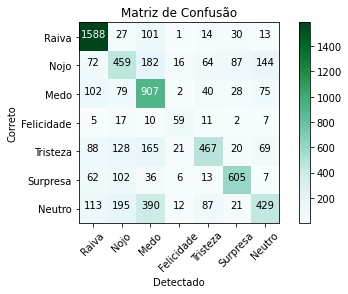

In [ ]:
plot_confusion_matrix(cm,emotions)

#pycm ConfusionMatrix


In [ ]:
!pip install pycm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.5 MB/s 
     |████████████████████████████████| 592 kB 30.9 MB/s 


In [ ]:
from pycm import ConfusionMatrix
import pandas as pd 
import numpy as np 
from keras.models import load_model
from tqdm import tqdm
from PIL import Image
from tensorflow.keras.utils import img_to_array

In [ ]:
emotions = ['Raiva', 'Nojo', 'Medo', 'Felicidade', 'Tristeza', 'Surpresa', 'Neutro']

In [ ]:
detection_model_path = '/content/drive/MyDrive/models_primeiro/haarcascade_frontalface_default.xml'
emotion_recognition_model_path = '/content/drive/MyDrive/models_primeiro/_mini_xception.80_0.65.hdf5'
FILE_PATH = '/content/drive/MyDrive/Data/unzip/fer2013/fer2013.csv'

In [ ]:
emotion_classifier = load_model(emotion_recognition_model_path)
data = pd.read_csv(FILE_PATH)   

In [ ]:
listImages = data.query('Usage == "PrivateTest" or Usage == "PublicTest"')
listImages.reset_index()

,index,emotion,pixels,Usage
0,28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,PublicTest
1,28710,1,156 184 198 202 204 207 210 212 213 214 215 21...,PublicTest
2,28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,PublicTest
3,28712,6,205 203 236 157 83 158 120 116 94 86 155 180 2...,PublicTest
4,28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,PublicTest
...,...,...,...,...
7173,35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
7174,35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
7175,35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
7176,35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [ ]:
listPreds = list()
listLabes = list()
countIdx = 0
for im in listImages['pixels']:
  b = bytes(int(p) for p in im.split())
  img1 = Image.frombuffer('L', (48, 48), b) 
  img3 = img_to_array(img1)
  img4 = img3.astype("float")/255.0
  img5 = np.expand_dims(img4, axis=0)
  preds = emotion_classifier.predict(img5)[0]
  emotion_probability = np.max(preds)
  label = emotions[preds.argmax()]
  listPreds.append(label)
  listLabes.append(emotions[listImages.iat[countIdx,0]])
  countIdx +=1;

A saída de streaming foi truncada nas últimas 5000 linhas.
1/1 [==============================] - 0s 30ms/step


In [ ]:
cm = ConfusionMatrix(actual_vector=listLabes, predict_vector=listPreds)
cm.save_html("models_primeiro_80_0.65.hdf5",color=(102, 255, 102))

{'Status': True, 'Message': '/content/models_primeiro_80_0.65.hdf5.html'}